<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_9_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.9, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<11:05,  1.50episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:05<31:45,  1.91s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:05<24:47,  1.49s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:10<40:59,  2.47s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:11<31:13,  1.88s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:15<44:04,  2.66s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:16<33:18,  2.01s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:20<46:03,  2.79s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:21<34:53,  2.11s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:26<47:46,  2.90s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.020993774756789207|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6203 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.017615949393429243 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.006724107186216365 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.06480922779517456 || eq_WSEE: 0.10557475616596732 || Reward: -0.36 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09412521427342523 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.05361174287870608, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:36<1:09:29,  4.22s/episode]

Loss: 0.062202319502830505|| Global step: 600 || Episode: 12 || Reward: 0.59 || Distance: 0.5445 ||
wsee: 0.11239816699618013, eqwsee: 0.13152993615391398, reward: 0.5896738764470295


  1%|1         | 13/1000 [00:38<58:55,  3.58s/episode]  

Loss: 0.020546920597553253|| Global step: 650 || Episode: 13 || Reward: -0.53 || Distance: 0.4729 ||
wsee: 0.1349518019530045, eqwsee: 0.13109976637185683, reward: -0.5313259207623415
|| Test Run No: 1100 || WSEE: 0.014846026863437937 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.006259146046942695 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.05584027890049268 || eq_WSEE: 0.10557475616596732 || Reward: -0.43 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09145143963110258 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.0485724378422248, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:44<1:10:52,  4.31s/episode]

Loss: 0.019851326942443848|| Global step: 700 || Episode: 14 || Reward: 0.24 || Distance: 0.9803 ||
wsee: 0.1107976548003314, eqwsee: 0.13152993615391398, reward: 0.23649363934258213


  2%|1         | 15/1000 [00:46<58:31,  3.57s/episode]  

Loss: 0.0023301809560507536|| Global step: 750 || Episode: 15 || Reward: 0.37 || Distance: 0.6726 ||
wsee: 0.11401802654699637, eqwsee: 0.08896563362710563, reward: 0.3650777543560577
|| Test Run No: 1100 || WSEE: 0.015759977109630688 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.005856718196046937 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.014336377208753208 || eq_WSEE: 0.10557475616596732 || Reward: -0.70 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09062120294444605 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.042828821227244865, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:52<1:10:19,  4.29s/episode]

Loss: 0.04248809814453125|| Global step: 800 || Episode: 16 || Reward: 0.92 || Distance: 0.5048 ||
wsee: 0.11225243226000087, eqwsee: 0.13152993615391398, reward: 0.9200614059609403


  2%|1         | 17/1000 [00:54<58:44,  3.59s/episode]  

Loss: 0.0009895497933030128|| Global step: 850 || Episode: 17 || Reward: -0.39 || Distance: 0.8556 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.3878723075217376
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.005498885743775009 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.01354026917226681 || eq_WSEE: 0.10557475616596732 || Reward: -0.71 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09037825950845323 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.03984103069893227, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [01:00<1:09:45,  4.26s/episode]

Loss: 0.023599224165081978|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6090 ||
wsee: 0.11358867859678853, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [01:02<57:52,  3.54s/episode]  

Loss: 0.03021852858364582|| Global step: 950 || Episode: 19 || Reward: -0.34 || Distance: 0.7457 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.34371382085054314
|| Test Run No: 1100 || WSEE: 0.060947334969135875 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.007506039319988026 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.016650787401312227 || eq_WSEE: 0.10557475616596732 || Reward: -0.66 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12446768445690184 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.06199424211266722, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:08<1:10:57,  4.34s/episode]

Loss: 0.03997558355331421|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6788 ||
wsee: 0.13402607438746436, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:10<59:31,  3.65s/episode]  

Loss: 0.012566912919282913|| Global step: 1050 || Episode: 21 || Reward: 1.39 || Distance: 0.2406 ||
wsee: 0.1347687940138653, eqwsee: 0.10375368536381287, reward: 1.3940988896056732
|| Test Run No: 1100 || WSEE: 0.07042548661431536 || eq_WSEE: 0.10417327110291066 || Reward: -0.03 ||
|| Test Run No: 1120 || WSEE: 0.005439830597188374 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.13838477544923977 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.05917915567583137, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:16<1:11:40,  4.40s/episode]

Loss: 0.030279142782092094|| Global step: 1100 || Episode: 22 || Reward: 1.38 || Distance: 1.0562 ||
wsee: 0.13991038879279072, eqwsee: 0.13152993615391398, reward: 1.382418011990669


  2%|2         | 23/1000 [01:18<1:00:00,  3.69s/episode]

Loss: 0.014012828469276428|| Global step: 1150 || Episode: 23 || Reward: 1.65 || Distance: 0.6665 ||
wsee: 0.14730859984208292, eqwsee: 0.12460080593306919, reward: 1.6523090902279653
|| Test Run No: 1100 || WSEE: 0.06813626849255883 || eq_WSEE: 0.10417327110291066 || Reward: -0.10 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.14597796521187928 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.05536610308778815, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:24<1:12:27,  4.45s/episode]

Loss: 0.022164033725857735|| Global step: 1200 || Episode: 24 || Reward: 0.13 || Distance: 0.6633 ||
wsee: 0.1420906969350343, eqwsee: 0.13152993615391398, reward: 0.1263944372151745


  2%|2         | 25/1000 [01:26<1:00:39,  3.73s/episode]

Loss: 0.017024461179971695|| Global step: 1250 || Episode: 25 || Reward: 0.09 || Distance: 0.9581 ||
wsee: 0.10356442225933196, eqwsee: 0.09376202016680894, reward: 0.09095764639686722
|| Test Run No: 1100 || WSEE: 0.06735949483385698 || eq_WSEE: 0.10417327110291066 || Reward: -0.11 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.14879181605628897 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.048188829421478833, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:33<1:12:14,  4.45s/episode]

Loss: 0.015444198623299599|| Global step: 1300 || Episode: 26 || Reward: 0.11 || Distance: 1.1877 ||
wsee: 0.14200302211933438, eqwsee: 0.13152993615391398, reward: 0.105610805701215


  3%|2         | 27/1000 [01:35<1:00:09,  3.71s/episode]

Loss: 0.009412911720573902|| Global step: 1350 || Episode: 27 || Reward: -4.87 || Distance: 0.5706 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -4.866992930687613
|| Test Run No: 1100 || WSEE: 0.0728210971173853 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.14927981999235268 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.04253628997344675, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:41<1:11:14,  4.40s/episode]

Loss: 0.008577637374401093|| Global step: 1400 || Episode: 28 || Reward: 0.38 || Distance: 0.5573 ||
wsee: 0.1396897686681292, eqwsee: 0.13152993615391398, reward: 0.3783537760868252


  3%|2         | 29/1000 [01:43<59:39,  3.69s/episode]  

Loss: 0.009432747028768063|| Global step: 1450 || Episode: 29 || Reward: -4.43 || Distance: 0.7280 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.427650038658027
|| Test Run No: 1100 || WSEE: 0.10428531571242816 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.14910573552360218 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.042016399686981475, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:49<1:11:39,  4.43s/episode]

Loss: 0.0036831411998718977|| Global step: 1500 || Episode: 30 || Reward: -7.34 || Distance: 0.2727 ||
wsee: 0.13865113150038225, eqwsee: 0.13152993615391398, reward: -7.33900452895545


  3%|3         | 31/1000 [01:51<1:00:46,  3.76s/episode]

Loss: 0.00808731373399496|| Global step: 1550 || Episode: 31 || Reward: 0.16 || Distance: 0.7540 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: 0.16193453466313817
|| Test Run No: 1100 || WSEE: 0.0718200103316955 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.15117948504250034 || eq_WSEE: 0.13084527637398705 || Reward: 0.15 ||
wsee:0.04226528221574489, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [01:58<1:14:17,  4.60s/episode]

Loss: 0.0035409678239375353|| Global step: 1600 || Episode: 32 || Reward: 0.71 || Distance: 0.5651 ||
wsee: 0.14032399442262689, eqwsee: 0.13152993615391398, reward: 0.713311675634568


  3%|3         | 33/1000 [02:00<1:02:23,  3.87s/episode]

Loss: 0.0038075486663728952|| Global step: 1650 || Episode: 33 || Reward: 0.40 || Distance: 0.4051 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.39955969859781826
|| Test Run No: 1100 || WSEE: 0.017754952465410555 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.14464837194465902 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.03721530752992164, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [02:06<1:14:57,  4.66s/episode]

Loss: 0.004300754517316818|| Global step: 1700 || Episode: 34 || Reward: 1.05 || Distance: 0.5543 ||
wsee: 0.124353327174875, eqwsee: 0.13152993615391398, reward: 1.0516928031557309


  4%|3         | 35/1000 [02:08<1:03:31,  3.95s/episode]

Loss: 0.002176509937271476|| Global step: 1750 || Episode: 35 || Reward: 0.39 || Distance: 0.4260 ||
wsee: 0.18129889929923587, eqwsee: 0.1546985766937026, reward: 0.3915339824162142
|| Test Run No: 1100 || WSEE: 0.01822099268332055 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1457020030594591 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.03731649802058679, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:15<1:15:07,  4.68s/episode]

Loss: 0.009033427573740482|| Global step: 1800 || Episode: 36 || Reward: 1.95 || Distance: 0.5830 ||
wsee: 0.12553899626034168, eqwsee: 0.13152993615391398, reward: 1.9507863981540856


  4%|3         | 37/1000 [02:17<1:03:25,  3.95s/episode]

Loss: 0.0030030750203877687|| Global step: 1850 || Episode: 37 || Reward: -0.15 || Distance: 0.5656 ||
wsee: 0.13107763485025034, eqwsee: 0.12942636481142852, reward: -0.15395286686404347
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.13733331944252467 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.033541057110215274, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:24<1:15:27,  4.71s/episode]

Loss: 0.0041747805662453175|| Global step: 1900 || Episode: 38 || Reward: 0.00 || Distance: 0.7790 ||
wsee: 0.06625409681861205, eqwsee: 0.13152993615391398, reward: 0.003573526059584206


  4%|3         | 39/1000 [02:26<1:03:40,  3.98s/episode]

Loss: 0.005572791211307049|| Global step: 1950 || Episode: 39 || Reward: 0.16 || Distance: 0.3058 ||
wsee: 0.15806234657507953, eqwsee: 0.13366216924837832, reward: 0.1631813545265143
|| Test Run No: 1100 || WSEE: 0.01749125529005549 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.13850132881537555 || eq_WSEE: 0.13084527637398705 || Reward: -0.04 ||
wsee:0.03377110563650148, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:32<1:14:20,  4.65s/episode]

Loss: 0.0040221489034593105|| Global step: 2000 || Episode: 40 || Reward: 1.06 || Distance: 0.5696 ||
wsee: 0.06847236974952597, eqwsee: 0.13152993615391398, reward: 1.062143713070377


  4%|4         | 41/1000 [02:34<1:02:33,  3.91s/episode]

Loss: 0.0061341701075434685|| Global step: 2050 || Episode: 41 || Reward: -7.04 || Distance: 0.8249 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -7.042158051833995
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.13907622187037305 || eq_WSEE: 0.13084527637398705 || Reward: -0.04 ||
wsee:0.03360784181453609, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:41<1:14:03,  4.64s/episode]

Loss: 0.0031651905737817287|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.6550 ||
wsee: 0.057042359263404584, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [02:43<1:02:17,  3.90s/episode]

Loss: 0.0031704423017799854|| Global step: 2150 || Episode: 43 || Reward: -0.72 || Distance: 0.1733 ||
wsee: 0.12180502995233358, eqwsee: 0.10543505078886685, reward: -0.72053259032841
|| Test Run No: 1100 || WSEE: 0.017595727471957662 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.13980629577818135 || eq_WSEE: 0.13084527637398705 || Reward: -0.03 ||
wsee:0.03376722885458109, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [02:49<1:13:42,  4.63s/episode]

Loss: 0.0029228769708424807|| Global step: 2200 || Episode: 44 || Reward: 1.13 || Distance: 0.3961 ||
wsee: 0.058899201620797086, eqwsee: 0.13152993615391398, reward: 1.125713311519359


  4%|4         | 45/1000 [02:51<1:02:13,  3.91s/episode]

Loss: 0.0033186767250299454|| Global step: 2250 || Episode: 45 || Reward: -0.47 || Distance: 0.7726 ||
wsee: 0.09959097536600842, eqwsee: 0.09938214209364687, reward: -0.4732009156431507
|| Test Run No: 1100 || WSEE: 0.01928784610561292 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.14061903925828162 || eq_WSEE: 0.13084527637398705 || Reward: -0.02 ||
wsee:0.03392346465470246, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [02:58<1:13:55,  4.65s/episode]

Loss: 0.001996834296733141|| Global step: 2300 || Episode: 46 || Reward: 1.48 || Distance: 0.2195 ||
wsee: 0.06114201993961445, eqwsee: 0.13152993615391398, reward: 1.4839368096090548


  5%|4         | 47/1000 [03:00<1:02:44,  3.95s/episode]

Loss: 0.003930842038244009|| Global step: 2350 || Episode: 47 || Reward: 0.18 || Distance: 0.5847 ||
wsee: 0.14762982079907197, eqwsee: 0.12716993041365515, reward: 0.17503470929961648
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.14123347822977297 || eq_WSEE: 0.13084527637398705 || Reward: -0.02 ||
wsee:0.033978736758199915, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [03:06<1:14:12,  4.68s/episode]

Loss: 0.0020874501205980778|| Global step: 2400 || Episode: 48 || Reward: 0.04 || Distance: 0.7781 ||
wsee: 0.06301497413086919, eqwsee: 0.13152993615391398, reward: 0.03729774025134322


  5%|4         | 49/1000 [03:09<1:02:49,  3.96s/episode]

Loss: 0.0019472033018246293|| Global step: 2450 || Episode: 49 || Reward: -5.14 || Distance: 0.2726 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -5.140755245295881
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1359269833208659 || eq_WSEE: 0.13084527637398705 || Reward: -0.24 ||
wsee:0.031113889133610288, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [03:15<1:13:28,  4.64s/episode]

Loss: 0.002658236538991332|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3790 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [03:17<1:02:13,  3.93s/episode]

Loss: 0.0030562093015760183|| Global step: 2550 || Episode: 51 || Reward: -0.19 || Distance: 0.7148 ||
wsee: 0.10914446062431431, eqwsee: 0.09371570435552588, reward: -0.1935250051892441
|| Test Run No: 1100 || WSEE: 0.01584471131921083 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.13053340069911215 || eq_WSEE: 0.13084527637398705 || Reward: -0.51 ||
wsee:0.02835579389351429, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [03:24<1:13:40,  4.66s/episode]

Loss: 0.003184541827067733|| Global step: 2600 || Episode: 52 || Reward: 0.82 || Distance: 0.3734 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8200386978608332


  5%|5         | 53/1000 [03:26<1:03:11,  4.00s/episode]

Loss: 0.004385538399219513|| Global step: 2650 || Episode: 53 || Reward: -5.03 || Distance: 0.2228 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -5.034179413762879
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1278493483338883 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02680291311237797, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [03:33<1:15:27,  4.79s/episode]

Loss: 0.004716141615062952|| Global step: 2700 || Episode: 54 || Reward: -5.17 || Distance: 0.1477 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.173886807693772


  6%|5         | 55/1000 [03:35<1:04:19,  4.08s/episode]

Loss: 0.0018961444729939103|| Global step: 2750 || Episode: 55 || Reward: 0.02 || Distance: 0.1026 ||
wsee: 0.1451315071427879, eqwsee: 0.1195833502440462, reward: 0.016989262438244362
|| Test Run No: 1100 || WSEE: 0.019080899948524337 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1272467016147084 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02537648721752989, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [03:42<1:16:18,  4.85s/episode]

Loss: 0.003058931790292263|| Global step: 2800 || Episode: 56 || Reward: 1.75 || Distance: 0.3757 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7450719165882864


  6%|5         | 57/1000 [03:44<1:04:33,  4.11s/episode]

Loss: 0.0019649250898510218|| Global step: 2850 || Episode: 57 || Reward: -4.78 || Distance: 0.1452 ||
wsee: 7.309871567986143e-05, eqwsee: 0.09568350753601491, reward: -4.780520441016751
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12387898751551758 || eq_WSEE: 0.13084527637398705 || Reward: -0.56 ||
wsee:0.024571869359024688, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [03:51<1:15:33,  4.81s/episode]

Loss: 0.0023851864971220493|| Global step: 2900 || Episode: 58 || Reward: -3.83 || Distance: 0.4561 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.833091611355211


  6%|5         | 59/1000 [03:53<1:04:25,  4.11s/episode]

Loss: 0.003230287227779627|| Global step: 2950 || Episode: 59 || Reward: 0.07 || Distance: 0.8483 ||
wsee: 0.16900723754886607, eqwsee: 0.14337031954840265, reward: 0.06954627440334205
|| Test Run No: 1100 || WSEE: 0.014718575950257886 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11741508692441933 || eq_WSEE: 0.13084527637398705 || Reward: -0.61 ||
wsee:0.023687905068357183, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [04:00<1:15:43,  4.83s/episode]

Loss: 0.0024861982092261314|| Global step: 3000 || Episode: 60 || Reward: 0.41 || Distance: 0.6313 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4057244189997362


  6%|6         | 61/1000 [04:02<1:04:49,  4.14s/episode]

Loss: 0.005937057547271252|| Global step: 3050 || Episode: 61 || Reward: 0.65 || Distance: 0.4768 ||
wsee: 0.18031698344689293, eqwsee: 0.14523213734839777, reward: 0.6542209676637208
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11153638118039413 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.02239967382715715, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [04:09<1:16:18,  4.88s/episode]

Loss: 0.0031106790993362665|| Global step: 3100 || Episode: 62 || Reward: -4.30 || Distance: 0.3101 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.300687525271351


  6%|6         | 63/1000 [04:11<1:04:44,  4.15s/episode]

Loss: 0.004733175504952669|| Global step: 3150 || Episode: 63 || Reward: 0.88 || Distance: 0.2123 ||
wsee: 0.16854432336710187, eqwsee: 0.13208198076632058, reward: 0.8844541309997397
|| Test Run No: 1100 || WSEE: 0.015722243538600602 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11089242730701533 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.022504552838216983, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [04:17<1:15:11,  4.82s/episode]

Loss: 0.003707494121044874|| Global step: 3200 || Episode: 64 || Reward: 0.83 || Distance: 0.4496 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8311311855833675


  6%|6         | 65/1000 [04:20<1:03:56,  4.10s/episode]

Loss: 0.004224877804517746|| Global step: 3250 || Episode: 65 || Reward: 0.09 || Distance: 0.2949 ||
wsee: 0.15863025117841512, eqwsee: 0.12165755228267655, reward: 0.09359384987359665
|| Test Run No: 1100 || WSEE: 0.017074377228042427 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11003830236412845 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022453992683435127, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [04:27<1:16:13,  4.90s/episode]

Loss: 0.0027622173074632883|| Global step: 3300 || Episode: 66 || Reward: 1.20 || Distance: 0.4372 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.201246512558977


  7%|6         | 67/1000 [04:29<1:05:11,  4.19s/episode]

Loss: 0.006196910981088877|| Global step: 3350 || Episode: 67 || Reward: 0.33 || Distance: 0.3819 ||
wsee: 0.1587827328167258, eqwsee: 0.12686051062707315, reward: 0.3253385960346227
|| Test Run No: 1100 || WSEE: 0.018687822169785345 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11009346532059762 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022476156529298887, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [04:36<1:16:58,  4.96s/episode]

Loss: 0.0035276925191283226|| Global step: 3400 || Episode: 68 || Reward: 1.91 || Distance: 0.2235 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9059983599858465


  7%|6         | 69/1000 [04:39<1:05:55,  4.25s/episode]

Loss: 0.0017447753343731165|| Global step: 3450 || Episode: 69 || Reward: -0.09 || Distance: 0.3099 ||
wsee: 0.15320108056433004, eqwsee: 0.13495539352471292, reward: -0.0851423200155001
|| Test Run No: 1100 || WSEE: 0.015441571512098113 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11016353580359459 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022450273053507414, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [04:45<1:16:48,  4.96s/episode]

Loss: 0.004504400305449963|| Global step: 3500 || Episode: 70 || Reward: 0.67 || Distance: 0.6030 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6709444399878205


  7%|7         | 71/1000 [04:48<1:05:53,  4.26s/episode]

Loss: 0.005782859865576029|| Global step: 3550 || Episode: 71 || Reward: -0.12 || Distance: 0.4331 ||
wsee: 0.13755075276258968, eqwsee: 0.1217394096666866, reward: -0.12125387610472739
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11020621360890617 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.02230513271807637, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [04:54<1:16:26,  4.94s/episode]

Loss: 0.004528241232037544|| Global step: 3600 || Episode: 72 || Reward: -5.76 || Distance: 0.2590 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.755685708255258


  7%|7         | 73/1000 [04:57<1:05:11,  4.22s/episode]

Loss: 0.0024216249585151672|| Global step: 3650 || Episode: 73 || Reward: -1.33 || Distance: 0.5991 ||
wsee: 0.1554643165920521, eqwsee: 0.15288602961823075, reward: -1.3285575048131903
|| Test Run No: 1100 || WSEE: 0.018596854800761453 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1102371763900264 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022488827778761756, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [05:04<1:16:27,  4.95s/episode]

Loss: 0.004788991995155811|| Global step: 3700 || Episode: 74 || Reward: 0.93 || Distance: 0.2936 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9335695287916362


  8%|7         | 75/1000 [05:06<1:06:37,  4.32s/episode]

Loss: 0.002368579152971506|| Global step: 3750 || Episode: 75 || Reward: 0.22 || Distance: 0.6219 ||
wsee: 0.11385624876313546, eqwsee: 0.09627257334639852, reward: 0.21970519325519677
|| Test Run No: 1100 || WSEE: 0.01908530053600623 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11024367831445182 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022494432151287512, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [05:13<1:18:15,  5.08s/episode]

Loss: 0.005214597098529339|| Global step: 3800 || Episode: 76 || Reward: 1.91 || Distance: 0.1629 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9084943414478737


  8%|7         | 77/1000 [05:16<1:07:06,  4.36s/episode]

Loss: 0.002434100955724716|| Global step: 3850 || Episode: 77 || Reward: 1.39 || Distance: 0.1147 ||
wsee: 0.19771742765313938, eqwsee: 0.15128695705743034, reward: 1.3937272783895107
|| Test Run No: 1100 || WSEE: 0.016702355767423554 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11023634993892371 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022469910384427295, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [05:23<1:18:12,  5.09s/episode]

Loss: 0.0039044413715600967|| Global step: 3900 || Episode: 78 || Reward: 1.08 || Distance: 0.2800 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0798291470309185


  8%|7         | 79/1000 [05:25<1:07:30,  4.40s/episode]

Loss: 0.004268488381057978|| Global step: 3950 || Episode: 79 || Reward: -0.11 || Distance: 0.0931 ||
wsee: 0.14192452833929853, eqwsee: 0.11141469645881293, reward: -0.1109798861667698
|| Test Run No: 1100 || WSEE: 0.01705019240271888 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1102213637737532 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022471961511994112, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [05:32<1:18:39,  5.13s/episode]

Loss: 0.002862734254449606|| Global step: 4000 || Episode: 80 || Reward: 1.22 || Distance: 0.2858 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2163381718199777


  8%|8         | 81/1000 [05:35<1:07:31,  4.41s/episode]

Loss: 0.003926148638129234|| Global step: 4050 || Episode: 81 || Reward: -1.33 || Distance: 0.2464 ||
wsee: 0.11517876842583472, eqwsee: 0.11480777355807266, reward: -1.3270527396738956
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11019230292764873 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.02230408540434449, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [05:42<1:19:34,  5.20s/episode]

Loss: 0.0018206784734502435|| Global step: 4100 || Episode: 82 || Reward: -6.58 || Distance: 0.1717 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.582217851598646


  8%|8         | 83/1000 [05:45<1:08:29,  4.48s/episode]

Loss: 0.003345704637467861|| Global step: 4150 || Episode: 83 || Reward: -5.99 || Distance: 0.2803 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -5.9918775985881885
|| Test Run No: 1100 || WSEE: 0.016429189640959126 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11016724409344618 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022460837153335404, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [05:52<1:19:09,  5.19s/episode]

Loss: 0.001833269139751792|| Global step: 4200 || Episode: 84 || Reward: 0.28 || Distance: 0.2841 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2823458230285957


  8%|8         | 85/1000 [05:54<1:07:56,  4.46s/episode]

Loss: 0.002681188751012087|| Global step: 4250 || Episode: 85 || Reward: -0.21 || Distance: 0.2168 ||
wsee: 0.09558137744255682, eqwsee: 0.09230989531623571, reward: -0.20527280038751478
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11016534942443158 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022301544209253045, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [06:01<1:17:52,  5.11s/episode]

Loss: 0.0029022186063230038|| Global step: 4300 || Episode: 86 || Reward: -5.55 || Distance: 0.2379 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.5457500967853175


  9%|8         | 87/1000 [06:04<1:06:55,  4.40s/episode]

Loss: 0.004750226624310017|| Global step: 4350 || Episode: 87 || Reward: -5.66 || Distance: 0.0767 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -5.656813839032048
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1101455812085247 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022299941614825666, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [06:11<1:17:22,  5.09s/episode]

Loss: 0.003800614969804883|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.3615 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [06:13<1:06:30,  4.38s/episode]

Loss: 0.0026293897535651922|| Global step: 4450 || Episode: 89 || Reward: 0.71 || Distance: 0.4205 ||
wsee: 0.14473758076674287, eqwsee: 0.13078292750269094, reward: 0.7068193093549238
|| Test Run No: 1100 || WSEE: 0.017822858711245775 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11012899454345107 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.02247152032634824, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [06:20<1:16:43,  5.06s/episode]

Loss: 0.004256170243024826|| Global step: 4500 || Episode: 90 || Reward: 1.53 || Distance: 0.2443 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5332227459078254


  9%|9         | 91/1000 [06:23<1:06:54,  4.42s/episode]

Loss: 0.00325546832755208|| Global step: 4550 || Episode: 91 || Reward: -0.19 || Distance: 0.2187 ||
wsee: 0.19925597972398856, eqwsee: 0.17312453190109664, reward: -0.18630253270082123
|| Test Run No: 1100 || WSEE: 0.016139659978195976 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11008377104663196 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.02245102391403588, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [06:30<1:19:35,  5.26s/episode]

Loss: 0.004696745425462723|| Global step: 4600 || Episode: 92 || Reward: 0.93 || Distance: 0.6732 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9262639401852653


  9%|9         | 93/1000 [06:33<1:08:48,  4.55s/episode]

Loss: 0.0026340677868574858|| Global step: 4650 || Episode: 93 || Reward: -8.05 || Distance: 0.3712 ||
wsee: 0.00020050932690897746, eqwsee: 0.16126954815004813, reward: -8.05345194115695
|| Test Run No: 1100 || WSEE: 0.01740273853170296 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11000026542453253 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.02245697938386842, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [06:40<1:21:33,  5.40s/episode]

Loss: 0.003851687302812934|| Global step: 4700 || Episode: 94 || Reward: -0.47 || Distance: 0.2608 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.466029426333769


 10%|9         | 95/1000 [06:43<1:10:25,  4.67s/episode]

Loss: 0.00533800944685936|| Global step: 4750 || Episode: 95 || Reward: 0.03 || Distance: 0.1760 ||
wsee: 0.13128452478607044, eqwsee: 0.11205650903237177, reward: 0.029042717038723104
|| Test Run No: 1100 || WSEE: 0.018436719484936796 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10988633998688008 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.022458341546051964, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [06:51<1:22:05,  5.45s/episode]

Loss: 0.0030197135638445616|| Global step: 4800 || Episode: 96 || Reward: 1.22 || Distance: 0.3844 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2166598403584912


 10%|9         | 97/1000 [06:54<1:10:57,  4.71s/episode]

Loss: 0.005495133809745312|| Global step: 4850 || Episode: 97 || Reward: 0.70 || Distance: 0.3292 ||
wsee: 0.17965643115638635, eqwsee: 0.1438770677374375, reward: 0.7000739035819622
|| Test Run No: 1100 || WSEE: 0.015063761802646585 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10994586436478167 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.02243368600413214, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [07:01<1:21:34,  5.43s/episode]

Loss: 0.003960351459681988|| Global step: 4900 || Episode: 98 || Reward: 0.29 || Distance: 0.5387 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.291717301666973


 10%|9         | 99/1000 [07:04<1:10:27,  4.69s/episode]

Loss: 0.0029409807175397873|| Global step: 4950 || Episode: 99 || Reward: 0.24 || Distance: 0.3565 ||
wsee: 0.12032651428987874, eqwsee: 0.10245243408924709, reward: 0.23913886785169647
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10902833497430807 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.022224429049188005, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [07:11<1:21:09,  5.41s/episode]

Loss: 0.007215398363769054|| Global step: 5000 || Episode: 100 || Reward: -6.79 || Distance: 0.1924 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.785158013918666


 10%|#         | 101/1000 [07:14<1:10:49,  4.73s/episode]

Loss: 0.005063846707344055|| Global step: 5050 || Episode: 101 || Reward: -0.25 || Distance: 0.5889 ||
wsee: 0.09626774982175498, eqwsee: 0.0903939833962715, reward: -0.2514370466149895
|| Test Run No: 1100 || WSEE: 0.017481108713186207 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10895547141821806 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.022387065598098235, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [07:21<1:23:02,  5.55s/episode]

Loss: 0.003153211437165737|| Global step: 5100 || Episode: 102 || Reward: 1.70 || Distance: 0.2933 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7007408631266525


 10%|#         | 103/1000 [07:24<1:12:03,  4.82s/episode]

Loss: 0.002960272366181016|| Global step: 5150 || Episode: 103 || Reward: 0.43 || Distance: 0.2927 ||
wsee: 0.16491072390257097, eqwsee: 0.13455395481375648, reward: 0.42512428134416413
|| Test Run No: 1100 || WSEE: 0.017829487209169707 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10881573421890382 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.022381378438149625, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [07:32<1:23:02,  5.56s/episode]

Loss: 0.0055731553584337234|| Global step: 5200 || Episode: 104 || Reward: 0.74 || Distance: 0.3303 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7361250668865391


 10%|#         | 105/1000 [07:35<1:12:01,  4.83s/episode]

Loss: 0.002837215783074498|| Global step: 5250 || Episode: 105 || Reward: -5.92 || Distance: 0.1728 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -5.919701890396906
|| Test Run No: 1100 || WSEE: 0.01600890010405779 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10873636689293197 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.022357332725995646, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [07:42<1:22:12,  5.52s/episode]

Loss: 0.006956514902412891|| Global step: 5300 || Episode: 106 || Reward: -0.17 || Distance: 0.1835 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.16576252496160815


 11%|#         | 107/1000 [07:45<1:11:23,  4.80s/episode]

Loss: 0.004340080544352531|| Global step: 5350 || Episode: 107 || Reward: -7.78 || Distance: 0.1688 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -7.7777365663447835
|| Test Run No: 1100 || WSEE: 0.016717160711471144 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10841524676840966 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.022345112589972963, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [07:52<1:22:27,  5.55s/episode]

Loss: 0.0045690760016441345|| Global step: 5400 || Episode: 108 || Reward: -0.02 || Distance: 0.4127 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.024662253282154142


 11%|#         | 109/1000 [07:56<1:11:32,  4.82s/episode]

Loss: 0.004311833065003157|| Global step: 5450 || Episode: 109 || Reward: 0.49 || Distance: 0.2707 ||
wsee: 0.11863547665851322, eqwsee: 0.09374848365668549, reward: 0.490611058722174
|| Test Run No: 1100 || WSEE: 0.017766767876251012 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10736616033292692 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.022288992569842528, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [08:03<1:22:07,  5.54s/episode]

Loss: 0.0022344407625496387|| Global step: 5500 || Episode: 110 || Reward: 1.09 || Distance: 0.3505 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.09052686604637


 11%|#1        | 111/1000 [08:06<1:11:31,  4.83s/episode]

Loss: 0.006132656708359718|| Global step: 5550 || Episode: 111 || Reward: 0.89 || Distance: 0.4327 ||
wsee: 0.1419678511103084, eqwsee: 0.1133930359662023, reward: 0.8909873830104016
|| Test Run No: 1100 || WSEE: 0.014764828233971803 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10761689749299895 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.022284656888269656, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [08:13<1:22:09,  5.55s/episode]

Loss: 0.004402863327413797|| Global step: 5600 || Episode: 112 || Reward: 0.31 || Distance: 0.7223 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3084451390691262


 11%|#1        | 113/1000 [08:16<1:11:46,  4.85s/episode]

Loss: 0.004065977409482002|| Global step: 5650 || Episode: 113 || Reward: 0.79 || Distance: 0.2033 ||
wsee: 0.10725783086131585, eqwsee: 0.08060645463185492, reward: 0.7917466733227112
|| Test Run No: 1100 || WSEE: 0.019012666690728326 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10602144262490655 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.022199651714161585, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [08:24<1:23:17,  5.64s/episode]

Loss: 0.003796941600739956|| Global step: 5700 || Episode: 114 || Reward: 1.27 || Distance: 0.1305 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.273760263024212


 12%|#1        | 115/1000 [08:27<1:12:26,  4.91s/episode]

Loss: 0.005062085576355457|| Global step: 5750 || Episode: 115 || Reward: -0.01 || Distance: 0.6279 ||
wsee: 0.15584109153301615, eqwsee: 0.13499431860432443, reward: -0.01041867652115569
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10582639482439898 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.022191704868628124, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [08:35<1:24:09,  5.71s/episode]

Loss: 0.003849832806736231|| Global step: 5800 || Episode: 116 || Reward: 0.22 || Distance: 0.3296 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.21755451084227165


 12%|#1        | 117/1000 [08:38<1:13:23,  4.99s/episode]

Loss: 0.007056841626763344|| Global step: 5850 || Episode: 117 || Reward: -0.24 || Distance: 0.3253 ||
wsee: 0.09521706414444196, eqwsee: 0.08652146543575229, reward: -0.23592306778154282
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10540919187506241 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.022030482179223917, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [08:45<1:22:17,  5.60s/episode]

Loss: 0.002907696645706892|| Global step: 5900 || Episode: 118 || Reward: -4.19 || Distance: 0.3393 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.186487504182314


 12%|#1        | 119/1000 [08:48<1:11:55,  4.90s/episode]

Loss: 0.002549216151237488|| Global step: 5950 || Episode: 119 || Reward: -6.61 || Distance: 0.2667 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -6.605953884273716
|| Test Run No: 1100 || WSEE: 0.016374490578123322 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08958833601725251 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.02126254358744536, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [08:56<1:22:38,  5.64s/episode]

Loss: 0.0029750193934887648|| Global step: 6000 || Episode: 120 || Reward: 0.52 || Distance: 0.3430 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5192430924872535


 12%|#2        | 121/1000 [08:59<1:11:56,  4.91s/episode]

Loss: 0.002879296662285924|| Global step: 6050 || Episode: 121 || Reward: -0.31 || Distance: 0.4147 ||
wsee: 0.1085571853744775, eqwsee: 0.1068064543895102, reward: -0.31347762189307715
|| Test Run No: 1100 || WSEE: 0.015516263330326803 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08969165102047914 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.02125813826485095, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [09:06<1:21:45,  5.59s/episode]

Loss: 0.005054319277405739|| Global step: 6100 || Episode: 122 || Reward: 0.58 || Distance: 0.4121 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5754127532971745


 12%|#2        | 123/1000 [09:09<1:10:43,  4.84s/episode]

Loss: 0.0034434706903994083|| Global step: 6150 || Episode: 123 || Reward: -0.66 || Distance: 0.2268 ||
wsee: 0.14942280467655097, eqwsee: 0.14704602472359213, reward: -0.6550882702933559
|| Test Run No: 1100 || WSEE: 0.019109811640712047 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08948744160327651 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.021268658312232416, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [09:16<1:20:56,  5.54s/episode]

Loss: 0.003279005875810981|| Global step: 6200 || Episode: 124 || Reward: 0.97 || Distance: 0.2698 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.969272639994007


 12%|#2        | 125/1000 [09:20<1:10:50,  4.86s/episode]

Loss: 0.0020760027691721916|| Global step: 6250 || Episode: 125 || Reward: -0.79 || Distance: 0.2853 ||
wsee: 0.13218840761518724, eqwsee: 0.1266206041293283, reward: -0.7898281778900773
|| Test Run No: 1100 || WSEE: 0.01585112972280914 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08847115498035583 || eq_WSEE: 0.13084527637398705 || Reward: -0.81 ||
wsee:0.021107711267790347, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [09:27<1:20:42,  5.54s/episode]

Loss: 0.0042344070971012115|| Global step: 6300 || Episode: 126 || Reward: 0.66 || Distance: 0.1616 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6604997199439686


 13%|#2        | 127/1000 [09:30<1:10:33,  4.85s/episode]

Loss: 0.006207544356584549|| Global step: 6350 || Episode: 127 || Reward: -0.34 || Distance: 0.4533 ||
wsee: 0.14278977906263693, eqwsee: 0.12531465515260803, reward: -0.3386479151540702
|| Test Run No: 1100 || WSEE: 0.017781503707932293 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08579997112969157 || eq_WSEE: 0.13084527637398705 || Reward: -0.83 ||
wsee:0.020378650523761633, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [09:37<1:20:11,  5.52s/episode]

Loss: 0.003435998223721981|| Global step: 6400 || Episode: 128 || Reward: 1.98 || Distance: 0.4170 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9808293293337282


 13%|#2        | 129/1000 [09:40<1:10:11,  4.84s/episode]

Loss: 0.004595888312906027|| Global step: 6450 || Episode: 129 || Reward: 1.20 || Distance: 0.2752 ||
wsee: 0.16596742255864672, eqwsee: 0.12772584936887826, reward: 1.2041317467085482
|| Test Run No: 1100 || WSEE: 0.017053207386864347 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08446178413560664 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.020317061189029033, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [09:48<1:20:57,  5.58s/episode]

Loss: 0.0029712715186178684|| Global step: 6500 || Episode: 130 || Reward: 1.29 || Distance: 0.4830 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2918740044392538


 13%|#3        | 131/1000 [09:51<1:10:47,  4.89s/episode]

Loss: 0.0038736513815820217|| Global step: 6550 || Episode: 131 || Reward: 0.29 || Distance: 0.2221 ||
wsee: 0.15559019508977087, eqwsee: 0.12009873610401972, reward: 0.2902938512213208
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08366442056759794 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.020113069567077944, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [09:58<1:20:14,  5.55s/episode]

Loss: 0.005781196989119053|| Global step: 6600 || Episode: 132 || Reward: -5.44 || Distance: 0.2767 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.441359241267578


 13%|#3        | 133/1000 [10:01<1:10:03,  4.85s/episode]

Loss: 0.004325656220316887|| Global step: 6650 || Episode: 133 || Reward: -6.34 || Distance: 0.1964 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -6.335291210636339
|| Test Run No: 1100 || WSEE: 0.016184758790049818 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08076536387950223 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.020213292807529804, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [10:09<1:21:12,  5.63s/episode]

Loss: 0.004131842404603958|| Global step: 6700 || Episode: 134 || Reward: 0.58 || Distance: 0.2162 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5842011733309159


 14%|#3        | 135/1000 [10:12<1:11:54,  4.99s/episode]

Loss: 0.0021057226695120335|| Global step: 6750 || Episode: 135 || Reward: 0.65 || Distance: 0.3856 ||
wsee: 0.13253604418436093, eqwsee: 0.10596101217868595, reward: 0.6499149978319425
|| Test Run No: 1100 || WSEE: 0.016685418882220655 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08286875678008093 || eq_WSEE: 0.13084527637398705 || Reward: -0.85 ||
wsee:0.02007366937597597, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [10:20<1:22:58,  5.76s/episode]

Loss: 0.003349762177094817|| Global step: 6800 || Episode: 136 || Reward: 0.93 || Distance: 0.3205 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9309425667908057


 14%|#3        | 137/1000 [10:23<1:13:10,  5.09s/episode]

Loss: 0.0032845919486135244|| Global step: 6850 || Episode: 137 || Reward: -5.75 || Distance: 0.3423 ||
wsee: 0.0014709188320600258, eqwsee: 0.11645374864848552, reward: -5.749141490821282
|| Test Run No: 1100 || WSEE: 0.017339047907036664 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015335110365223371, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [10:31<1:23:57,  5.84s/episode]

Loss: 0.004661635495722294|| Global step: 6900 || Episode: 138 || Reward: 0.54 || Distance: 0.2432 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5418886918573614


 14%|#3        | 139/1000 [10:34<1:13:31,  5.12s/episode]

Loss: 0.0035803618375211954|| Global step: 6950 || Episode: 139 || Reward: -0.61 || Distance: 0.2205 ||
wsee: 0.07825264768267806, eqwsee: 0.07967767598104078, reward: -0.6083595788083553
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015364847766104854, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [10:42<1:24:29,  5.89s/episode]

Loss: 0.003224843181669712|| Global step: 7000 || Episode: 140 || Reward: -5.47 || Distance: 0.2868 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.468102152866305


 14%|#4        | 141/1000 [10:45<1:14:32,  5.21s/episode]

Loss: 0.002925705164670944|| Global step: 7050 || Episode: 141 || Reward: -0.01 || Distance: 0.2565 ||
wsee: 0.06622238542883233, eqwsee: 0.0596140608006554, reward: -0.01153342047042856
|| Test Run No: 1100 || WSEE: 0.0178615828852538 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015464438832094817, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [10:53<1:25:34,  5.98s/episode]

Loss: 0.0034054694697260857|| Global step: 7100 || Episode: 142 || Reward: 1.50 || Distance: 0.1545 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4987249953452206


 14%|#4        | 143/1000 [10:57<1:14:31,  5.22s/episode]

Loss: 0.004155932925641537|| Global step: 7150 || Episode: 143 || Reward: -0.11 || Distance: 0.3972 ||
wsee: 0.13577882911241831, eqwsee: 0.12082249036212048, reward: -0.10922692987394017
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015341531145693579, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [11:04<1:24:32,  5.93s/episode]

Loss: 0.004016168415546417|| Global step: 7200 || Episode: 144 || Reward: -3.72 || Distance: 0.1672 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.718141804477653


 14%|#4        | 145/1000 [11:08<1:15:08,  5.27s/episode]

Loss: 0.003931477665901184|| Global step: 7250 || Episode: 145 || Reward: 1.31 || Distance: 0.2354 ||
wsee: 0.14014768883096204, eqwsee: 0.10804323163315988, reward: 1.3050520879419134
|| Test Run No: 1100 || WSEE: 0.018184321774698187 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015543256934408313, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [11:16<1:26:28,  6.08s/episode]

Loss: 0.002349098911508918|| Global step: 7300 || Episode: 146 || Reward: 1.36 || Distance: 0.2442 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3642293015518812


 15%|#4        | 147/1000 [11:19<1:15:27,  5.31s/episode]

Loss: 0.0038823981303721666|| Global step: 7350 || Episode: 147 || Reward: 0.74 || Distance: 0.0840 ||
wsee: 0.14409564447227824, eqwsee: 0.10928827558944719, reward: 0.7404514575352368
|| Test Run No: 1100 || WSEE: 0.01922638506681352 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015527865077391647, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [11:28<1:27:18,  6.15s/episode]

Loss: 0.003825636114925146|| Global step: 7400 || Episode: 148 || Reward: 2.09 || Distance: 0.3047 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0850835273748554


 15%|#4        | 149/1000 [11:31<1:16:31,  5.40s/episode]

Loss: 0.00432482548058033|| Global step: 7450 || Episode: 149 || Reward: -0.89 || Distance: 0.3033 ||
wsee: 0.23407870079885792, eqwsee: 0.18824242066067803, reward: -0.8919969447076644
|| Test Run No: 1100 || WSEE: 0.016929900115863417 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015579781165040602, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [11:39<1:26:40,  6.12s/episode]

Loss: 0.00361263076774776|| Global step: 7500 || Episode: 150 || Reward: 1.16 || Distance: 0.2773 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1567429964259204


 15%|#5        | 151/1000 [11:43<1:16:37,  5.42s/episode]

Loss: 0.004438550677150488|| Global step: 7550 || Episode: 151 || Reward: 0.65 || Distance: 0.3960 ||
wsee: 0.1220533385646803, eqwsee: 0.09488279119230687, reward: 0.6480756503626814
|| Test Run No: 1100 || WSEE: 0.017817764538662177 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015568679670460914, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [11:50<1:25:48,  6.07s/episode]

Loss: 0.00428037578240037|| Global step: 7600 || Episode: 152 || Reward: 1.68 || Distance: 0.1421 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6805578588063024


 15%|#5        | 153/1000 [11:54<1:15:32,  5.35s/episode]

Loss: 0.004903430584818125|| Global step: 7650 || Episode: 153 || Reward: -5.66 || Distance: 0.0368 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -5.658399770164553
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014738742937983414, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [12:02<1:25:51,  6.09s/episode]

Loss: 0.003074929118156433|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.4022 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [12:06<1:15:42,  5.38s/episode]

Loss: 0.006048995070159435|| Global step: 7750 || Episode: 155 || Reward: 0.07 || Distance: 0.3820 ||
wsee: 0.14806450628899318, eqwsee: 0.12108352547142147, reward: 0.07096124331217324
|| Test Run No: 1100 || WSEE: 0.015160744638502291 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015135552056050534, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [12:13<1:24:51,  6.03s/episode]

Loss: 0.00464742723852396|| Global step: 7800 || Episode: 156 || Reward: 0.80 || Distance: 0.4247 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7979098975238214


 16%|#5        | 157/1000 [12:17<1:15:43,  5.39s/episode]

Loss: 0.0035592049825936556|| Global step: 7850 || Episode: 157 || Reward: -6.66 || Distance: 0.1110 ||
wsee: 0.00012898846274289724, eqwsee: 0.13331824740891934, reward: -6.659462947308818
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015679057098418044, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [12:25<1:28:04,  6.28s/episode]

Loss: 0.0035955440253019333|| Global step: 7900 || Episode: 158 || Reward: -5.84 || Distance: 0.1045 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.837491019444696


 16%|#5        | 159/1000 [12:30<1:18:53,  5.63s/episode]

Loss: 0.004123056307435036|| Global step: 7950 || Episode: 159 || Reward: -6.01 || Distance: 0.1582 ||
wsee: 6.850969973958537e-05, eqwsee: 0.12025972556187904, reward: -6.00956079310698
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015806815838199505, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [12:38<1:31:53,  6.56s/episode]

Loss: 0.0025071296840906143|| Global step: 8000 || Episode: 160 || Reward: -5.72 || Distance: 0.1315 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.72111885142816


 16%|#6        | 161/1000 [12:42<1:21:07,  5.80s/episode]

Loss: 0.004228060599416494|| Global step: 8050 || Episode: 161 || Reward: 0.85 || Distance: 0.2466 ||
wsee: 0.12915389002929414, eqwsee: 0.10194385547852836, reward: 0.8542610171750451
|| Test Run No: 1100 || WSEE: 0.018927768836410577 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016087964833656373, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [12:50<1:30:59,  6.51s/episode]

Loss: 0.005110668484121561|| Global step: 8100 || Episode: 162 || Reward: 1.64 || Distance: 0.2721 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6393578210988218


 16%|#6        | 163/1000 [12:54<1:19:42,  5.71s/episode]

Loss: 0.00825997069478035|| Global step: 8150 || Episode: 163 || Reward: 1.14 || Distance: 0.3343 ||
wsee: 0.15741030235113623, eqwsee: 0.1193921110252658, reward: 1.144293158969682
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015875473107836612, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [13:02<1:29:45,  6.44s/episode]

Loss: 0.002888634568080306|| Global step: 8200 || Episode: 164 || Reward: -4.90 || Distance: 0.2614 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.901757306199439


 16%|#6        | 165/1000 [13:06<1:18:59,  5.68s/episode]

Loss: 0.003932480700314045|| Global step: 8250 || Episode: 165 || Reward: -5.19 || Distance: 0.1814 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -5.1881872003491045
|| Test Run No: 1100 || WSEE: 0.0181111369933965 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016065095327167187, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [13:14<1:28:43,  6.38s/episode]

Loss: 0.0032052486203610897|| Global step: 8300 || Episode: 166 || Reward: 1.83 || Distance: 0.2613 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8264500601821618


 17%|#6        | 167/1000 [13:18<1:18:32,  5.66s/episode]

Loss: 0.002923469291999936|| Global step: 8350 || Episode: 167 || Reward: 0.06 || Distance: 0.5444 ||
wsee: 0.10199339406006014, eqwsee: 0.08603068002953343, reward: 0.06058464236509742
|| Test Run No: 1100 || WSEE: 0.01864667633165596 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015886672132657424, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [13:26<1:28:42,  6.40s/episode]

Loss: 0.003605195786803961|| Global step: 8400 || Episode: 168 || Reward: 1.54 || Distance: 0.3501 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5439337976412895


 17%|#6        | 169/1000 [13:30<1:18:13,  5.65s/episode]

Loss: 0.0029477139469236135|| Global step: 8450 || Episode: 169 || Reward: -6.64 || Distance: 0.1682 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -6.6422190475737946
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015606745504175233, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [13:39<1:28:41,  6.41s/episode]

Loss: 0.0045293159782886505|| Global step: 8500 || Episode: 170 || Reward: -5.22 || Distance: 0.1002 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.224130811224845


 17%|#7        | 171/1000 [13:43<1:18:51,  5.71s/episode]

Loss: 0.003705702256411314|| Global step: 8550 || Episode: 171 || Reward: -6.42 || Distance: 0.0793 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -6.419005711617942
|| Test Run No: 1100 || WSEE: 0.017969853494281474 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015619824996370761, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [13:51<1:29:46,  6.51s/episode]

Loss: 0.0052195340394973755|| Global step: 8600 || Episode: 172 || Reward: 0.55 || Distance: 0.2852 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5482348930925135


 17%|#7        | 173/1000 [13:55<1:19:24,  5.76s/episode]

Loss: 0.002967958338558674|| Global step: 8650 || Episode: 173 || Reward: -0.86 || Distance: 0.3492 ||
wsee: 0.14926926315953346, eqwsee: 0.1438335862080987, reward: -0.861582831886571
|| Test Run No: 1100 || WSEE: 0.014382734030875243 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014881023111979853, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [14:03<1:29:47,  6.52s/episode]

Loss: 0.002026714151725173|| Global step: 8700 || Episode: 174 || Reward: 0.13 || Distance: 0.4357 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.13175499055178677


 18%|#7        | 175/1000 [14:08<1:20:05,  5.82s/episode]

Loss: 0.002724116202443838|| Global step: 8750 || Episode: 175 || Reward: 0.81 || Distance: 0.4325 ||
wsee: 0.09583027212907134, eqwsee: 0.07271622855893983, reward: 0.8054028397575995
|| Test Run No: 1100 || WSEE: 0.017444801833087997 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015266971813796397, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [14:16<1:29:54,  6.55s/episode]

Loss: 0.0026748834643512964|| Global step: 8800 || Episode: 176 || Reward: 2.03 || Distance: 0.2557 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.034516847277568


 18%|#7        | 177/1000 [14:20<1:19:26,  5.79s/episode]

Loss: 0.004347462672740221|| Global step: 8850 || Episode: 177 || Reward: 0.68 || Distance: 0.4140 ||
wsee: 0.08179614746964242, eqwsee: 0.0656670224731152, reward: 0.6791981786894757
|| Test Run No: 1100 || WSEE: 0.018381339769373114 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014150527830357678, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [14:28<1:29:23,  6.52s/episode]

Loss: 0.004842593800276518|| Global step: 8900 || Episode: 178 || Reward: 1.13 || Distance: 0.3379 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1300770787169117


 18%|#7        | 179/1000 [14:32<1:19:14,  5.79s/episode]

Loss: 0.0045815324410796165|| Global step: 8950 || Episode: 179 || Reward: -6.33 || Distance: 0.1242 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -6.329650362678729
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014189840262844866, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [14:40<1:29:19,  6.54s/episode]

Loss: 0.00477791391313076|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.1539 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [14:44<1:18:51,  5.78s/episode]

Loss: 0.003628793638199568|| Global step: 9050 || Episode: 181 || Reward: -0.08 || Distance: 0.3948 ||
wsee: 0.1020420648673191, eqwsee: 0.08837355831320659, reward: -0.0827915158091656
|| Test Run No: 1100 || WSEE: 0.01848514487838689 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012964098793482669, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [14:53<1:29:33,  6.57s/episode]

Loss: 0.004271465819329023|| Global step: 9100 || Episode: 182 || Reward: 0.85 || Distance: 0.1250 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8476476177583495


 18%|#8        | 183/1000 [14:57<1:19:40,  5.85s/episode]

Loss: 0.004894779063761234|| Global step: 9150 || Episode: 183 || Reward: -5.52 || Distance: 0.2451 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -5.5170204009961346
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012973181820807008, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [15:05<1:28:47,  6.53s/episode]

Loss: 0.00260944664478302|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.2436 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [15:09<1:19:28,  5.85s/episode]

Loss: 0.002596002072095871|| Global step: 9250 || Episode: 185 || Reward: 0.18 || Distance: 0.2970 ||
wsee: 0.13460081808619923, eqwsee: 0.1093679537656583, reward: 0.17807381747908854
|| Test Run No: 1100 || WSEE: 0.016522820135603588 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013140944422028226, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [15:18<1:30:06,  6.64s/episode]

Loss: 0.003996338229626417|| Global step: 9300 || Episode: 186 || Reward: 1.19 || Distance: 0.3961 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1878394180260698


 19%|#8        | 187/1000 [15:22<1:20:10,  5.92s/episode]

Loss: 0.003729595337063074|| Global step: 9350 || Episode: 187 || Reward: -0.65 || Distance: 0.3510 ||
wsee: 0.13458545361481455, eqwsee: 0.11472161726222613, reward: -0.651800445183945
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01294292145035365, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [15:30<1:29:47,  6.63s/episode]

Loss: 0.002954992465674877|| Global step: 9400 || Episode: 188 || Reward: -5.57 || Distance: 0.1130 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.57228049486804


 19%|#8        | 189/1000 [15:34<1:19:35,  5.89s/episode]

Loss: 0.004059377126395702|| Global step: 9450 || Episode: 189 || Reward: 0.43 || Distance: 0.2405 ||
wsee: 0.10625995209193505, eqwsee: 0.0854466930093406, reward: 0.4319335796899895
|| Test Run No: 1100 || WSEE: 0.01653801304145591 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013100679122365642, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [15:43<1:29:35,  6.64s/episode]

Loss: 0.006522118113934994|| Global step: 9500 || Episode: 190 || Reward: 0.74 || Distance: 0.2691 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7433442893621459


 19%|#9        | 191/1000 [15:47<1:19:33,  5.90s/episode]

Loss: 0.00404818169772625|| Global step: 9550 || Episode: 191 || Reward: -5.31 || Distance: 0.3746 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -5.311101371165067
|| Test Run No: 1100 || WSEE: 0.01798723510734488 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013113133402474284, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [15:55<1:29:11,  6.62s/episode]

Loss: 0.004436117596924305|| Global step: 9600 || Episode: 192 || Reward: 0.39 || Distance: 0.1890 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3859742566160287


 19%|#9        | 193/1000 [16:00<1:19:24,  5.90s/episode]

Loss: 0.003423605812713504|| Global step: 9650 || Episode: 193 || Reward: -6.11 || Distance: 0.2544 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -6.1129719146939205
|| Test Run No: 1100 || WSEE: 0.019192745405983182 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01303904642123893, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [16:08<1:29:23,  6.65s/episode]

Loss: 0.003024197183549404|| Global step: 9700 || Episode: 194 || Reward: 0.82 || Distance: 0.2200 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8227012782905945


 20%|#9        | 195/1000 [16:12<1:20:11,  5.98s/episode]

Loss: 0.0040500895120203495|| Global step: 9750 || Episode: 195 || Reward: 0.39 || Distance: 0.2714 ||
wsee: 0.13232440707426732, eqwsee: 0.11290926101019262, reward: 0.3928617184775757
|| Test Run No: 1100 || WSEE: 0.018568479405261816 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013433441419864694, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [16:21<1:30:07,  6.73s/episode]

Loss: 0.004440090619027615|| Global step: 9800 || Episode: 196 || Reward: 1.31 || Distance: 0.2681 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3093820201480337


 20%|#9        | 197/1000 [16:25<1:20:10,  5.99s/episode]

Loss: 0.0028908601962029934|| Global step: 9850 || Episode: 197 || Reward: -5.45 || Distance: 0.2479 ||
wsee: 0.00010921124243192068, eqwsee: 0.10909326771655171, reward: -5.449202823705996
|| Test Run No: 1100 || WSEE: 0.017547389220113462 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013541215408440253, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [16:34<1:29:36,  6.70s/episode]

Loss: 0.0035982863046228886|| Global step: 9900 || Episode: 198 || Reward: 0.45 || Distance: 0.2794 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4530248030235794


 20%|#9        | 199/1000 [16:38<1:19:55,  5.99s/episode]

Loss: 0.0038481643423438072|| Global step: 9950 || Episode: 199 || Reward: 0.34 || Distance: 0.2739 ||
wsee: 0.21635077379299328, eqwsee: 0.1759747793818985, reward: 0.3396076047216465
|| Test Run No: 1100 || WSEE: 0.01618052023597147 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01411686831895025, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [16:46<1:28:19,  6.62s/episode]

Loss: 0.0053508165292441845|| Global step: 10000 || Episode: 200 || Reward: 0.62 || Distance: 0.2955 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6199440133859907


 20%|##        | 201/1000 [16:50<1:18:38,  5.91s/episode]

Loss: 0.003971459809690714|| Global step: 10050 || Episode: 201 || Reward: -0.57 || Distance: 0.2419 ||
wsee: 0.09261694522422029, eqwsee: 0.09174166323888716, reward: -0.5727926113815118
|| Test Run No: 1100 || WSEE: 0.018259670587875303 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013585115915994537, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [16:59<1:28:14,  6.63s/episode]

Loss: 0.004059023689478636|| Global step: 10100 || Episode: 202 || Reward: 1.67 || Distance: 0.1815 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.674117779913863


 20%|##        | 203/1000 [17:03<1:19:30,  5.99s/episode]

Loss: 0.005957187153398991|| Global step: 10150 || Episode: 203 || Reward: -4.86 || Distance: 0.1698 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -4.864199946387741
|| Test Run No: 1100 || WSEE: 0.017198565713068208 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013521423882348933, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [17:12<1:30:07,  6.79s/episode]

Loss: 0.005678819492459297|| Global step: 10200 || Episode: 204 || Reward: -0.23 || Distance: 0.0882 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.22828814629812672


 20%|##        | 205/1000 [17:16<1:21:16,  6.13s/episode]

Loss: 0.0026743861380964518|| Global step: 10250 || Episode: 205 || Reward: 0.71 || Distance: 0.1736 ||
wsee: 0.19574394067294085, eqwsee: 0.1624468121755209, reward: 0.7142782591078878
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015103154836805119, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [17:25<1:30:17,  6.82s/episode]

Loss: 0.003570925211533904|| Global step: 10300 || Episode: 206 || Reward: -2.74 || Distance: 0.2957 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.742975973155912


 21%|##        | 207/1000 [17:29<1:21:05,  6.14s/episode]

Loss: 0.004472977947443724|| Global step: 10350 || Episode: 207 || Reward: -7.79 || Distance: 0.2836 ||
wsee: 0.00010234863850193056, eqwsee: 0.1559885536480079, reward: -7.7943102504752995
|| Test Run No: 1100 || WSEE: 0.017864644798258424 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015261061573820196, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [17:37<1:29:25,  6.77s/episode]

Loss: 0.005723226815462112|| Global step: 10400 || Episode: 208 || Reward: 0.52 || Distance: 0.1140 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5239755663974051


 21%|##        | 209/1000 [17:42<1:19:12,  6.01s/episode]

Loss: 0.004391196183860302|| Global step: 10450 || Episode: 209 || Reward: 0.44 || Distance: 0.2167 ||
wsee: 0.15056121928602048, eqwsee: 0.12071660613719319, reward: 0.43649380836259727
|| Test Run No: 1100 || WSEE: 0.018467897782631797 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015214370387723442, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [17:50<1:27:28,  6.64s/episode]

Loss: 0.0036138701252639294|| Global step: 10500 || Episode: 210 || Reward: 1.91 || Distance: 0.2630 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9133861545841435


 21%|##1       | 211/1000 [17:54<1:19:01,  6.01s/episode]

Loss: 0.0038271343801170588|| Global step: 10550 || Episode: 211 || Reward: -7.26 || Distance: 0.1356 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -7.257087748049073
|| Test Run No: 1100 || WSEE: 0.018175715226522112 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0153945916970428, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [18:02<1:27:17,  6.65s/episode]

Loss: 0.006040714681148529|| Global step: 10600 || Episode: 212 || Reward: 1.05 || Distance: 0.5482 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.053264649539344


 21%|##1       | 213/1000 [18:07<1:18:29,  5.98s/episode]

Loss: 0.004358377773314714|| Global step: 10650 || Episode: 213 || Reward: 0.19 || Distance: 0.2319 ||
wsee: 0.12506942735167842, eqwsee: 0.11240789577447549, reward: 0.19459644554493757
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015200449907282572, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [18:15<1:27:14,  6.66s/episode]

Loss: 0.003729389049112797|| Global step: 10700 || Episode: 214 || Reward: -4.27 || Distance: 0.3569 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.265575798756847


 22%|##1       | 215/1000 [18:20<1:18:17,  5.98s/episode]

Loss: 0.0036752047017216682|| Global step: 10750 || Episode: 215 || Reward: 0.93 || Distance: 0.4839 ||
wsee: 0.16069017406728417, eqwsee: 0.12440176567673004, reward: 0.9276416953135638
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01522772958863685, fpa_wsee: 0.12424997011815597


 22%|##1       | 216/1000 [18:28<1:27:29,  6.70s/episode]

Loss: 0.0052620042115449905|| Global step: 10800 || Episode: 216 || Reward: -4.76 || Distance: 0.3502 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.761008373634267


 22%|##1       | 217/1000 [18:32<1:18:21,  6.00s/episode]

Loss: 0.004998957738280296|| Global step: 10850 || Episode: 217 || Reward: 0.74 || Distance: 0.3585 ||
wsee: 0.12028881206387827, eqwsee: 0.0947835325971672, reward: 0.7428632220245169
|| Test Run No: 1100 || WSEE: 0.01576184581609128 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015382541928014913, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [18:41<1:27:59,  6.75s/episode]

Loss: 0.004254271276295185|| Global step: 10900 || Episode: 218 || Reward: 0.84 || Distance: 0.7590 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8427984393865084


 22%|##1       | 219/1000 [18:45<1:19:14,  6.09s/episode]

Loss: 0.00641861604526639|| Global step: 10950 || Episode: 219 || Reward: 0.20 || Distance: 0.3256 ||
wsee: 0.1569597029169615, eqwsee: 0.11916338826684061, reward: 0.19984302270238413
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015258458584821714, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [18:54<1:30:04,  6.93s/episode]

Loss: 0.004401111043989658|| Global step: 11000 || Episode: 220 || Reward: -3.84 || Distance: 0.2120 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.8392207895521726


 22%|##2       | 221/1000 [18:59<1:20:56,  6.23s/episode]

Loss: 0.003431142307817936|| Global step: 11050 || Episode: 221 || Reward: -7.75 || Distance: 0.3495 ||
wsee: 0.00017435527667955452, eqwsee: 0.15508714737980372, reward: -7.745639605156205
|| Test Run No: 1100 || WSEE: 0.016157744849327006 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015407752345759836, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [19:08<1:30:56,  7.01s/episode]

Loss: 0.004056834615767002|| Global step: 11100 || Episode: 222 || Reward: -0.30 || Distance: 0.3308 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.29873934805143687


 22%|##2       | 223/1000 [19:12<1:20:57,  6.25s/episode]

Loss: 0.0045759230852127075|| Global step: 11150 || Episode: 223 || Reward: 0.83 || Distance: 0.2296 ||
wsee: 0.1491514503563005, eqwsee: 0.1152582368708269, reward: 0.8267378074391065
|| Test Run No: 1100 || WSEE: 0.01690683913370773 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01543049915026285, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [19:20<1:28:57,  6.88s/episode]

Loss: 0.00415323069319129|| Global step: 11200 || Episode: 224 || Reward: 1.54 || Distance: 0.4719 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5413589945968544


 22%|##2       | 225/1000 [19:25<1:19:43,  6.17s/episode]

Loss: 0.003988299518823624|| Global step: 11250 || Episode: 225 || Reward: 0.76 || Distance: 0.2051 ||
wsee: 0.09693635282089724, eqwsee: 0.07366986585324131, reward: 0.7640181310471663
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014922516032351714, fpa_wsee: 0.12424997011815597


 23%|##2       | 226/1000 [19:34<1:29:03,  6.90s/episode]

Loss: 0.004840932320803404|| Global step: 11300 || Episode: 226 || Reward: -5.54 || Distance: 0.5190 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.539489586945962


 23%|##2       | 227/1000 [19:38<1:19:52,  6.20s/episode]

Loss: 0.004485740326344967|| Global step: 11350 || Episode: 227 || Reward: 0.50 || Distance: 0.2890 ||
wsee: 0.14473138742004574, eqwsee: 0.12167494506024959, reward: 0.49765952430914145
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01529111417550044, fpa_wsee: 0.12424997011815597


 23%|##2       | 228/1000 [19:46<1:27:51,  6.83s/episode]

Loss: 0.0046664271503686905|| Global step: 11400 || Episode: 228 || Reward: -5.94 || Distance: 0.0566 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.944409092952757


 23%|##2       | 229/1000 [19:51<1:19:02,  6.15s/episode]

Loss: 0.006553405895829201|| Global step: 11450 || Episode: 229 || Reward: 0.36 || Distance: 0.3027 ||
wsee: 0.1514382412775273, eqwsee: 0.1260310188067621, reward: 0.3646769281869441
|| Test Run No: 1100 || WSEE: 0.016117262220148594 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015455647950030217, fpa_wsee: 0.12424997011815597


 23%|##3       | 230/1000 [19:59<1:27:19,  6.80s/episode]

Loss: 0.004934607073664665|| Global step: 11500 || Episode: 230 || Reward: 1.06 || Distance: 0.3522 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0586611180414003


 23%|##3       | 231/1000 [20:04<1:18:34,  6.13s/episode]

Loss: 0.005717250518500805|| Global step: 11550 || Episode: 231 || Reward: 0.28 || Distance: 0.3024 ||
wsee: 0.11682566267723068, eqwsee: 0.09891900639191681, reward: 0.27804645610871825
|| Test Run No: 1100 || WSEE: 0.016559349217372486 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014992596660818822, fpa_wsee: 0.12424997011815597


 23%|##3       | 232/1000 [20:12<1:27:05,  6.80s/episode]

Loss: 0.004851342178881168|| Global step: 11600 || Episode: 232 || Reward: 0.84 || Distance: 0.4620 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8362940693286179


 23%|##3       | 233/1000 [20:17<1:18:30,  6.14s/episode]

Loss: 0.004257079679518938|| Global step: 11650 || Episode: 233 || Reward: -0.36 || Distance: 0.3883 ||
wsee: 0.09608889551584732, eqwsee: 0.09232353005939588, reward: -0.35988591327561537
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04263619259343126 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.017542039596745534, fpa_wsee: 0.12424997011815597


 23%|##3       | 234/1000 [20:25<1:27:17,  6.84s/episode]

Loss: 0.003108502831310034|| Global step: 11700 || Episode: 234 || Reward: -6.27 || Distance: 0.3472 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.274322624393763


 24%|##3       | 235/1000 [20:30<1:18:52,  6.19s/episode]

Loss: 0.0029582777060568333|| Global step: 11750 || Episode: 235 || Reward: 0.36 || Distance: 0.2166 ||
wsee: 0.0970810835654524, eqwsee: 0.07763278502225465, reward: 0.36478580848774106
|| Test Run No: 1100 || WSEE: 0.015919884722258974 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041706982047151474 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.017697950724036224, fpa_wsee: 0.12424997011815597


 24%|##3       | 236/1000 [20:39<1:27:46,  6.89s/episode]

Loss: 0.006733701564371586|| Global step: 11800 || Episode: 236 || Reward: 0.78 || Distance: 0.7337 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.779883469612986


 24%|##3       | 237/1000 [20:43<1:18:52,  6.20s/episode]

Loss: 0.005998057778924704|| Global step: 11850 || Episode: 237 || Reward: 0.99 || Distance: 0.1963 ||
wsee: 0.12066733104144016, eqwsee: 0.09822328217820347, reward: 0.9886724473075288
|| Test Run No: 1100 || WSEE: 0.0168148147779266 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.014321474004287876 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.01743822771948942, fpa_wsee: 0.12424997011815597


 24%|##3       | 238/1000 [20:52<1:27:11,  6.87s/episode]

Loss: 0.005800262093544006|| Global step: 11900 || Episode: 238 || Reward: 0.89 || Distance: 0.4727 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8866299586436482


 24%|##3       | 239/1000 [20:56<1:18:45,  6.21s/episode]

Loss: 0.002495462540537119|| Global step: 11950 || Episode: 239 || Reward: -0.14 || Distance: 0.4078 ||
wsee: 0.13199270535736546, eqwsee: 0.11435105846603218, reward: -0.1399815345249409
|| Test Run No: 1100 || WSEE: 0.019515797205600035 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0022254319111432845 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.0173432635884416, fpa_wsee: 0.12424997011815597


 24%|##4       | 240/1000 [21:05<1:27:03,  6.87s/episode]

Loss: 0.004182290751487017|| Global step: 12000 || Episode: 240 || Reward: -0.02 || Distance: 0.4572 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.02380076974153414


 24%|##4       | 241/1000 [21:10<1:19:12,  6.26s/episode]

Loss: 0.0030654054135084152|| Global step: 12050 || Episode: 241 || Reward: -0.08 || Distance: 0.3209 ||
wsee: 0.13363100023204827, eqwsee: 0.12055256678864162, reward: -0.07682885314794108
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0005989164989618081 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0171324254805615, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [21:18<1:27:29,  6.93s/episode]

Loss: 0.007920054718852043|| Global step: 12100 || Episode: 242 || Reward: -5.69 || Distance: 0.5324 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.692025831435133


 24%|##4       | 243/1000 [21:23<1:18:55,  6.26s/episode]

Loss: 0.005164674017578363|| Global step: 12150 || Episode: 243 || Reward: 0.15 || Distance: 0.2260 ||
wsee: 0.16511215479161975, eqwsee: 0.13842951438353351, reward: 0.1477296321212551
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016964934928811883, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [21:31<1:27:51,  6.97s/episode]

Loss: 0.0017890325980260968|| Global step: 12200 || Episode: 244 || Reward: -4.97 || Distance: 0.2464 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.966274784934157


 24%|##4       | 245/1000 [21:36<1:19:07,  6.29s/episode]

Loss: 0.005165041424334049|| Global step: 12250 || Episode: 245 || Reward: 0.06 || Distance: 0.2795 ||
wsee: 0.1697268457492936, eqwsee: 0.1454410834312328, reward: 0.05670971271093905
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016960282969406666, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [21:45<1:27:31,  6.96s/episode]

Loss: 0.005118046887218952|| Global step: 12300 || Episode: 246 || Reward: -4.59 || Distance: 0.1951 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.587281975582952


 25%|##4       | 247/1000 [21:49<1:18:46,  6.28s/episode]

Loss: 0.0056707896292209625|| Global step: 12350 || Episode: 247 || Reward: -0.05 || Distance: 0.5133 ||
wsee: 0.14078761463226994, eqwsee: 0.12767306731308792, reward: -0.04548721857932703
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016979007563662617, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [21:58<1:27:37,  6.99s/episode]

Loss: 0.004020801279693842|| Global step: 12400 || Episode: 248 || Reward: -4.56 || Distance: 0.1459 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.563903274792262


 25%|##4       | 249/1000 [22:03<1:19:26,  6.35s/episode]

Loss: 0.004642979241907597|| Global step: 12450 || Episode: 249 || Reward: 0.28 || Distance: 0.2156 ||
wsee: 0.12795134487393234, eqwsee: 0.10580049850597681, reward: 0.2789289936340308
|| Test Run No: 1100 || WSEE: 0.01571814272231825 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017129943803846887, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [22:12<1:28:23,  7.07s/episode]

Loss: 0.005499755963683128|| Global step: 12500 || Episode: 250 || Reward: 0.59 || Distance: 0.2766 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.586557779341853


 25%|##5       | 251/1000 [22:16<1:19:40,  6.38s/episode]

Loss: 0.005153921898454428|| Global step: 12550 || Episode: 251 || Reward: 1.27 || Distance: 0.1895 ||
wsee: 0.22280558936817832, eqwsee: 0.1777707255764258, reward: 1.2692536986718843
|| Test Run No: 1100 || WSEE: 0.016678977469625118 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01714873224144839, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [22:25<1:27:28,  7.02s/episode]

Loss: 0.0043295458890497684|| Global step: 12600 || Episode: 252 || Reward: 0.94 || Distance: 0.1251 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9429084172965295


 25%|##5       | 253/1000 [22:30<1:19:11,  6.36s/episode]

Loss: 0.0028285544831305742|| Global step: 12650 || Episode: 253 || Reward: -0.42 || Distance: 0.2038 ||
wsee: 0.14768530960724846, eqwsee: 0.14039495709082161, reward: -0.4247059162240041
|| Test Run No: 1100 || WSEE: 0.018430024262010736 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017181388681183622, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [22:38<1:27:04,  7.00s/episode]

Loss: 0.003834437346085906|| Global step: 12700 || Episode: 254 || Reward: 1.64 || Distance: 0.1593 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6421540433191812


 26%|##5       | 255/1000 [22:43<1:18:35,  6.33s/episode]

Loss: 0.004827362019568682|| Global step: 12750 || Episode: 255 || Reward: 0.94 || Distance: 0.2102 ||
wsee: 0.17829040966183168, eqwsee: 0.13581260768450565, reward: 0.9435360120262435
|| Test Run No: 1100 || WSEE: 0.018238655895504326 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017181494639417736, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [22:51<1:26:43,  6.99s/episode]

Loss: 0.004799404181540012|| Global step: 12800 || Episode: 256 || Reward: 1.68 || Distance: 0.2447 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6778777539602465


 26%|##5       | 257/1000 [22:56<1:19:15,  6.40s/episode]

Loss: 0.004144088830798864|| Global step: 12850 || Episode: 257 || Reward: 0.05 || Distance: 0.2173 ||
wsee: 0.1277787699282109, eqwsee: 0.10588461111176428, reward: 0.053911969891411504
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01705435465868703, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [23:05<1:27:54,  7.11s/episode]

Loss: 0.006662896368652582|| Global step: 12900 || Episode: 258 || Reward: -4.55 || Distance: 0.1391 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.5510966431424


 26%|##5       | 259/1000 [23:10<1:19:59,  6.48s/episode]

Loss: 0.008119966834783554|| Global step: 12950 || Episode: 259 || Reward: -6.16 || Distance: 0.5677 ||
wsee: 0.0002898685484131808, eqwsee: 0.12354971535589435, reward: -6.162992340374054
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017069859250462494, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [23:19<1:28:25,  7.17s/episode]

Loss: 0.004711106885224581|| Global step: 13000 || Episode: 260 || Reward: -6.15 || Distance: 0.4480 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.1486229393663665


 26%|##6       | 261/1000 [23:24<1:20:10,  6.51s/episode]

Loss: 0.005993417464196682|| Global step: 13050 || Episode: 261 || Reward: -0.52 || Distance: 0.2677 ||
wsee: 0.182874201463831, eqwsee: 0.15395853065847603, reward: -0.5169088178726367
|| Test Run No: 1100 || WSEE: 0.01768458210429307 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01710451606826248, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [23:33<1:28:51,  7.22s/episode]

Loss: 0.004258899949491024|| Global step: 13100 || Episode: 262 || Reward: 1.13 || Distance: 0.2336 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.131679545265052


 26%|##6       | 263/1000 [23:38<1:20:38,  6.57s/episode]

Loss: 0.006648304406553507|| Global step: 13150 || Episode: 263 || Reward: -0.53 || Distance: 0.3171 ||
wsee: 0.14525603318935562, eqwsee: 0.12484488918664194, reward: -0.5293593887311168
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016906937685059544, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [23:47<1:29:20,  7.28s/episode]

Loss: 0.005038178525865078|| Global step: 13200 || Episode: 264 || Reward: -4.56 || Distance: 0.1444 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.558209085859932


 26%|##6       | 265/1000 [23:52<1:21:58,  6.69s/episode]

Loss: 0.0037983590736985207|| Global step: 13250 || Episode: 265 || Reward: -0.14 || Distance: 0.5206 ||
wsee: 0.14126675862443244, eqwsee: 0.12695472560923804, reward: -0.14330754794620548
|| Test Run No: 1100 || WSEE: 0.015555376973345459 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017052011084222333, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [24:02<1:33:15,  7.62s/episode]

Loss: 0.0032725301571190357|| Global step: 13300 || Episode: 266 || Reward: 0.69 || Distance: 0.2731 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6906310780495741


 27%|##6       | 267/1000 [24:08<1:25:43,  7.02s/episode]

Loss: 0.005379103124141693|| Global step: 13350 || Episode: 267 || Reward: 0.18 || Distance: 0.2444 ||
wsee: 0.16608108454711729, eqwsee: 0.14426185472255149, reward: 0.17538784198662677
|| Test Run No: 1100 || WSEE: 0.018811129257955528 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017084499267673428, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [24:17<1:35:28,  7.83s/episode]

Loss: 0.003483062144368887|| Global step: 13400 || Episode: 268 || Reward: 0.93 || Distance: 0.0609 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9309094072274536


 27%|##6       | 269/1000 [24:23<1:26:25,  7.09s/episode]

Loss: 0.005233613774180412|| Global step: 13450 || Episode: 269 || Reward: -1.25 || Distance: 0.3996 ||
wsee: 0.13141843734810052, eqwsee: 0.12984638770387963, reward: -1.2506055244701089
|| Test Run No: 1100 || WSEE: 0.018266378150383886 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01707290811376773, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [24:32<1:34:59,  7.81s/episode]

Loss: 0.004455998539924622|| Global step: 13500 || Episode: 270 || Reward: 1.41 || Distance: 0.2462 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.411260052497519


 27%|##7       | 271/1000 [24:37<1:25:58,  7.08s/episode]

Loss: 0.005396659951657057|| Global step: 13550 || Episode: 271 || Reward: 0.11 || Distance: 0.3464 ||
wsee: 0.08676877828744751, eqwsee: 0.07284470389984232, reward: 0.11476614512715358
|| Test Run No: 1100 || WSEE: 0.01826338334115718 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017104135376177516, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [24:47<1:34:30,  7.79s/episode]

Loss: 0.004218417219817638|| Global step: 13600 || Episode: 272 || Reward: 1.74 || Distance: 0.1884 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.739633532498213


 27%|##7       | 273/1000 [24:52<1:25:49,  7.08s/episode]

Loss: 0.004946183413267136|| Global step: 13650 || Episode: 273 || Reward: -0.22 || Distance: 0.3539 ||
wsee: 0.16625754352144892, eqwsee: 0.15503860439130218, reward: -0.2198238999810084
|| Test Run No: 1100 || WSEE: 0.018705316502101214 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017157431476270534, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [25:02<1:34:18,  7.79s/episode]

Loss: 0.003027539700269699|| Global step: 13700 || Episode: 274 || Reward: 1.34 || Distance: 0.2269 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3350872018852078


 28%|##7       | 275/1000 [25:07<1:25:48,  7.10s/episode]

Loss: 0.005058743990957737|| Global step: 13750 || Episode: 275 || Reward: -0.34 || Distance: 0.3912 ||
wsee: 0.11484941985837797, eqwsee: 0.1087807154838924, reward: -0.34119083708304054
|| Test Run No: 1100 || WSEE: 0.01666097094681483 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01707973454184892, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [25:16<1:32:33,  7.67s/episode]

Loss: 0.005469794385135174|| Global step: 13800 || Episode: 276 || Reward: 0.81 || Distance: 0.2265 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8050762323818821


 28%|##7       | 277/1000 [25:21<1:23:11,  6.90s/episode]

Loss: 0.0036399236414581537|| Global step: 13850 || Episode: 277 || Reward: 0.33 || Distance: 0.2016 ||
wsee: 0.17379428737160654, eqwsee: 0.1372067195771099, reward: 0.3297631406693744
|| Test Run No: 1100 || WSEE: 0.01761688493181644 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.019475549935696185, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [25:31<1:30:58,  7.56s/episode]

Loss: 0.005681832320988178|| Global step: 13900 || Episode: 278 || Reward: 1.59 || Distance: 0.3377 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5871916585106514


 28%|##7       | 279/1000 [25:36<1:22:23,  6.86s/episode]

Loss: 0.005020827054977417|| Global step: 13950 || Episode: 279 || Reward: -0.50 || Distance: 0.3569 ||
wsee: 0.18965817528849982, eqwsee: 0.168965200940453, reward: -0.5024379420790299
|| Test Run No: 1100 || WSEE: 0.01619944797494779 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016952603629061508, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [25:45<1:29:45,  7.48s/episode]

Loss: 0.005150108598172665|| Global step: 14000 || Episode: 280 || Reward: 0.47 || Distance: 0.3233 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.474351586897893


 28%|##8       | 281/1000 [25:50<1:21:14,  6.78s/episode]

Loss: 0.004669900517910719|| Global step: 14050 || Episode: 281 || Reward: 0.28 || Distance: 0.3119 ||
wsee: 0.16012572081278753, eqwsee: 0.14015771308982583, reward: 0.2842003781565678
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015151721860052179, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [25:59<1:29:57,  7.52s/episode]

Loss: 0.0035658450797200203|| Global step: 14100 || Episode: 282 || Reward: -3.63 || Distance: 0.4440 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.628180252710558


 28%|##8       | 283/1000 [26:04<1:21:58,  6.86s/episode]

Loss: 0.006329554133117199|| Global step: 14150 || Episode: 283 || Reward: 0.76 || Distance: 0.1362 ||
wsee: 0.1509928481173824, eqwsee: 0.11892559072304831, reward: 0.7628340921709273
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015225262304145013, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [26:13<1:29:41,  7.52s/episode]

Loss: 0.00434078648686409|| Global step: 14200 || Episode: 284 || Reward: -4.84 || Distance: 0.3767 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.837603950951755


 28%|##8       | 285/1000 [26:19<1:21:47,  6.86s/episode]

Loss: 0.00362186785787344|| Global step: 14250 || Episode: 285 || Reward: -5.51 || Distance: 0.2778 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -5.514606466465127
|| Test Run No: 1100 || WSEE: 0.01503552051652187 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015406786919282078, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [26:28<1:30:25,  7.60s/episode]

Loss: 0.004204974975436926|| Global step: 14300 || Episode: 286 || Reward: -0.46 || Distance: 0.3550 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4580177287783438


 29%|##8       | 287/1000 [26:33<1:22:09,  6.91s/episode]

Loss: 0.0026150639168918133|| Global step: 14350 || Episode: 287 || Reward: -1.06 || Distance: 0.4302 ||
wsee: 0.13142733226984962, eqwsee: 0.13142733226984962, reward: -1.0613442627341307
|| Test Run No: 1100 || WSEE: 0.016147512165730817 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015376210706615127, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [26:42<1:29:51,  7.57s/episode]

Loss: 0.003912139683961868|| Global step: 14400 || Episode: 288 || Reward: 0.77 || Distance: 0.2096 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7702239254092873


 29%|##8       | 289/1000 [26:48<1:21:42,  6.90s/episode]

Loss: 0.0045410869643092155|| Global step: 14450 || Episode: 289 || Reward: 0.81 || Distance: 0.1772 ||
wsee: 0.08811928768492219, eqwsee: 0.07067148582198653, reward: 0.8074993072615003
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015203719930546325, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [26:57<1:29:53,  7.60s/episode]

Loss: 0.0063016414642333984|| Global step: 14500 || Episode: 290 || Reward: -6.13 || Distance: 0.1270 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.1313347104107


 29%|##9       | 291/1000 [27:02<1:21:39,  6.91s/episode]

Loss: 0.0036069154739379883|| Global step: 14550 || Episode: 291 || Reward: -5.94 || Distance: 0.2710 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -5.9375391473202335
|| Test Run No: 1100 || WSEE: 0.01948826261491461 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015374198486825984, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [27:12<1:29:48,  7.61s/episode]

Loss: 0.0023287124931812286|| Global step: 14600 || Episode: 292 || Reward: -1.96 || Distance: 0.2550 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.9646798171531128


 29%|##9       | 293/1000 [27:17<1:21:42,  6.93s/episode]

Loss: 0.0035402076318860054|| Global step: 14650 || Episode: 293 || Reward: -0.42 || Distance: 0.8381 ||
wsee: 0.1940896015448458, eqwsee: 0.17226948734384567, reward: -0.416185674226347
|| Test Run No: 1100 || WSEE: 0.019372545687757446 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01537760762267688, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [27:26<1:29:35,  7.61s/episode]

Loss: 0.004759415052831173|| Global step: 14700 || Episode: 294 || Reward: 1.57 || Distance: 0.4658 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5736557358177476


 30%|##9       | 295/1000 [27:32<1:21:28,  6.93s/episode]

Loss: 0.0032045040279626846|| Global step: 14750 || Episode: 295 || Reward: -7.12 || Distance: 0.2843 ||
wsee: 0.00011997625134051762, eqwsee: 0.14251139203897542, reward: -7.119570789381736
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015313698862657696, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [27:41<1:29:19,  7.61s/episode]

Loss: 0.005584129132330418|| Global step: 14800 || Episode: 296 || Reward: -0.41 || Distance: 0.4707 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.414942465934321


 30%|##9       | 297/1000 [27:46<1:21:29,  6.95s/episode]

Loss: 0.003733307123184204|| Global step: 14850 || Episode: 297 || Reward: 0.81 || Distance: 0.0506 ||
wsee: 0.1647564836378369, eqwsee: 0.12878647169149535, reward: 0.8132543141776735
|| Test Run No: 1100 || WSEE: 0.019120811440851312 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015362408109098294, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [27:55<1:29:31,  7.65s/episode]

Loss: 0.002684157807379961|| Global step: 14900 || Episode: 298 || Reward: 2.40 || Distance: 0.1731 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.3988223752819184


 30%|##9       | 299/1000 [28:01<1:21:31,  6.98s/episode]

Loss: 0.005533416755497456|| Global step: 14950 || Episode: 299 || Reward: -0.40 || Distance: 0.3325 ||
wsee: 0.18583387933505768, eqwsee: 0.15245544412380457, reward: -0.40244551718124083
|| Test Run No: 1100 || WSEE: 0.019527972308840683 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015382767306695617, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [28:10<1:29:18,  7.66s/episode]

Loss: 0.005537349730730057|| Global step: 15000 || Episode: 300 || Reward: -0.16 || Distance: 0.2587 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1644762434375182


 30%|###       | 301/1000 [28:16<1:21:33,  7.00s/episode]

Loss: 0.004469389095902443|| Global step: 15050 || Episode: 301 || Reward: 0.89 || Distance: 0.2893 ||
wsee: 0.18484589996529854, eqwsee: 0.14842995815682827, reward: 0.8918292567842467
|| Test Run No: 1100 || WSEE: 0.01789193307704799 || eq_WSEE: 0.10417327110291066 || Reward: -0.88 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01537845200730455, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [28:25<1:29:10,  7.67s/episode]

Loss: 0.004112641327083111|| Global step: 15100 || Episode: 302 || Reward: -4.09 || Distance: 0.2413 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.0939486980851


 30%|###       | 303/1000 [28:30<1:21:27,  7.01s/episode]

Loss: 0.0044873496517539024|| Global step: 15150 || Episode: 303 || Reward: 0.19 || Distance: 0.1844 ||
wsee: 0.17143749029042604, eqwsee: 0.146481306186028, reward: 0.18519505533569636
|| Test Run No: 1100 || WSEE: 0.017368597771814657 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015372786238154159, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [28:40<1:29:31,  7.72s/episode]

Loss: 0.005823974963277578|| Global step: 15200 || Episode: 304 || Reward: 1.40 || Distance: 0.3336 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.399599495538588


 30%|###       | 305/1000 [28:45<1:22:10,  7.09s/episode]

Loss: 0.007314667105674744|| Global step: 15250 || Episode: 305 || Reward: -0.18 || Distance: 0.3588 ||
wsee: 0.16919269775797208, eqwsee: 0.13987816186276575, reward: -0.17738296606057502
|| Test Run No: 1100 || WSEE: 0.018416818384767518 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015382688010246942, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [28:54<1:29:26,  7.73s/episode]

Loss: 0.004874775186181068|| Global step: 15300 || Episode: 306 || Reward: 1.96 || Distance: 0.5044 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9583415590323132


 31%|###       | 307/1000 [29:00<1:21:23,  7.05s/episode]

Loss: 0.005767185240983963|| Global step: 15350 || Episode: 307 || Reward: -6.56 || Distance: 0.2973 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -6.564868928566937
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015207593004944337, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [29:10<1:31:11,  7.91s/episode]

Loss: 0.003751039272174239|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.1502 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [29:16<1:23:51,  7.28s/episode]

Loss: 0.004565197043120861|| Global step: 15450 || Episode: 309 || Reward: 0.35 || Distance: 0.3639 ||
wsee: 0.1914776909363003, eqwsee: 0.15684970358649933, reward: 0.34946278715749046
|| Test Run No: 1100 || WSEE: 0.01660053212487257 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01537027749097294, fpa_wsee: 0.12424997011815597


 31%|###1      | 310/1000 [29:25<1:31:09,  7.93s/episode]

Loss: 0.0053688520565629005|| Global step: 15500 || Episode: 310 || Reward: 1.04 || Distance: 0.3456 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0397161902894734


 31%|###1      | 311/1000 [29:31<1:23:25,  7.26s/episode]

Loss: 0.0046986304223537445|| Global step: 15550 || Episode: 311 || Reward: -4.77 || Distance: 0.1944 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -4.770950604419317
|| Test Run No: 1100 || WSEE: 0.01658537687455166 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015388728233751656, fpa_wsee: 0.12424997011815597


 31%|###1      | 312/1000 [29:40<1:30:52,  7.93s/episode]

Loss: 0.0029192608781158924|| Global step: 15600 || Episode: 312 || Reward: -0.09 || Distance: 0.1863 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.0914384809441681


 31%|###1      | 313/1000 [29:46<1:23:08,  7.26s/episode]

Loss: 0.003992563579231501|| Global step: 15650 || Episode: 313 || Reward: 0.73 || Distance: 0.2151 ||
wsee: 0.21221400440092647, eqwsee: 0.16569532740425252, reward: 0.7297089819102094
|| Test Run No: 1100 || WSEE: 0.019086207744418857 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015411672612996995, fpa_wsee: 0.12424997011815597


 31%|###1      | 314/1000 [29:56<1:30:52,  7.95s/episode]

Loss: 0.006051294039934874|| Global step: 15700 || Episode: 314 || Reward: 2.01 || Distance: 0.0914 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0102088076549425


 32%|###1      | 315/1000 [30:01<1:23:24,  7.31s/episode]

Loss: 0.005460917018353939|| Global step: 15750 || Episode: 315 || Reward: 0.65 || Distance: 0.1403 ||
wsee: 0.18816601423263354, eqwsee: 0.15306058512443263, reward: 0.654310424697952
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015226770503908036, fpa_wsee: 0.12424997011815597


 32%|###1      | 316/1000 [30:11<1:31:06,  7.99s/episode]

Loss: 0.0029355045408010483|| Global step: 15800 || Episode: 316 || Reward: -4.13 || Distance: 0.2024 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.127205180370632


 32%|###1      | 317/1000 [30:17<1:23:25,  7.33s/episode]

Loss: 0.005321124568581581|| Global step: 15850 || Episode: 317 || Reward: -6.23 || Distance: 0.2090 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -6.22837104863598
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015226804123266957, fpa_wsee: 0.12424997011815597


 32%|###1      | 318/1000 [30:26<1:31:14,  8.03s/episode]

Loss: 0.005303994752466679|| Global step: 15900 || Episode: 318 || Reward: -5.25 || Distance: 0.3431 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.252324951711619


 32%|###1      | 319/1000 [30:32<1:23:33,  7.36s/episode]

Loss: 0.004119532182812691|| Global step: 15950 || Episode: 319 || Reward: -7.29 || Distance: 0.3298 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -7.293048823627035
|| Test Run No: 1100 || WSEE: 0.01787997522387998 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015401279345260166, fpa_wsee: 0.12424997011815597


 32%|###2      | 320/1000 [30:42<1:30:38,  8.00s/episode]

Loss: 0.003921850584447384|| Global step: 16000 || Episode: 320 || Reward: 0.57 || Distance: 0.3482 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5731295037498301


 32%|###2      | 321/1000 [30:47<1:23:06,  7.34s/episode]

Loss: 0.003014646004885435|| Global step: 16050 || Episode: 321 || Reward: 0.53 || Distance: 0.4409 ||
wsee: 0.12574857156723704, eqwsee: 0.10197329345565556, reward: 0.5251943325531412
|| Test Run No: 1100 || WSEE: 0.017910968714819956 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015395066986047534, fpa_wsee: 0.12424997011815597


 32%|###2      | 322/1000 [30:57<1:30:43,  8.03s/episode]

Loss: 0.00393074844032526|| Global step: 16100 || Episode: 322 || Reward: 1.72 || Distance: 0.6562 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7221777220501642


 32%|###2      | 323/1000 [31:03<1:22:48,  7.34s/episode]

Loss: 0.005890370346605778|| Global step: 16150 || Episode: 323 || Reward: -6.68 || Distance: 0.3395 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -6.683018024722284
|| Test Run No: 1100 || WSEE: 0.015187251721948635 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015371545399773208, fpa_wsee: 0.12424997011815597


 32%|###2      | 324/1000 [31:12<1:30:26,  8.03s/episode]

Loss: 0.006208191625773907|| Global step: 16200 || Episode: 324 || Reward: -0.04 || Distance: 0.4424 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.041230601848217224


 32%|###2      | 325/1000 [31:18<1:22:46,  7.36s/episode]

Loss: 0.004202345386147499|| Global step: 16250 || Episode: 325 || Reward: 0.33 || Distance: 0.1562 ||
wsee: 0.14159027456579867, eqwsee: 0.10804555317034047, reward: 0.3306089660980641
|| Test Run No: 1100 || WSEE: 0.015935588394959458 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015387470403062114, fpa_wsee: 0.12424997011815597


 33%|###2      | 326/1000 [31:28<1:30:37,  8.07s/episode]

Loss: 0.0029235119000077248|| Global step: 16300 || Episode: 326 || Reward: 0.58 || Distance: 0.2374 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5756110340733719


 33%|###2      | 327/1000 [31:34<1:23:05,  7.41s/episode]

Loss: 0.005654228385537863|| Global step: 16350 || Episode: 327 || Reward: -6.28 || Distance: 0.1746 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -6.275969130583827
|| Test Run No: 1100 || WSEE: 0.01921618215787139 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015429408978108456, fpa_wsee: 0.12424997011815597


 33%|###2      | 328/1000 [31:44<1:30:52,  8.11s/episode]

Loss: 0.006128789857029915|| Global step: 16400 || Episode: 328 || Reward: 1.15 || Distance: 0.3371 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1520895579627366


 33%|###2      | 329/1000 [31:49<1:23:18,  7.45s/episode]

Loss: 0.002808066550642252|| Global step: 16450 || Episode: 329 || Reward: 0.54 || Distance: 0.4131 ||
wsee: 0.17001803721082295, eqwsee: 0.13272760372369863, reward: 0.5445265336363823
|| Test Run No: 1100 || WSEE: 0.019396529795945885 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015512606137119857, fpa_wsee: 0.12424997011815597


 33%|###3      | 330/1000 [31:59<1:31:12,  8.17s/episode]

Loss: 0.006357257720082998|| Global step: 16500 || Episode: 330 || Reward: 1.76 || Distance: 0.1740 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7618831714758125


 33%|###3      | 331/1000 [32:05<1:23:54,  7.53s/episode]

Loss: 0.003938490524888039|| Global step: 16550 || Episode: 331 || Reward: -0.02 || Distance: 0.1725 ||
wsee: 0.11083623376144128, eqwsee: 0.10342804688440324, reward: -0.02021853139610008
|| Test Run No: 1100 || WSEE: 0.015165531439215785 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015622683190241227, fpa_wsee: 0.12424997011815597


 33%|###3      | 332/1000 [32:15<1:31:45,  8.24s/episode]

Loss: 0.006824215408414602|| Global step: 16600 || Episode: 332 || Reward: 1.15 || Distance: 0.4875 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1515142819646584


 33%|###3      | 333/1000 [32:21<1:24:03,  7.56s/episode]

Loss: 0.004496798384934664|| Global step: 16650 || Episode: 333 || Reward: 1.07 || Distance: 0.3179 ||
wsee: 0.20921412907162382, eqwsee: 0.16324142847770337, reward: 1.0719439966043147
|| Test Run No: 1100 || WSEE: 0.01451565463540001 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015648144064094555, fpa_wsee: 0.12424997011815597


 33%|###3      | 334/1000 [32:31<1:31:51,  8.28s/episode]

Loss: 0.0032215705141425133|| Global step: 16700 || Episode: 334 || Reward: 0.04 || Distance: 0.6964 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.0431167620375123


 34%|###3      | 335/1000 [32:37<1:24:27,  7.62s/episode]

Loss: 0.0036542934831231833|| Global step: 16750 || Episode: 335 || Reward: -0.58 || Distance: 0.5255 ||
wsee: 0.12114877339313103, eqwsee: 0.12084423517745674, reward: -0.5771506447589365
|| Test Run No: 1100 || WSEE: 0.01892087238423202 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015694954192852294, fpa_wsee: 0.12424997011815597


 34%|###3      | 336/1000 [32:47<1:31:51,  8.30s/episode]

Loss: 0.0045164236798882484|| Global step: 16800 || Episode: 336 || Reward: 0.57 || Distance: 0.1990 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5687746974101632


 34%|###3      | 337/1000 [32:53<1:24:30,  7.65s/episode]

Loss: 0.0054736328311264515|| Global step: 16850 || Episode: 337 || Reward: 0.38 || Distance: 0.3831 ||
wsee: 0.19528640704977288, eqwsee: 0.1582581783843741, reward: 0.3766468604849307
|| Test Run No: 1100 || WSEE: 0.015659633596980853 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015661575543387207, fpa_wsee: 0.12424997011815597


 34%|###3      | 338/1000 [33:03<1:31:48,  8.32s/episode]

Loss: 0.0034510591067373753|| Global step: 16900 || Episode: 338 || Reward: 0.97 || Distance: 0.4700 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9692312419865194


 34%|###3      | 339/1000 [33:09<1:24:24,  7.66s/episode]

Loss: 0.005186312831938267|| Global step: 16950 || Episode: 339 || Reward: -4.95 || Distance: 0.1882 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -4.949845793604696
|| Test Run No: 1100 || WSEE: 0.016843949868349698 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01567335860837929, fpa_wsee: 0.12424997011815597


 34%|###4      | 340/1000 [33:19<1:31:30,  8.32s/episode]

Loss: 0.004870092496275902|| Global step: 17000 || Episode: 340 || Reward: -0.36 || Distance: 0.3879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.35634074406762517


 34%|###4      | 341/1000 [33:25<1:24:28,  7.69s/episode]

Loss: 0.004521822091192007|| Global step: 17050 || Episode: 341 || Reward: 0.00 || Distance: 0.2132 ||
wsee: 0.15196357338125058, eqwsee: 0.13056349940672268, reward: 0.0032684962628729552
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015510155295822448, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [33:35<1:32:09,  8.40s/episode]

Loss: 0.0035171702038496733|| Global step: 17100 || Episode: 342 || Reward: -4.87 || Distance: 0.2127 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.865339049248827


 34%|###4      | 343/1000 [33:42<1:24:33,  7.72s/episode]

Loss: 0.006613252218812704|| Global step: 17150 || Episode: 343 || Reward: -8.44 || Distance: 0.2715 ||
wsee: 0.00010816584571211474, eqwsee: 0.16881396148644967, reward: -8.435289782036875
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015503694129042392, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [33:52<1:32:04,  8.42s/episode]

Loss: 0.006263635586947203|| Global step: 17200 || Episode: 344 || Reward: -2.91 || Distance: 0.6258 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.913967206878924


 34%|###4      | 345/1000 [33:58<1:24:38,  7.75s/episode]

Loss: 0.0043361373245716095|| Global step: 17250 || Episode: 345 || Reward: -0.50 || Distance: 0.3185 ||
wsee: 0.12504766570051717, eqwsee: 0.11596668052121505, reward: -0.4968354548602856
|| Test Run No: 1100 || WSEE: 0.0181486461310403 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016064173056773164, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [34:08<1:32:34,  8.49s/episode]

Loss: 0.005244287196546793|| Global step: 17300 || Episode: 346 || Reward: 0.80 || Distance: 0.4399 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8008424556906293


 35%|###4      | 347/1000 [34:14<1:25:14,  7.83s/episode]

Loss: 0.003993387799710035|| Global step: 17350 || Episode: 347 || Reward: -0.15 || Distance: 0.2333 ||
wsee: 0.1669482851715236, eqwsee: 0.14172496958837452, reward: -0.1498334496036392
|| Test Run No: 1100 || WSEE: 0.016469324024493706 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016075312590862655, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [34:24<1:32:23,  8.50s/episode]

Loss: 0.0032949945889413357|| Global step: 17400 || Episode: 348 || Reward: 1.13 || Distance: 0.5535 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1263880484480724


 35%|###4      | 349/1000 [34:31<1:24:51,  7.82s/episode]

Loss: 0.005834309384226799|| Global step: 17450 || Episode: 349 || Reward: 0.99 || Distance: 0.1910 ||
wsee: 0.1595853461484289, eqwsee: 0.12202070486546901, reward: 0.9909218328372772
|| Test Run No: 1100 || WSEE: 0.014671156514174229 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016070982577692294, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [34:41<1:32:06,  8.50s/episode]

Loss: 0.004109143279492855|| Global step: 17500 || Episode: 350 || Reward: -0.04 || Distance: 0.3449 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.03830781019963031


 35%|###5      | 351/1000 [34:47<1:24:44,  7.83s/episode]

Loss: 0.004083962179720402|| Global step: 17550 || Episode: 351 || Reward: 0.63 || Distance: 0.3980 ||
wsee: 0.15771355322600625, eqwsee: 0.1330342522363284, reward: 0.6265295817017086
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01592533942581392, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [34:57<1:32:20,  8.55s/episode]

Loss: 0.005873179063200951|| Global step: 17600 || Episode: 352 || Reward: -5.58 || Distance: 0.1686 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.584175696580514


 35%|###5      | 353/1000 [35:04<1:24:50,  7.87s/episode]

Loss: 0.0036303577944636345|| Global step: 17650 || Episode: 353 || Reward: -3.81 || Distance: 0.2021 ||
wsee: 0.0305191208061258, eqwsee: 0.10014120861230018, reward: -3.807110703026215
|| Test Run No: 1100 || WSEE: 0.019151896040590765 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01613891709104602, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [35:14<1:32:47,  8.62s/episode]

Loss: 0.005084280855953693|| Global step: 17700 || Episode: 354 || Reward: 0.66 || Distance: 0.2299 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6554275376652663


 36%|###5      | 355/1000 [35:20<1:25:14,  7.93s/episode]

Loss: 0.0037049301899969578|| Global step: 17750 || Episode: 355 || Reward: -0.02 || Distance: 0.2942 ||
wsee: 0.1749685580402012, eqwsee: 0.13925313882136758, reward: -0.01785927514459254
|| Test Run No: 1100 || WSEE: 0.01664560358982814 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016137468548860237, fpa_wsee: 0.12424997011815597


 36%|###5      | 356/1000 [35:31<1:33:00,  8.67s/episode]

Loss: 0.004894218873232603|| Global step: 17800 || Episode: 356 || Reward: 0.55 || Distance: 0.4613 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5457090438805384


 36%|###5      | 357/1000 [35:37<1:25:50,  8.01s/episode]

Loss: 0.004014202859252691|| Global step: 17850 || Episode: 357 || Reward: -0.42 || Distance: 0.2592 ||
wsee: 0.10938931427325466, eqwsee: 0.10645401897853049, reward: -0.4213582252656667
|| Test Run No: 1100 || WSEE: 0.017615698541148063 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016196179940176133, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [35:47<1:32:32,  8.65s/episode]

Loss: 0.003241665894165635|| Global step: 17900 || Episode: 358 || Reward: 1.11 || Distance: 0.2918 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.112134268601329


 36%|###5      | 359/1000 [35:54<1:25:08,  7.97s/episode]

Loss: 0.003504622494801879|| Global step: 17950 || Episode: 359 || Reward: 0.18 || Distance: 0.1336 ||
wsee: 0.1565369461657552, eqwsee: 0.12391964756782252, reward: 0.1758577659842217
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01604264739879633, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [36:04<1:32:29,  8.67s/episode]

Loss: 0.003884794656187296|| Global step: 18000 || Episode: 360 || Reward: -5.47 || Distance: 0.0740 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.4720745943879825


 36%|###6      | 361/1000 [36:10<1:25:12,  8.00s/episode]

Loss: 0.0042722104117274284|| Global step: 18050 || Episode: 361 || Reward: 0.57 || Distance: 0.5659 ||
wsee: 0.1125191755421777, eqwsee: 0.09642657198939965, reward: 0.5706274104529702
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016158365212846037, fpa_wsee: 0.12424997011815597


 36%|###6      | 362/1000 [36:21<1:32:24,  8.69s/episode]

Loss: 0.0029595457017421722|| Global step: 18100 || Episode: 362 || Reward: -3.87 || Distance: 0.0639 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.8663524256067348


 36%|###6      | 363/1000 [36:27<1:25:26,  8.05s/episode]

Loss: 0.0040412964299321175|| Global step: 18150 || Episode: 363 || Reward: -4.65 || Distance: 0.2044 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -4.649237449089628
|| Test Run No: 1100 || WSEE: 0.017013537556626723 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01633305591242576, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [36:38<1:33:05,  8.78s/episode]

Loss: 0.003961487673223019|| Global step: 18200 || Episode: 364 || Reward: -0.10 || Distance: 0.2746 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.09551596136128873


 36%|###6      | 365/1000 [36:44<1:25:19,  8.06s/episode]

Loss: 0.004118891432881355|| Global step: 18250 || Episode: 365 || Reward: -3.48 || Distance: 0.4013 ||
wsee: 0.00530830411138492, eqwsee: 0.07498927861100133, reward: -3.4840487249808243
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016653310779001337, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [36:54<1:32:22,  8.74s/episode]

Loss: 0.003693185979500413|| Global step: 18300 || Episode: 366 || Reward: -6.52 || Distance: 0.2889 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.523441666363747


 37%|###6      | 367/1000 [37:01<1:24:58,  8.05s/episode]

Loss: 0.003995317034423351|| Global step: 18350 || Episode: 367 || Reward: 0.69 || Distance: 0.3781 ||
wsee: 0.10111428797015126, eqwsee: 0.0777948330943821, reward: 0.68640404588578
|| Test Run No: 1100 || WSEE: 0.018589084715883126 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016880480869807205, fpa_wsee: 0.12424997011815597


 37%|###6      | 368/1000 [37:11<1:32:51,  8.82s/episode]

Loss: 0.0028331936337053776|| Global step: 18400 || Episode: 368 || Reward: 1.46 || Distance: 0.2590 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4556377885322016


 37%|###6      | 369/1000 [37:18<1:25:43,  8.15s/episode]

Loss: 0.0032761148177087307|| Global step: 18450 || Episode: 369 || Reward: -0.79 || Distance: 0.3490 ||
wsee: 0.14763535590007343, eqwsee: 0.14252969993646555, reward: -0.7853624446950606
|| Test Run No: 1100 || WSEE: 0.0194911645996523 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01688262771954264, fpa_wsee: 0.12424997011815597


 37%|###7      | 370/1000 [37:29<1:33:19,  8.89s/episode]

Loss: 0.006554396357387304|| Global step: 18500 || Episode: 370 || Reward: 1.28 || Distance: 0.3731 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2775487977123583


 37%|###7      | 371/1000 [37:35<1:25:47,  8.18s/episode]

Loss: 0.004181612748652697|| Global step: 18550 || Episode: 371 || Reward: -0.32 || Distance: 0.3829 ||
wsee: 0.1821951561302226, eqwsee: 0.16750340669481822, reward: -0.319572461568173
|| Test Run No: 1100 || WSEE: 0.016536396117490484 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01685262092843854, fpa_wsee: 0.12424997011815597


 37%|###7      | 372/1000 [37:46<1:33:10,  8.90s/episode]

Loss: 0.0038637518882751465|| Global step: 18600 || Episode: 372 || Reward: 1.00 || Distance: 0.3406 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0044804498573132


 37%|###7      | 373/1000 [37:52<1:25:36,  8.19s/episode]

Loss: 0.005124160088598728|| Global step: 18650 || Episode: 373 || Reward: 0.51 || Distance: 0.3381 ||
wsee: 0.20236229855970247, eqwsee: 0.16718088435029227, reward: 0.5081893118320218
|| Test Run No: 1100 || WSEE: 0.017435528485504906 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016839010769684623, fpa_wsee: 0.12424997011815597


 37%|###7      | 374/1000 [38:03<1:32:44,  8.89s/episode]

Loss: 0.004515489563345909|| Global step: 18700 || Episode: 374 || Reward: 1.31 || Distance: 0.3183 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.307116078939882


 38%|###7      | 375/1000 [38:10<1:25:49,  8.24s/episode]

Loss: 0.003705578623339534|| Global step: 18750 || Episode: 375 || Reward: 0.56 || Distance: 0.3177 ||
wsee: 0.20126765587072484, eqwsee: 0.1593133116508774, reward: 0.5593162796078129
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016649075909995772, fpa_wsee: 0.12424997011815597


 38%|###7      | 376/1000 [38:20<1:32:38,  8.91s/episode]

Loss: 0.0026816856116056442|| Global step: 18800 || Episode: 376 || Reward: -4.86 || Distance: 0.2149 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.858975427367991


 38%|###7      | 377/1000 [38:27<1:25:27,  8.23s/episode]

Loss: 0.006181839853525162|| Global step: 18850 || Episode: 377 || Reward: 0.68 || Distance: 0.1831 ||
wsee: 0.1569095673529869, eqwsee: 0.12334699196177243, reward: 0.6755240403026873
|| Test Run No: 1100 || WSEE: 0.015069604643282844 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016823933740106413, fpa_wsee: 0.12424997011815597


 38%|###7      | 378/1000 [38:37<1:33:19,  9.00s/episode]

Loss: 0.0050216736271977425|| Global step: 18900 || Episode: 378 || Reward: 0.55 || Distance: 0.5831 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5513625787477769


 38%|###7      | 379/1000 [38:44<1:25:48,  8.29s/episode]

Loss: 0.0024075047113001347|| Global step: 18950 || Episode: 379 || Reward: -6.99 || Distance: 0.3996 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -6.988876909726749
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016848538449691194, fpa_wsee: 0.12424997011815597


 38%|###8      | 380/1000 [38:55<1:33:42,  9.07s/episode]

Loss: 0.004396351985633373|| Global step: 19000 || Episode: 380 || Reward: -6.06 || Distance: 0.3364 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.05956723010338


 38%|###8      | 381/1000 [39:02<1:26:27,  8.38s/episode]

Loss: 0.003685300936922431|| Global step: 19050 || Episode: 381 || Reward: -7.26 || Distance: 0.3830 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -7.2571870919956085
|| Test Run No: 1100 || WSEE: 0.019186721677162805 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017216709445779164, fpa_wsee: 0.12424997011815597


 38%|###8      | 382/1000 [39:13<1:34:14,  9.15s/episode]

Loss: 0.005162987858057022|| Global step: 19100 || Episode: 382 || Reward: -0.11 || Distance: 0.1788 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.11003658876839773


 38%|###8      | 383/1000 [39:20<1:26:55,  8.45s/episode]

Loss: 0.004094226285815239|| Global step: 19150 || Episode: 383 || Reward: -1.26 || Distance: 0.1874 ||
wsee: 0.10183899870969983, eqwsee: 0.10818925366770366, reward: -1.258596889480732
|| Test Run No: 1100 || WSEE: 0.019004057208703972 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017252952559318115, fpa_wsee: 0.12424997011815597


 38%|###8      | 384/1000 [39:31<1:34:48,  9.23s/episode]

Loss: 0.0018945166375488043|| Global step: 19200 || Episode: 384 || Reward: 1.32 || Distance: 0.3217 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3228848817070336


 38%|###8      | 385/1000 [39:37<1:27:16,  8.52s/episode]

Loss: 0.0053114742040634155|| Global step: 19250 || Episode: 385 || Reward: 0.41 || Distance: 0.1941 ||
wsee: 0.17694156479805795, eqwsee: 0.14163731413951222, reward: 0.4090718651844174
|| Test Run No: 1100 || WSEE: 0.019345368127418935 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01707602504399742, fpa_wsee: 0.12424997011815597


 39%|###8      | 386/1000 [39:48<1:34:29,  9.23s/episode]

Loss: 0.005921702831983566|| Global step: 19300 || Episode: 386 || Reward: 1.63 || Distance: 0.2788 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6319910985781534


 39%|###8      | 387/1000 [39:55<1:27:20,  8.55s/episode]

Loss: 0.005068464670330286|| Global step: 19350 || Episode: 387 || Reward: -7.14 || Distance: 0.2392 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -7.1425342756860735
|| Test Run No: 1100 || WSEE: 0.01581382763840622 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01703453031339028, fpa_wsee: 0.12424997011815597


 39%|###8      | 388/1000 [40:06<1:34:27,  9.26s/episode]

Loss: 0.007199240382760763|| Global step: 19400 || Episode: 388 || Reward: -0.45 || Distance: 0.4417 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4482177177571161


 39%|###8      | 389/1000 [40:13<1:26:56,  8.54s/episode]

Loss: 0.005153347738087177|| Global step: 19450 || Episode: 389 || Reward: 0.72 || Distance: 0.5364 ||
wsee: 0.09257868697921862, eqwsee: 0.07076031717146083, reward: 0.7243827711113743
|| Test Run No: 1100 || WSEE: 0.019105552038816764 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01719805929643334, fpa_wsee: 0.12424997011815597


 39%|###9      | 390/1000 [40:24<1:34:13,  9.27s/episode]

Loss: 0.006548446603119373|| Global step: 19500 || Episode: 390 || Reward: 1.71 || Distance: 0.2006 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.706717190226438


 39%|###9      | 391/1000 [40:31<1:27:12,  8.59s/episode]

Loss: 0.004351213574409485|| Global step: 19550 || Episode: 391 || Reward: -6.60 || Distance: 0.3105 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -6.59745486036356
|| Test Run No: 1100 || WSEE: 0.0183638443513333 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017326899174617195, fpa_wsee: 0.12424997011815597


 39%|###9      | 392/1000 [40:42<1:34:06,  9.29s/episode]

Loss: 0.0055935801938176155|| Global step: 19600 || Episode: 392 || Reward: 1.15 || Distance: 0.3123 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1452545098841789


 39%|###9      | 393/1000 [40:49<1:26:55,  8.59s/episode]

Loss: 0.004499876406043768|| Global step: 19650 || Episode: 393 || Reward: -6.45 || Distance: 0.4036 ||
wsee: 0.0004753800707971565, eqwsee: 0.1294172963732943, reward: -6.447095815124858
|| Test Run No: 1100 || WSEE: 0.01853119967543128 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017370640270209493, fpa_wsee: 0.12424997011815597


 39%|###9      | 394/1000 [41:00<1:33:33,  9.26s/episode]

Loss: 0.005463756620883942|| Global step: 19700 || Episode: 394 || Reward: -0.19 || Distance: 0.1066 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1925990396405426


 40%|###9      | 395/1000 [41:07<1:26:03,  8.54s/episode]

Loss: 0.006110792048275471|| Global step: 19750 || Episode: 395 || Reward: -0.77 || Distance: 0.2567 ||
wsee: 0.16312375095161621, eqwsee: 0.13683130646590777, reward: -0.7699401244519195
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017240791072428117, fpa_wsee: 0.12424997011815597


 40%|###9      | 396/1000 [41:17<1:32:54,  9.23s/episode]

Loss: 0.004540071822702885|| Global step: 19800 || Episode: 396 || Reward: -3.13 || Distance: 0.1492 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.1302449937239087


 40%|###9      | 397/1000 [41:24<1:26:15,  8.58s/episode]

Loss: 0.003150015603750944|| Global step: 19850 || Episode: 397 || Reward: 0.70 || Distance: 0.2163 ||
wsee: 0.10155585202514308, eqwsee: 0.07846748700443817, reward: 0.6951820714947806
|| Test Run No: 1100 || WSEE: 0.0189011043435571 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017590697947628044, fpa_wsee: 0.12424997011815597


 40%|###9      | 398/1000 [41:35<1:32:57,  9.27s/episode]

Loss: 0.0055404286831617355|| Global step: 19900 || Episode: 398 || Reward: 1.85 || Distance: 0.2892 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8478253904896849


 40%|###9      | 399/1000 [41:42<1:25:55,  8.58s/episode]

Loss: 0.004887484014034271|| Global step: 19950 || Episode: 399 || Reward: -0.16 || Distance: 0.4519 ||
wsee: 0.09925761966450387, eqwsee: 0.09066094192120373, reward: -0.1622166741985433
|| Test Run No: 1100 || WSEE: 0.018824566496149282 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01746107586785401, fpa_wsee: 0.12424997011815597


 40%|####      | 400/1000 [41:53<1:32:53,  9.29s/episode]

Loss: 0.005071395076811314|| Global step: 20000 || Episode: 400 || Reward: 0.77 || Distance: 0.1424 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.766884671883088


 40%|####      | 401/1000 [42:00<1:26:03,  8.62s/episode]

Loss: 0.003941286355257034|| Global step: 20050 || Episode: 401 || Reward: -0.92 || Distance: 0.3725 ||
wsee: 0.17141981025416927, eqwsee: 0.16595860597219106, reward: -0.9208100992355921
|| Test Run No: 1100 || WSEE: 0.016617252552678024 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017593263338771637, fpa_wsee: 0.12424997011815597


 40%|####      | 402/1000 [42:11<1:33:00,  9.33s/episode]

Loss: 0.003945955075323582|| Global step: 20100 || Episode: 402 || Reward: 1.05 || Distance: 0.3755 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0531666093354424


 40%|####      | 403/1000 [42:18<1:26:12,  8.66s/episode]

Loss: 0.003175298450514674|| Global step: 20150 || Episode: 403 || Reward: -7.41 || Distance: 0.3247 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -7.405450145083804
|| Test Run No: 1100 || WSEE: 0.017024606892647832 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017575087212459938, fpa_wsee: 0.12424997011815597


 40%|####      | 404/1000 [42:29<1:33:00,  9.36s/episode]

Loss: 0.006379865109920502|| Global step: 20200 || Episode: 404 || Reward: -0.88 || Distance: 0.3382 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.8817575486370647


 40%|####      | 405/1000 [42:37<1:26:11,  8.69s/episode]

Loss: 0.002539974171668291|| Global step: 20250 || Episode: 405 || Reward: -5.76 || Distance: 0.2919 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -5.756447307599975
|| Test Run No: 1100 || WSEE: 0.018479093317182 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01761032718569713, fpa_wsee: 0.12424997011815597


 41%|####      | 406/1000 [42:47<1:32:14,  9.32s/episode]

Loss: 0.004539980087429285|| Global step: 20300 || Episode: 406 || Reward: 0.76 || Distance: 0.3151 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7600934774709671


 41%|####      | 407/1000 [42:54<1:25:13,  8.62s/episode]

Loss: 0.003734991420060396|| Global step: 20350 || Episode: 407 || Reward: 0.24 || Distance: 0.3868 ||
wsee: 0.1609869384342175, eqwsee: 0.1379271282896849, reward: 0.24109501046543297
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017254170546435833, fpa_wsee: 0.12424997011815597


 41%|####      | 408/1000 [43:05<1:32:12,  9.34s/episode]

Loss: 0.004932049661874771|| Global step: 20400 || Episode: 408 || Reward: -6.90 || Distance: 0.2123 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.897476486194095


 41%|####      | 409/1000 [43:12<1:25:06,  8.64s/episode]

Loss: 0.004064622335135937|| Global step: 20450 || Episode: 409 || Reward: 0.85 || Distance: 0.1650 ||
wsee: 0.14864233877434105, eqwsee: 0.11868739040808492, reward: 0.8547136328527386
|| Test Run No: 1100 || WSEE: 0.017209017771438326 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017556500685903857, fpa_wsee: 0.12424997011815597


 41%|####1     | 410/1000 [43:23<1:31:49,  9.34s/episode]

Loss: 0.0036457679234445095|| Global step: 20500 || Episode: 410 || Reward: 1.41 || Distance: 0.2865 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4104370702290863


 41%|####1     | 411/1000 [43:30<1:25:11,  8.68s/episode]

Loss: 0.005264750681817532|| Global step: 20550 || Episode: 411 || Reward: 0.88 || Distance: 0.2437 ||
wsee: 0.15760572226317526, eqwsee: 0.12636265501480015, reward: 0.8760469938897562
|| Test Run No: 1100 || WSEE: 0.019225832016248594 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017747541408065805, fpa_wsee: 0.12424997011815597


 41%|####1     | 412/1000 [43:41<1:31:51,  9.37s/episode]

Loss: 0.004900498315691948|| Global step: 20600 || Episode: 412 || Reward: 1.54 || Distance: 0.2214 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5358239261755173


 41%|####1     | 413/1000 [43:49<1:25:02,  8.69s/episode]

Loss: 0.0023638438433408737|| Global step: 20650 || Episode: 413 || Reward: -0.67 || Distance: 0.4514 ||
wsee: 0.12043888953354788, eqwsee: 0.1011991718870916, reward: -0.6746370347029702
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017787105652551843, fpa_wsee: 0.12424997011815597


 41%|####1     | 414/1000 [43:59<1:31:27,  9.36s/episode]

Loss: 0.004332177806645632|| Global step: 20700 || Episode: 414 || Reward: -4.21 || Distance: 0.2492 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.211538464953103


 42%|####1     | 415/1000 [44:07<1:24:50,  8.70s/episode]

Loss: 0.007559211924672127|| Global step: 20750 || Episode: 415 || Reward: 1.18 || Distance: 0.2917 ||
wsee: 0.12402011564638012, eqwsee: 0.09757300072048439, reward: 1.1779727328079068
|| Test Run No: 1100 || WSEE: 0.019500650396782643 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01783250572641942, fpa_wsee: 0.12424997011815597


 42%|####1     | 416/1000 [44:18<1:30:59,  9.35s/episode]

Loss: 0.00453808531165123|| Global step: 20800 || Episode: 416 || Reward: 0.54 || Distance: 0.1612 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.542768444491681


 42%|####1     | 417/1000 [44:25<1:24:08,  8.66s/episode]

Loss: 0.006573322229087353|| Global step: 20850 || Episode: 417 || Reward: 0.33 || Distance: 0.3670 ||
wsee: 0.13053875613673457, eqwsee: 0.11138147671585223, reward: 0.33238302243816165
|| Test Run No: 1100 || WSEE: 0.01698123609243582 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01779630660637442, fpa_wsee: 0.12424997011815597


 42%|####1     | 418/1000 [44:36<1:31:18,  9.41s/episode]

Loss: 0.006241229362785816|| Global step: 20900 || Episode: 418 || Reward: 1.65 || Distance: 0.2073 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.654375321539249


 42%|####1     | 419/1000 [44:43<1:24:30,  8.73s/episode]

Loss: 0.003938755020499229|| Global step: 20950 || Episode: 419 || Reward: -6.33 || Distance: 0.1233 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -6.326095512458185
|| Test Run No: 1100 || WSEE: 0.014617763266764998 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01786919712180489, fpa_wsee: 0.12424997011815597


 42%|####2     | 420/1000 [44:54<1:31:25,  9.46s/episode]

Loss: 0.004134512040764093|| Global step: 21000 || Episode: 420 || Reward: -0.81 || Distance: 0.5975 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.8149284812322618


 42%|####2     | 421/1000 [45:01<1:24:25,  8.75s/episode]

Loss: 0.006038253661245108|| Global step: 21050 || Episode: 421 || Reward: 0.57 || Distance: 0.1892 ||
wsee: 0.11410364453231099, eqwsee: 0.09195879225575405, reward: 0.5718345463380264
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01774670508601449, fpa_wsee: 0.12424997011815597


 42%|####2     | 422/1000 [45:12<1:30:44,  9.42s/episode]

Loss: 0.005172078497707844|| Global step: 21100 || Episode: 422 || Reward: -4.00 || Distance: 0.1612 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.9985069404096523


 42%|####2     | 423/1000 [45:19<1:23:56,  8.73s/episode]

Loss: 0.005622589960694313|| Global step: 21150 || Episode: 423 || Reward: -7.77 || Distance: 0.2267 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741555, reward: -7.773488802891437
|| Test Run No: 1100 || WSEE: 0.018667554845882034 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017967318791189468, fpa_wsee: 0.12424997011815597


 42%|####2     | 424/1000 [45:30<1:30:20,  9.41s/episode]

Loss: 0.003490110859274864|| Global step: 21200 || Episode: 424 || Reward: 0.58 || Distance: 0.1292 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5761894212986244


 42%|####2     | 425/1000 [45:37<1:23:27,  8.71s/episode]

Loss: 0.005553489550948143|| Global step: 21250 || Episode: 425 || Reward: 0.80 || Distance: 0.3214 ||
wsee: 0.08523288065654176, eqwsee: 0.06515589978636617, reward: 0.8036408787047682
|| Test Run No: 1100 || WSEE: 0.018834819834283315 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017940319856379436, fpa_wsee: 0.12424997011815597


 43%|####2     | 426/1000 [45:48<1:29:59,  9.41s/episode]

Loss: 0.004353674128651619|| Global step: 21300 || Episode: 426 || Reward: 2.59 || Distance: 0.4762 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.5899592436588486


 43%|####2     | 427/1000 [45:55<1:23:06,  8.70s/episode]

Loss: 0.0058586373925209045|| Global step: 21350 || Episode: 427 || Reward: -5.99 || Distance: 0.3290 ||
wsee: 0.00038680056231445327, eqwsee: 0.12010258686463408, reward: -5.985789315115977
|| Test Run No: 1100 || WSEE: 0.01849611502055381 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017946092702266936, fpa_wsee: 0.12424997011815597


 43%|####2     | 428/1000 [46:06<1:29:33,  9.39s/episode]

Loss: 0.005797379184514284|| Global step: 21400 || Episode: 428 || Reward: 1.00 || Distance: 0.2479 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0025905073830865


 43%|####2     | 429/1000 [46:13<1:22:42,  8.69s/episode]

Loss: 0.005141748581081629|| Global step: 21450 || Episode: 429 || Reward: -6.85 || Distance: 0.3116 ||
wsee: 7.765378618683748e-05, eqwsee: 0.13717578996562185, reward: -6.854906808971743
|| Test Run No: 1100 || WSEE: 0.018761029968195852 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017896468860092895, fpa_wsee: 0.12424997011815597


 43%|####3     | 430/1000 [46:24<1:29:06,  9.38s/episode]

Loss: 0.006627986207604408|| Global step: 21500 || Episode: 430 || Reward: 0.21 || Distance: 0.4140 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2085369392276628


 43%|####3     | 431/1000 [46:32<1:22:40,  8.72s/episode]

Loss: 0.004167311824858189|| Global step: 21550 || Episode: 431 || Reward: 0.49 || Distance: 0.4312 ||
wsee: 0.13790628864217747, eqwsee: 0.10620728886993407, reward: 0.48648756948450245
|| Test Run No: 1100 || WSEE: 0.018662744228188137 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017923153568744535, fpa_wsee: 0.12424997011815597


 43%|####3     | 432/1000 [46:43<1:28:46,  9.38s/episode]

Loss: 0.0042684562504291534|| Global step: 21600 || Episode: 432 || Reward: 2.07 || Distance: 0.2201 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0745353703540954


 43%|####3     | 433/1000 [46:50<1:21:55,  8.67s/episode]

Loss: 0.006555852014571428|| Global step: 21650 || Episode: 433 || Reward: 0.43 || Distance: 0.2208 ||
wsee: 0.1518069084663686, eqwsee: 0.1261239482253695, reward: 0.4268520485677517
|| Test Run No: 1100 || WSEE: 0.01571366809078552 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017904004397014662, fpa_wsee: 0.12424997011815597


 43%|####3     | 434/1000 [47:01<1:28:18,  9.36s/episode]

Loss: 0.0037724606227129698|| Global step: 21700 || Episode: 434 || Reward: 0.28 || Distance: 0.2065 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2815624173236707


 44%|####3     | 435/1000 [47:08<1:21:58,  8.70s/episode]

Loss: 0.004832116421312094|| Global step: 21750 || Episode: 435 || Reward: -7.22 || Distance: 0.1951 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -7.221211230495594
|| Test Run No: 1100 || WSEE: 0.019109971417346522 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017534925467710724, fpa_wsee: 0.12424997011815597


 44%|####3     | 436/1000 [47:19<1:28:27,  9.41s/episode]

Loss: 0.004458695184439421|| Global step: 21800 || Episode: 436 || Reward: 0.49 || Distance: 0.2638 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.49234349559715895


 44%|####3     | 437/1000 [47:26<1:21:47,  8.72s/episode]

Loss: 0.006441843695938587|| Global step: 21850 || Episode: 437 || Reward: -0.07 || Distance: 0.4837 ||
wsee: 0.1674964901030029, eqwsee: 0.1502347935190261, reward: -0.067044127845998
|| Test Run No: 1100 || WSEE: 0.01834634816626961 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017537682059966184, fpa_wsee: 0.12424997011815597


 44%|####3     | 438/1000 [47:37<1:28:07,  9.41s/episode]

Loss: 0.0059433383867144585|| Global step: 21900 || Episode: 438 || Reward: 1.78 || Distance: 0.3872 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7755710215515486


 44%|####3     | 439/1000 [47:44<1:21:17,  8.69s/episode]

Loss: 0.004912029951810837|| Global step: 21950 || Episode: 439 || Reward: 0.57 || Distance: 0.1844 ||
wsee: 0.1072419211484336, eqwsee: 0.08764643715630718, reward: 0.5731782079370985
|| Test Run No: 1100 || WSEE: 0.01895526346154779 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01759823600611693, fpa_wsee: 0.12424997011815597


 44%|####4     | 440/1000 [47:55<1:28:11,  9.45s/episode]

Loss: 0.0041056000627577305|| Global step: 22000 || Episode: 440 || Reward: 1.51 || Distance: 0.2635 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.514193196778206


 44%|####4     | 441/1000 [48:02<1:21:24,  8.74s/episode]

Loss: 0.008721396327018738|| Global step: 22050 || Episode: 441 || Reward: 0.18 || Distance: 0.4343 ||
wsee: 0.1945738787223509, eqwsee: 0.16717572189233082, reward: 0.18261509773298046
|| Test Run No: 1100 || WSEE: 0.016131249328052984 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01676017370419776, fpa_wsee: 0.12424997011815597


 44%|####4     | 442/1000 [48:13<1:28:05,  9.47s/episode]

Loss: 0.004030965268611908|| Global step: 22100 || Episode: 442 || Reward: 0.75 || Distance: 0.2383 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.754707100479444


 44%|####4     | 443/1000 [48:21<1:21:47,  8.81s/episode]

Loss: 0.005578914657235146|| Global step: 22150 || Episode: 443 || Reward: -0.32 || Distance: 0.3801 ||
wsee: 0.10736008718772826, eqwsee: 0.10402237377460036, reward: -0.31946393597907596
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016328678316174093, fpa_wsee: 0.12424997011815597


 44%|####4     | 444/1000 [48:32<1:28:17,  9.53s/episode]

Loss: 0.005376005079597235|| Global step: 22200 || Episode: 444 || Reward: -2.94 || Distance: 0.2268 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.9414016567039654


 44%|####4     | 445/1000 [48:39<1:21:56,  8.86s/episode]

Loss: 0.005806270055472851|| Global step: 22250 || Episode: 445 || Reward: -8.24 || Distance: 0.0816 ||
wsee: 2.555231079292157e-05, eqwsee: 0.16478037695934752, reward: -8.23774123242772
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016401989831866824, fpa_wsee: 0.12424997011815597


 45%|####4     | 446/1000 [48:50<1:28:38,  9.60s/episode]

Loss: 0.004269850440323353|| Global step: 22300 || Episode: 446 || Reward: -6.22 || Distance: 0.5756 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.218165826429567


 45%|####4     | 447/1000 [48:58<1:22:13,  8.92s/episode]

Loss: 0.004989388398826122|| Global step: 22350 || Episode: 447 || Reward: 0.12 || Distance: 0.2555 ||
wsee: 0.09906387478830035, eqwsee: 0.08432502034163945, reward: 0.12259528876373466
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016391330999787034, fpa_wsee: 0.12424997011815597


 45%|####4     | 448/1000 [49:09<1:28:17,  9.60s/episode]

Loss: 0.004552909173071384|| Global step: 22400 || Episode: 448 || Reward: -4.75 || Distance: 0.1571 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.746848414607171


 45%|####4     | 449/1000 [49:16<1:21:27,  8.87s/episode]

Loss: 0.003566331695765257|| Global step: 22450 || Episode: 449 || Reward: 0.18 || Distance: 0.4436 ||
wsee: 0.15506678740707575, eqwsee: 0.1385031597933069, reward: 0.1790306256860582
|| Test Run No: 1100 || WSEE: 0.017121604244704786 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016903926974728912, fpa_wsee: 0.12424997011815597


 45%|####5     | 450/1000 [49:27<1:27:54,  9.59s/episode]

Loss: 0.002019250765442848|| Global step: 22500 || Episode: 450 || Reward: 0.80 || Distance: 0.3891 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8035676293151846


 45%|####5     | 451/1000 [49:35<1:20:56,  8.85s/episode]

Loss: 0.007320033852010965|| Global step: 22550 || Episode: 451 || Reward: 0.87 || Distance: 0.1837 ||
wsee: 0.22592945289921088, eqwsee: 0.1843892115710513, reward: 0.8749024153711996
|| Test Run No: 1100 || WSEE: 0.017191930900354476 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01694267657887665, fpa_wsee: 0.12424997011815597


 45%|####5     | 452/1000 [49:46<1:28:01,  9.64s/episode]

Loss: 0.0030241673812270164|| Global step: 22600 || Episode: 452 || Reward: 1.26 || Distance: 0.3839 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2647408406745093


 45%|####5     | 453/1000 [49:53<1:20:55,  8.88s/episode]

Loss: 0.005746709648519754|| Global step: 22650 || Episode: 453 || Reward: -0.57 || Distance: 0.3308 ||
wsee: 0.1837557497799084, eqwsee: 0.16356237955464067, reward: -0.5677059182037314
|| Test Run No: 1100 || WSEE: 0.017980545368109776 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016939620378588496, fpa_wsee: 0.12424997011815597


 45%|####5     | 454/1000 [50:05<1:27:40,  9.63s/episode]

Loss: 0.003493884112685919|| Global step: 22700 || Episode: 454 || Reward: 0.51 || Distance: 0.3391 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5080281383172256


 46%|####5     | 455/1000 [50:12<1:21:26,  8.97s/episode]

Loss: 0.005123448558151722|| Global step: 22750 || Episode: 455 || Reward: 0.45 || Distance: 0.2763 ||
wsee: 0.15771620372698764, eqwsee: 0.12332303338061744, reward: 0.44504461253718897
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016447561119812888, fpa_wsee: 0.12424997011815597


 46%|####5     | 456/1000 [50:23<1:27:42,  9.67s/episode]

Loss: 0.005520541686564684|| Global step: 22800 || Episode: 456 || Reward: -5.12 || Distance: 0.0883 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.119057228945216


 46%|####5     | 457/1000 [50:31<1:20:59,  8.95s/episode]

Loss: 0.004088544752448797|| Global step: 22850 || Episode: 457 || Reward: 0.59 || Distance: 0.4842 ||
wsee: 0.21403567201971357, eqwsee: 0.17974055312586273, reward: 0.5919752469150833
|| Test Run No: 1100 || WSEE: 0.017999204763965968 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016672101928064762, fpa_wsee: 0.12424997011815597


 46%|####5     | 458/1000 [50:42<1:26:35,  9.59s/episode]

Loss: 0.005670039914548397|| Global step: 22900 || Episode: 458 || Reward: 1.00 || Distance: 0.2209 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0019774301937023


 46%|####5     | 459/1000 [50:49<1:20:00,  8.87s/episode]

Loss: 0.005022848024964333|| Global step: 22950 || Episode: 459 || Reward: 0.29 || Distance: 0.1111 ||
wsee: 0.12158843088987006, eqwsee: 0.09633106148855397, reward: 0.2922992489619053
|| Test Run No: 1100 || WSEE: 0.014744422875331455 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017346440688220693, fpa_wsee: 0.12424997011815597


 46%|####6     | 460/1000 [51:00<1:25:53,  9.54s/episode]

Loss: 0.004082991275936365|| Global step: 23000 || Episode: 460 || Reward: -0.00 || Distance: 0.5519 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.0008118280242071646


 46%|####6     | 461/1000 [51:07<1:19:07,  8.81s/episode]

Loss: 0.0049650827422738075|| Global step: 23050 || Episode: 461 || Reward: -6.79 || Distance: 0.1171 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -6.791465975589851
|| Test Run No: 1100 || WSEE: 0.015638649898506395 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017362115573080327, fpa_wsee: 0.12424997011815597


 46%|####6     | 462/1000 [51:18<1:24:48,  9.46s/episode]

Loss: 0.005021509248763323|| Global step: 23100 || Episode: 462 || Reward: -0.08 || Distance: 0.4019 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.08203103687706914


 46%|####6     | 463/1000 [51:25<1:18:02,  8.72s/episode]

Loss: 0.004031986929476261|| Global step: 23150 || Episode: 463 || Reward: 0.13 || Distance: 0.2944 ||
wsee: 0.17679575864638147, eqwsee: 0.14063484557224631, reward: 0.13483669571693646
|| Test Run No: 1100 || WSEE: 0.0189883251639457 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017549004668519684, fpa_wsee: 0.12424997011815597


 46%|####6     | 464/1000 [51:36<1:24:06,  9.41s/episode]

Loss: 0.005651678889989853|| Global step: 23200 || Episode: 464 || Reward: 1.99 || Distance: 0.3448 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9942786638090644


 46%|####6     | 465/1000 [51:43<1:17:41,  8.71s/episode]

Loss: 0.005304052494466305|| Global step: 23250 || Episode: 465 || Reward: 0.21 || Distance: 0.4908 ||
wsee: 0.16831619020506722, eqwsee: 0.13742149497220768, reward: 0.2137183882080711
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01751754010811406, fpa_wsee: 0.12424997011815597


 47%|####6     | 466/1000 [51:54<1:23:41,  9.40s/episode]

Loss: 0.005198764614760876|| Global step: 23300 || Episode: 466 || Reward: -5.34 || Distance: 0.1671 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.340880990325356


 47%|####6     | 467/1000 [52:01<1:17:19,  8.70s/episode]

Loss: 0.004775515291839838|| Global step: 23350 || Episode: 467 || Reward: -5.14 || Distance: 0.1904 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -5.138845593332537
|| Test Run No: 1100 || WSEE: 0.018637503262134522 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018300488307605105, fpa_wsee: 0.12424997011815597


 47%|####6     | 468/1000 [52:12<1:23:29,  9.42s/episode]

Loss: 0.003706342540681362|| Global step: 23400 || Episode: 468 || Reward: 0.71 || Distance: 0.1604 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7058455594271527


 47%|####6     | 469/1000 [52:19<1:17:03,  8.71s/episode]

Loss: 0.004186741076409817|| Global step: 23450 || Episode: 469 || Reward: -3.85 || Distance: 0.2326 ||
wsee: 0.09238939865053751, eqwsee: 0.15522937396277822, reward: -3.851656484445525
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01811049973679522, fpa_wsee: 0.12424997011815597


 47%|####6     | 470/1000 [52:30<1:22:56,  9.39s/episode]

Loss: 0.005937627516686916|| Global step: 23500 || Episode: 470 || Reward: -6.70 || Distance: 0.2158 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.699129401139638


 47%|####7     | 471/1000 [52:38<1:17:26,  8.78s/episode]

Loss: 0.005816911347210407|| Global step: 23550 || Episode: 471 || Reward: 0.91 || Distance: 0.4044 ||
wsee: 0.1508111952318227, eqwsee: 0.11616538539567278, reward: 0.9103615515324021
|| Test Run No: 1100 || WSEE: 0.01754695548804995 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018287488602640494, fpa_wsee: 0.12424997011815597


 47%|####7     | 472/1000 [52:49<1:22:49,  9.41s/episode]

Loss: 0.0055055501870810986|| Global step: 23600 || Episode: 472 || Reward: 1.28 || Distance: 0.2408 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2770921753184215


 47%|####7     | 473/1000 [52:56<1:16:18,  8.69s/episode]

Loss: 0.005723994225263596|| Global step: 23650 || Episode: 473 || Reward: 0.38 || Distance: 0.3019 ||
wsee: 0.15919774211082327, eqwsee: 0.1348737408350798, reward: 0.3773112131972378
|| Test Run No: 1100 || WSEE: 0.018712216493784753 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018298978369639538, fpa_wsee: 0.12424997011815597


 47%|####7     | 474/1000 [53:06<1:22:03,  9.36s/episode]

Loss: 0.0036800617817789316|| Global step: 23700 || Episode: 474 || Reward: 1.83 || Distance: 0.4632 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8308206728739205


 48%|####7     | 475/1000 [53:13<1:15:39,  8.65s/episode]

Loss: 0.005050434730947018|| Global step: 23750 || Episode: 475 || Reward: -6.52 || Distance: 0.3155 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -6.519126079280545
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01811758194459141, fpa_wsee: 0.12424997011815597


 48%|####7     | 476/1000 [53:24<1:21:21,  9.32s/episode]

Loss: 0.004549369215965271|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.1139 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [53:31<1:15:24,  8.65s/episode]

Loss: 0.004002586472779512|| Global step: 23850 || Episode: 477 || Reward: -0.12 || Distance: 0.6745 ||
wsee: 0.16949126365846395, eqwsee: 0.14807505335980295, reward: -0.11938842087493981
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01811767032444567, fpa_wsee: 0.12424997011815597


 48%|####7     | 478/1000 [53:42<1:20:53,  9.30s/episode]

Loss: 0.004799456335604191|| Global step: 23900 || Episode: 478 || Reward: -4.62 || Distance: 0.3350 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.622569504003267


 48%|####7     | 479/1000 [53:49<1:14:45,  8.61s/episode]

Loss: 0.0033794809132814407|| Global step: 23950 || Episode: 479 || Reward: -5.03 || Distance: 0.0423 ||
wsee: 9.037791286050646e-05, eqwsee: 0.10072338797964131, reward: -5.031650503339039
|| Test Run No: 1100 || WSEE: 0.017423808021608228 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0182864098414665, fpa_wsee: 0.12424997011815597


 48%|####8     | 480/1000 [54:00<1:20:43,  9.31s/episode]

Loss: 0.007106764242053032|| Global step: 24000 || Episode: 480 || Reward: 0.52 || Distance: 0.4390 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5191946866458059


 48%|####8     | 481/1000 [54:07<1:14:45,  8.64s/episode]

Loss: 0.004313603043556213|| Global step: 24050 || Episode: 481 || Reward: 0.41 || Distance: 0.5187 ||
wsee: 0.15910015329190053, eqwsee: 0.13472601010546462, reward: 0.41017981437940576
|| Test Run No: 1100 || WSEE: 0.018885911280167905 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018296155485290518, fpa_wsee: 0.12424997011815597


 48%|####8     | 482/1000 [54:18<1:20:36,  9.34s/episode]

Loss: 0.004376111552119255|| Global step: 24100 || Episode: 482 || Reward: 1.58 || Distance: 0.2647 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5782246945095402


 48%|####8     | 483/1000 [54:25<1:14:31,  8.65s/episode]

Loss: 0.005159893073141575|| Global step: 24150 || Episode: 483 || Reward: -0.12 || Distance: 0.2743 ||
wsee: 0.12751817417138156, eqwsee: 0.11795950842165587, reward: -0.11616691195774942
|| Test Run No: 1100 || WSEE: 0.01902433542552637 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018307334380319264, fpa_wsee: 0.12424997011815597


 48%|####8     | 484/1000 [54:36<1:20:16,  9.33s/episode]

Loss: 0.0037277955561876297|| Global step: 24200 || Episode: 484 || Reward: 1.07 || Distance: 0.2749 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.07252096794336


 48%|####8     | 485/1000 [54:43<1:14:11,  8.64s/episode]

Loss: 0.005844712257385254|| Global step: 24250 || Episode: 485 || Reward: 0.40 || Distance: 0.3195 ||
wsee: 0.12569876240362873, eqwsee: 0.1074972753336427, reward: 0.3960375378836027
|| Test Run No: 1100 || WSEE: 0.018046918694105858 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018306395364237955, fpa_wsee: 0.12424997011815597


 49%|####8     | 486/1000 [54:54<1:19:41,  9.30s/episode]

Loss: 0.004628313705325127|| Global step: 24300 || Episode: 486 || Reward: 1.88 || Distance: 0.3021 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8767147326707698


 49%|####8     | 487/1000 [55:01<1:13:29,  8.60s/episode]

Loss: 0.005433381535112858|| Global step: 24350 || Episode: 487 || Reward: -6.41 || Distance: 0.1451 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -6.408180535271823
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018265011919051447, fpa_wsee: 0.12424997011815597


 49%|####8     | 488/1000 [55:12<1:18:55,  9.25s/episode]

Loss: 0.0032759099267423153|| Global step: 24400 || Episode: 488 || Reward: -4.76 || Distance: 0.1721 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.763477239031437


 49%|####8     | 489/1000 [55:19<1:13:10,  8.59s/episode]

Loss: 0.007958896458148956|| Global step: 24450 || Episode: 489 || Reward: -1.30 || Distance: 0.2851 ||
wsee: 0.15221660318232938, eqwsee: 0.1558486995897364, reward: -1.298233802248292
|| Test Run No: 1100 || WSEE: 0.018407997394265265 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.018517376482302002, fpa_wsee: 0.12424997011815597


 49%|####9     | 490/1000 [55:30<1:19:17,  9.33s/episode]

Loss: 0.00524576660245657|| Global step: 24500 || Episode: 490 || Reward: 1.78 || Distance: 0.3080 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7818163506223392


 49%|####9     | 491/1000 [55:37<1:13:35,  8.67s/episode]

Loss: 0.005158319137990475|| Global step: 24550 || Episode: 491 || Reward: 0.33 || Distance: 0.1769 ||
wsee: 0.14082805705790288, eqwsee: 0.1162265810960651, reward: 0.33402610121275367
|| Test Run No: 1100 || WSEE: 0.016940271572115747 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0058046641042129865 || eq_WSEE: 0.13084527637398705 || Reward: -1.28 ||
wsee:0.01969092696846854, fpa_wsee: 0.12424997011815597


 49%|####9     | 492/1000 [55:48<1:19:02,  9.34s/episode]

Loss: 0.0058947294019162655|| Global step: 24600 || Episode: 492 || Reward: 0.92 || Distance: 0.2657 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9168985273226573


 49%|####9     | 493/1000 [55:55<1:13:06,  8.65s/episode]

Loss: 0.006418916396796703|| Global step: 24650 || Episode: 493 || Reward: -0.96 || Distance: 0.5497 ||
wsee: 0.16068203832948996, eqwsee: 0.15930401364478294, reward: -0.9587508578658527
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07672351487744043 || eq_WSEE: 0.13084527637398705 || Reward: -0.89 ||
wsee:0.021325356274661214, fpa_wsee: 0.12424997011815597


 49%|####9     | 494/1000 [56:06<1:18:33,  9.32s/episode]

Loss: 0.005190861411392689|| Global step: 24700 || Episode: 494 || Reward: -5.47 || Distance: 0.2705 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.473427315337618


 50%|####9     | 495/1000 [56:13<1:12:33,  8.62s/episode]

Loss: 0.006611660122871399|| Global step: 24750 || Episode: 495 || Reward: 0.39 || Distance: 0.2144 ||
wsee: 0.14673691418139187, eqwsee: 0.12095842044559056, reward: 0.39169054900032196
|| Test Run No: 1100 || WSEE: 0.017013940672432393 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07881818035270145 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.0215403995703778, fpa_wsee: 0.12424997011815597


 50%|####9     | 496/1000 [56:24<1:18:09,  9.30s/episode]

Loss: 0.0031211702153086662|| Global step: 24800 || Episode: 496 || Reward: 0.97 || Distance: 0.1641 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9650394795623749


 50%|####9     | 497/1000 [56:31<1:12:24,  8.64s/episode]

Loss: 0.00389805412851274|| Global step: 24850 || Episode: 497 || Reward: 0.41 || Distance: 0.1571 ||
wsee: 0.09565270171862188, eqwsee: 0.07454283941322655, reward: 0.4055215575215845
|| Test Run No: 1100 || WSEE: 0.0176899107795192 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07203328055157342 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.02140305175371336, fpa_wsee: 0.12424997011815597


 50%|####9     | 498/1000 [56:42<1:17:54,  9.31s/episode]

Loss: 0.005341592710465193|| Global step: 24900 || Episode: 498 || Reward: 1.72 || Distance: 0.3407 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7206040422514137


 50%|####9     | 499/1000 [56:49<1:12:02,  8.63s/episode]

Loss: 0.006721209269016981|| Global step: 24950 || Episode: 499 || Reward: 0.84 || Distance: 0.2040 ||
wsee: 0.16396740044030464, eqwsee: 0.1281592905628322, reward: 0.8447585322634991
|| Test Run No: 1100 || WSEE: 0.01681895917053837 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07121082758447912 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.0213769867544482, fpa_wsee: 0.12424997011815597


 50%|#####     | 500/1000 [57:00<1:17:57,  9.36s/episode]

Loss: 0.005136092193424702|| Global step: 25000 || Episode: 500 || Reward: 0.70 || Distance: 0.4750 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.698090574534119


 50%|#####     | 501/1000 [57:07<1:12:08,  8.67s/episode]

Loss: 0.0029829624108970165|| Global step: 25050 || Episode: 501 || Reward: -6.25 || Distance: 0.2478 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -6.253797359812808
|| Test Run No: 1100 || WSEE: 0.019528501282382947 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06969726396611495 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.02136156132091314, fpa_wsee: 0.12424997011815597


 50%|#####     | 502/1000 [57:18<1:17:36,  9.35s/episode]

Loss: 0.004016788676381111|| Global step: 25100 || Episode: 502 || Reward: -0.98 || Distance: 0.2086 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.9830181337814274


 50%|#####     | 503/1000 [57:25<1:11:59,  8.69s/episode]

Loss: 0.00580813642591238|| Global step: 25150 || Episode: 503 || Reward: -0.46 || Distance: 0.4730 ||
wsee: 0.1954623715844699, eqwsee: 0.17154847604416565, reward: -0.46301195314776644
|| Test Run No: 1100 || WSEE: 0.014728760924962959 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06880018447417974 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.021301261384309367, fpa_wsee: 0.12424997011815597


 50%|#####     | 504/1000 [57:36<1:17:28,  9.37s/episode]

Loss: 0.007618855684995651|| Global step: 25200 || Episode: 504 || Reward: 0.36 || Distance: 0.7359 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.360507392234217


 50%|#####     | 505/1000 [57:43<1:11:33,  8.67s/episode]

Loss: 0.0061027249321341515|| Global step: 25250 || Episode: 505 || Reward: 0.88 || Distance: 0.1555 ||
wsee: 0.18198781869997138, eqwsee: 0.1427801917471584, reward: 0.8762198422699882
|| Test Run No: 1100 || WSEE: 0.015990832608918534 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0687129762819716 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.021312898952382104, fpa_wsee: 0.12424997011815597


 51%|#####     | 506/1000 [57:54<1:16:57,  9.35s/episode]

Loss: 0.007629781495779753|| Global step: 25300 || Episode: 506 || Reward: 1.14 || Distance: 0.3550 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.137664685897776


 51%|#####     | 507/1000 [58:01<1:11:14,  8.67s/episode]

Loss: 0.006393883842974901|| Global step: 25350 || Episode: 507 || Reward: 0.38 || Distance: 0.2637 ||
wsee: 0.10116036448289628, eqwsee: 0.08678608878455545, reward: 0.3755448888698416
|| Test Run No: 1100 || WSEE: 0.016074169361720885 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06644133795021522 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.02125121719833496, fpa_wsee: 0.12424997011815597


 51%|#####     | 508/1000 [58:12<1:17:15,  9.42s/episode]

Loss: 0.0034360275603830814|| Global step: 25400 || Episode: 508 || Reward: 1.07 || Distance: 0.2686 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0672232158615609


 51%|#####     | 509/1000 [58:19<1:11:21,  8.72s/episode]

Loss: 0.002792910672724247|| Global step: 25450 || Episode: 509 || Reward: 0.59 || Distance: 0.3330 ||
wsee: 0.14615247920411803, eqwsee: 0.11317168719988961, reward: 0.5912588802890859
|| Test Run No: 1100 || WSEE: 0.014947551362362407 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0629396892094523 || eq_WSEE: 0.13084527637398705 || Reward: -0.97 ||
wsee:0.021173999540450357, fpa_wsee: 0.12424997011815597


 51%|#####1    | 510/1000 [58:30<1:17:00,  9.43s/episode]

Loss: 0.005287829786539078|| Global step: 25500 || Episode: 510 || Reward: 0.06 || Distance: 0.5631 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.05990636929751464


 51%|#####1    | 511/1000 [58:37<1:11:09,  8.73s/episode]

Loss: 0.003496472490951419|| Global step: 25550 || Episode: 511 || Reward: 0.63 || Distance: 0.1940 ||
wsee: 0.07576022484480982, eqwsee: 0.056177140919504556, reward: 0.6281175324120641
|| Test Run No: 1100 || WSEE: 0.019450432975789245 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06533204025068565 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.021288033422861743, fpa_wsee: 0.12424997011815597


 51%|#####1    | 512/1000 [58:48<1:16:29,  9.40s/episode]

Loss: 0.004226925782859325|| Global step: 25600 || Episode: 512 || Reward: -0.17 || Distance: 0.0759 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1688464265171021


 51%|#####1    | 513/1000 [58:56<1:10:51,  8.73s/episode]

Loss: 0.006904267705976963|| Global step: 25650 || Episode: 513 || Reward: 1.38 || Distance: 0.1981 ||
wsee: 0.13507213680035823, eqwsee: 0.10524001418560977, reward: 1.3835595036854391
|| Test Run No: 1100 || WSEE: 0.019375925188016407 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08231469862602034 || eq_WSEE: 0.13084527637398705 || Reward: -0.85 ||
wsee:0.02164848917671014, fpa_wsee: 0.12424997011815597


 51%|#####1    | 514/1000 [59:06<1:16:03,  9.39s/episode]

Loss: 0.005147592630237341|| Global step: 25700 || Episode: 514 || Reward: 1.09 || Distance: 0.2660 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0908378935142407


 52%|#####1    | 515/1000 [59:14<1:10:13,  8.69s/episode]

Loss: 0.007001142017543316|| Global step: 25750 || Episode: 515 || Reward: 0.04 || Distance: 0.2635 ||
wsee: 0.14736195011374187, eqwsee: 0.12032630903229555, reward: 0.03681714488103491
|| Test Run No: 1100 || WSEE: 0.017937587547590176 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09308957092840901 || eq_WSEE: 0.13084527637398705 || Reward: -0.78 ||
wsee:0.02270316122149921, fpa_wsee: 0.12424997011815597


 52%|#####1    | 516/1000 [59:24<1:15:31,  9.36s/episode]

Loss: 0.004220115020871162|| Global step: 25800 || Episode: 516 || Reward: 1.34 || Distance: 0.4730 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.337306329136793


 52%|#####1    | 517/1000 [59:32<1:10:05,  8.71s/episode]

Loss: 0.004782279022037983|| Global step: 25850 || Episode: 517 || Reward: -0.26 || Distance: 0.2478 ||
wsee: 0.12670995810038604, eqwsee: 0.11175651354754572, reward: -0.25834861725409486
|| Test Run No: 1100 || WSEE: 0.01694227872255476 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0959519249211039 || eq_WSEE: 0.13084527637398705 || Reward: -0.76 ||
wsee:0.022958868168897632, fpa_wsee: 0.12424997011815597


 52%|#####1    | 518/1000 [59:43<1:15:27,  9.39s/episode]

Loss: 0.004638331942260265|| Global step: 25900 || Episode: 518 || Reward: 1.31 || Distance: 0.2721 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3102938104115764


 52%|#####1    | 519/1000 [59:50<1:09:51,  8.71s/episode]

Loss: 0.004613526631146669|| Global step: 25950 || Episode: 519 || Reward: -0.31 || Distance: 0.3662 ||
wsee: 0.19199208131279608, eqwsee: 0.16938058697006803, reward: -0.3063416473108558
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09623371313415358 || eq_WSEE: 0.13084527637398705 || Reward: -0.76 ||
wsee:0.022814651424636994, fpa_wsee: 0.12424997011815597


 52%|#####2    | 520/1000 [1:00:01<1:15:42,  9.46s/episode]

Loss: 0.005670188460499048|| Global step: 26000 || Episode: 520 || Reward: -4.07 || Distance: 0.2838 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.070704454964516


 52%|#####2    | 521/1000 [1:00:08<1:09:59,  8.77s/episode]

Loss: 0.004362868145108223|| Global step: 26050 || Episode: 521 || Reward: 1.13 || Distance: 0.1932 ||
wsee: 0.16156429352886734, eqwsee: 0.12960795678411063, reward: 1.1282950517395502
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10184601801477604 || eq_WSEE: 0.13084527637398705 || Reward: -0.72 ||
wsee:0.023198560470349724, fpa_wsee: 0.12424997011815597


 52%|#####2    | 522/1000 [1:00:19<1:15:01,  9.42s/episode]

Loss: 0.0048049017786979675|| Global step: 26100 || Episode: 522 || Reward: -4.76 || Distance: 0.1933 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.757179728812632


 52%|#####2    | 523/1000 [1:00:26<1:09:21,  8.72s/episode]

Loss: 0.0037327157333493233|| Global step: 26150 || Episode: 523 || Reward: -7.00 || Distance: 0.2280 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -6.997651869944687
|| Test Run No: 1100 || WSEE: 0.01645234118967735 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10342283820230913 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.023447081308001213, fpa_wsee: 0.12424997011815597


 52%|#####2    | 524/1000 [1:00:37<1:14:23,  9.38s/episode]

Loss: 0.003986910916864872|| Global step: 26200 || Episode: 524 || Reward: -0.18 || Distance: 0.3844 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.17731909621209324


 52%|#####2    | 525/1000 [1:00:44<1:08:48,  8.69s/episode]

Loss: 0.004926289431750774|| Global step: 26250 || Episode: 525 || Reward: 0.72 || Distance: 0.4969 ||
wsee: 0.17179472491949427, eqwsee: 0.1371462510790451, reward: 0.7218497824353942
|| Test Run No: 1100 || WSEE: 0.01686290866378414 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.106763846966666 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.024033947413113245, fpa_wsee: 0.12424997011815597


 53%|#####2    | 526/1000 [1:00:55<1:14:26,  9.42s/episode]

Loss: 0.004268408752977848|| Global step: 26300 || Episode: 526 || Reward: 1.37 || Distance: 0.2849 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3726305633840823


 53%|#####2    | 527/1000 [1:01:02<1:09:03,  8.76s/episode]

Loss: 0.0029983811546117067|| Global step: 26350 || Episode: 527 || Reward: 0.55 || Distance: 0.3617 ||
wsee: 0.19646517537407773, eqwsee: 0.15409197571556008, reward: 0.5480461940549324
|| Test Run No: 1100 || WSEE: 0.019181503843648907 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12058400569747262 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.02540417132378171, fpa_wsee: 0.12424997011815597


 53%|#####2    | 528/1000 [1:01:14<1:14:25,  9.46s/episode]

Loss: 0.006552138831466436|| Global step: 26400 || Episode: 528 || Reward: 1.75 || Distance: 0.1178 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7461275028132621


 53%|#####2    | 529/1000 [1:01:21<1:08:46,  8.76s/episode]

Loss: 0.004583351314067841|| Global step: 26450 || Episode: 529 || Reward: -7.41 || Distance: 0.2157 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -7.409815957998282
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12478913908189121 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.025463524847152384, fpa_wsee: 0.12424997011815597


 53%|#####3    | 530/1000 [1:01:32<1:13:59,  9.45s/episode]

Loss: 0.004873492289334536|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.2121 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:01:39<1:08:24,  8.75s/episode]

Loss: 0.0045858463272452354|| Global step: 26550 || Episode: 531 || Reward: 0.31 || Distance: 0.3922 ||
wsee: 0.1486308378052223, eqwsee: 0.1213714572706546, reward: 0.31171844255692127
|| Test Run No: 1100 || WSEE: 0.016533924416275783 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1248850896380325 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.025628548052436785, fpa_wsee: 0.12424997011815597


 53%|#####3    | 532/1000 [1:01:50<1:13:31,  9.43s/episode]

Loss: 0.005208074115216732|| Global step: 26600 || Episode: 532 || Reward: 0.82 || Distance: 0.3400 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8187856925313604


 53%|#####3    | 533/1000 [1:01:57<1:08:07,  8.75s/episode]

Loss: 0.006316026207059622|| Global step: 26650 || Episode: 533 || Reward: -0.24 || Distance: 0.2231 ||
wsee: 0.13079798860728797, eqwsee: 0.11470194579958493, reward: -0.2415745551286249
|| Test Run No: 1100 || WSEE: 0.01623001468926598 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12655624712802607 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.025710091893462725, fpa_wsee: 0.12424997011815597


 53%|#####3    | 534/1000 [1:02:08<1:13:36,  9.48s/episode]

Loss: 0.0070920782163739204|| Global step: 26700 || Episode: 534 || Reward: 1.43 || Distance: 0.3388 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4273664510571735


 54%|#####3    | 535/1000 [1:02:15<1:08:00,  8.77s/episode]

Loss: 0.007606196217238903|| Global step: 26750 || Episode: 535 || Reward: -6.03 || Distance: 0.0704 ||
wsee: 0.0005287761540954762, eqwsee: 0.12120938441951647, reward: -6.034030413271052
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1271632658142409 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.025583367582254254, fpa_wsee: 0.12424997011815597


 54%|#####3    | 536/1000 [1:02:26<1:13:17,  9.48s/episode]

Loss: 0.006109765265136957|| Global step: 26800 || Episode: 536 || Reward: -4.55 || Distance: 0.1610 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.546082798924782


 54%|#####3    | 537/1000 [1:02:34<1:07:59,  8.81s/episode]

Loss: 0.006841174326837063|| Global step: 26850 || Episode: 537 || Reward: -0.40 || Distance: 0.3424 ||
wsee: 0.1581722071139729, eqwsee: 0.13901795103800327, reward: -0.4043935561358878
|| Test Run No: 1100 || WSEE: 0.019517244924119475 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12768334941515702 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.0257985353520334, fpa_wsee: 0.12424997011815597


 54%|#####3    | 538/1000 [1:02:45<1:12:59,  9.48s/episode]

Loss: 0.003711243625730276|| Global step: 26900 || Episode: 538 || Reward: 1.46 || Distance: 0.1527 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4644254346426957


 54%|#####3    | 539/1000 [1:02:52<1:07:25,  8.78s/episode]

Loss: 0.005775433965027332|| Global step: 26950 || Episode: 539 || Reward: 0.38 || Distance: 0.2587 ||
wsee: 0.15248345342103475, eqwsee: 0.11906115387714553, reward: 0.38026594116361767
|| Test Run No: 1100 || WSEE: 0.015915973744284977 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12769741916237168 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025763177623301957, fpa_wsee: 0.12424997011815597


 54%|#####4    | 540/1000 [1:03:03<1:12:38,  9.48s/episode]

Loss: 0.008599228225648403|| Global step: 27000 || Episode: 540 || Reward: 0.91 || Distance: 0.1523 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9124529554628247


 54%|#####4    | 541/1000 [1:03:10<1:07:22,  8.81s/episode]

Loss: 0.0037290772888809443|| Global step: 27050 || Episode: 541 || Reward: -5.13 || Distance: 0.3542 ||
wsee: 0.0026110893288542087, eqwsee: 0.10526667307960791, reward: -5.1327791875376905
|| Test Run No: 1100 || WSEE: 0.016909173635841764 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12774013211784163 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025775285378009122, fpa_wsee: 0.12424997011815597


 54%|#####4    | 542/1000 [1:03:21<1:12:11,  9.46s/episode]

Loss: 0.004525104537606239|| Global step: 27100 || Episode: 542 || Reward: 0.23 || Distance: 0.4672 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.23072140352696865


 54%|#####4    | 543/1000 [1:03:29<1:08:48,  9.03s/episode]

Loss: 0.003752655815333128|| Global step: 27150 || Episode: 543 || Reward: -5.18 || Distance: 0.2126 ||
wsee: 0.00020544039484641293, eqwsee: 0.1038072877764848, reward: -5.180092369081917
|| Test Run No: 1100 || WSEE: 0.017788833038256527 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1277743623640492 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02578582929075727, fpa_wsee: 0.12424997011815597


 54%|#####4    | 544/1000 [1:03:44<1:21:33, 10.73s/episode]

Loss: 0.005490357056260109|| Global step: 27200 || Episode: 544 || Reward: 0.42 || Distance: 0.1542 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.41722362572190774


 55%|#####4    | 545/1000 [1:03:53<1:17:40, 10.24s/episode]

Loss: 0.005863115191459656|| Global step: 27250 || Episode: 545 || Reward: -5.97 || Distance: 0.2284 ||
wsee: 7.546867935780169e-05, eqwsee: 0.11954370941529363, reward: -5.9734120367967884
|| Test Run No: 1100 || WSEE: 0.0191516705516042 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1277847536008311 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025799947400869404, fpa_wsee: 0.12424997011815597


 55%|#####4    | 546/1000 [1:04:07<1:24:58, 11.23s/episode]

Loss: 0.0023552693892270327|| Global step: 27300 || Episode: 546 || Reward: 0.63 || Distance: 0.3300 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6277547823311325


 55%|#####4    | 547/1000 [1:04:16<1:19:54, 10.58s/episode]

Loss: 0.006780438125133514|| Global step: 27350 || Episode: 547 || Reward: 0.25 || Distance: 0.4747 ||
wsee: 0.16701964176807577, eqwsee: 0.1405445828469824, reward: 0.25254231236238345
|| Test Run No: 1100 || WSEE: 0.014480607558992085 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12778461856807513 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025753228120698704, fpa_wsee: 0.12424997011815597


 55%|#####4    | 548/1000 [1:04:29<1:26:45, 11.52s/episode]

Loss: 0.004662156105041504|| Global step: 27400 || Episode: 548 || Reward: 0.47 || Distance: 0.3867 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4729329878456194


 55%|#####4    | 549/1000 [1:04:38<1:20:55, 10.77s/episode]

Loss: 0.006467400584369898|| Global step: 27450 || Episode: 549 || Reward: -3.77 || Distance: 0.2290 ||
wsee: 0.0009418625925528979, eqwsee: 0.07627706909498665, reward: -3.7667603251216875
|| Test Run No: 1100 || WSEE: 0.01856897042654246 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12777045293140415 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025792669610723896, fpa_wsee: 0.12424997011815597


 55%|#####5    | 550/1000 [1:04:52<1:26:59, 11.60s/episode]

Loss: 0.0046982793137431145|| Global step: 27500 || Episode: 550 || Reward: 0.64 || Distance: 0.2648 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6378110675218609


 55%|#####5    | 551/1000 [1:05:01<1:21:18, 10.86s/episode]

Loss: 0.0038360992912203074|| Global step: 27550 || Episode: 551 || Reward: -0.45 || Distance: 0.4357 ||
wsee: 0.1920135561655516, eqwsee: 0.15708891837023017, reward: -0.4539138068525125
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1277950281124735 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02561464323153436, fpa_wsee: 0.12424997011815597


 55%|#####5    | 552/1000 [1:05:15<1:27:17, 11.69s/episode]

Loss: 0.004435939714312553|| Global step: 27600 || Episode: 552 || Reward: -4.18 || Distance: 0.1484 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.1842287028699054


 55%|#####5    | 553/1000 [1:05:24<1:21:14, 10.91s/episode]

Loss: 0.005190522409975529|| Global step: 27650 || Episode: 553 || Reward: 0.80 || Distance: 0.1640 ||
wsee: 0.20464657788273935, eqwsee: 0.16183763178373017, reward: 0.7988231329865856
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12822219661677278 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02565675517057148, fpa_wsee: 0.12424997011815597


 55%|#####5    | 554/1000 [1:05:38<1:27:34, 11.78s/episode]

Loss: 0.007819637656211853|| Global step: 27700 || Episode: 554 || Reward: -3.09 || Distance: 0.2848 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.093022423664119


 56%|#####5    | 555/1000 [1:05:47<1:21:17, 10.96s/episode]

Loss: 0.006312176119536161|| Global step: 27750 || Episode: 555 || Reward: -0.68 || Distance: 0.4311 ||
wsee: 0.09623639750659271, eqwsee: 0.08869789151377093, reward: -0.6775952357512219
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1285358641749727 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025687075602599117, fpa_wsee: 0.12424997011815597


 56%|#####5    | 556/1000 [1:06:00<1:27:20, 11.80s/episode]

Loss: 0.0031293192878365517|| Global step: 27800 || Episode: 556 || Reward: -4.29 || Distance: 0.1964 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.287170212446094


 56%|#####5    | 557/1000 [1:06:10<1:21:26, 11.03s/episode]

Loss: 0.006603291258215904|| Global step: 27850 || Episode: 557 || Reward: 0.11 || Distance: 0.3822 ||
wsee: 0.16897830777796402, eqwsee: 0.13818152769910005, reward: 0.10888905517485137
|| Test Run No: 1100 || WSEE: 0.016936116775227623 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12853733439585346 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02585133396399178, fpa_wsee: 0.12424997011815597


 56%|#####5    | 558/1000 [1:06:24<1:27:46, 11.91s/episode]

Loss: 0.0041286395862698555|| Global step: 27900 || Episode: 558 || Reward: 1.42 || Distance: 0.3869 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.422939574513283


 56%|#####5    | 559/1000 [1:06:33<1:21:21, 11.07s/episode]

Loss: 0.004699080251157284|| Global step: 27950 || Episode: 559 || Reward: 0.70 || Distance: 0.1563 ||
wsee: 0.14214380707927624, eqwsee: 0.11430031859559298, reward: 0.6965231285540137
|| Test Run No: 1100 || WSEE: 0.01625849348513456 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12853510262389933 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025844401231936404, fpa_wsee: 0.12424997011815597


 56%|#####6    | 560/1000 [1:06:47<1:27:30, 11.93s/episode]

Loss: 0.005035114008933306|| Global step: 28000 || Episode: 560 || Reward: 1.15 || Distance: 0.4126 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1489847430962261


 56%|#####6    | 561/1000 [1:06:56<1:21:09, 11.09s/episode]

Loss: 0.0029853435698896646|| Global step: 28050 || Episode: 561 || Reward: -0.10 || Distance: 0.4888 ||
wsee: 0.14573584944948806, eqwsee: 0.12927577817954616, reward: -0.09869041103565995
|| Test Run No: 1100 || WSEE: 0.01606300249779254 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12849986241915146 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025839414095940278, fpa_wsee: 0.12424997011815597


 56%|#####6    | 562/1000 [1:07:10<1:27:31, 11.99s/episode]

Loss: 0.003766150213778019|| Global step: 28100 || Episode: 562 || Reward: 0.64 || Distance: 0.3249 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6439584041842767


 56%|#####6    | 563/1000 [1:07:19<1:21:28, 11.19s/episode]

Loss: 0.004010026343166828|| Global step: 28150 || Episode: 563 || Reward: 0.76 || Distance: 0.1304 ||
wsee: 0.19284553496010112, eqwsee: 0.1555456188703135, reward: 0.7616857262036107
|| Test Run No: 1100 || WSEE: 0.017636506381478987 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1284773804447186 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025853112123761818, fpa_wsee: 0.12424997011815597


 56%|#####6    | 564/1000 [1:07:33<1:27:44, 12.07s/episode]

Loss: 0.003420542925596237|| Global step: 28200 || Episode: 564 || Reward: 2.04 || Distance: 0.2180 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0374350724670345


 56%|#####6    | 565/1000 [1:07:42<1:21:09, 11.19s/episode]

Loss: 0.00687192240729928|| Global step: 28250 || Episode: 565 || Reward: 0.45 || Distance: 0.1300 ||
wsee: 0.12737223772900297, eqwsee: 0.10319859330665067, reward: 0.4500775900305026
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1285238097413315 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025686375424309946, fpa_wsee: 0.12424997011815597


 57%|#####6    | 566/1000 [1:07:56<1:26:57, 12.02s/episode]

Loss: 0.0039015193469822407|| Global step: 28300 || Episode: 566 || Reward: -5.86 || Distance: 0.3064 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.860744995230697


 57%|#####6    | 567/1000 [1:08:05<1:20:15, 11.12s/episode]

Loss: 0.0052251555025577545|| Global step: 28350 || Episode: 567 || Reward: -7.42 || Distance: 0.2414 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -7.416207005537601
|| Test Run No: 1100 || WSEE: 0.017938925400671 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12854301982721583 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02586222487712147, fpa_wsee: 0.12424997011815597


 57%|#####6    | 568/1000 [1:08:19<1:25:38, 11.89s/episode]

Loss: 0.004748980514705181|| Global step: 28400 || Episode: 568 || Reward: -0.24 || Distance: 0.3629 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.2400472045114438


 57%|#####6    | 569/1000 [1:08:28<1:19:21, 11.05s/episode]

Loss: 0.0043237656354904175|| Global step: 28450 || Episode: 569 || Reward: 0.62 || Distance: 0.1326 ||
wsee: 0.18863258028125005, eqwsee: 0.15313293410568513, reward: 0.6153494691871261
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12859099966228058 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025692756746069155, fpa_wsee: 0.12424997011815597


 57%|#####6    | 570/1000 [1:08:42<1:25:03, 11.87s/episode]

Loss: 0.003971912432461977|| Global step: 28500 || Episode: 570 || Reward: -4.82 || Distance: 0.3130 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.820454095130956


 57%|#####7    | 571/1000 [1:08:51<1:18:37, 11.00s/episode]

Loss: 0.0052684610709548|| Global step: 28550 || Episode: 571 || Reward: 0.48 || Distance: 0.3891 ||
wsee: 0.11218963894551853, eqwsee: 0.09835134824941415, reward: 0.48145652233998754
|| Test Run No: 1100 || WSEE: 0.019321975404478227 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12858221736040557 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025879933500921964, fpa_wsee: 0.12424997011815597


 57%|#####7    | 572/1000 [1:09:05<1:24:10, 11.80s/episode]

Loss: 0.004104407504200935|| Global step: 28600 || Episode: 572 || Reward: 0.46 || Distance: 0.1812 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4614835349582972


 57%|#####7    | 573/1000 [1:09:14<1:17:59, 10.96s/episode]

Loss: 0.003192107193171978|| Global step: 28650 || Episode: 573 || Reward: 0.42 || Distance: 0.1960 ||
wsee: 0.1753087499471709, eqwsee: 0.14593546322169407, reward: 0.42189045586798324
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12848493078780016 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025682531192281616, fpa_wsee: 0.12424997011815597


 57%|#####7    | 574/1000 [1:09:27<1:23:12, 11.72s/episode]

Loss: 0.00381299527361989|| Global step: 28700 || Episode: 574 || Reward: -4.63 || Distance: 0.3665 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.630180593496881


 57%|#####7    | 575/1000 [1:09:36<1:17:54, 11.00s/episode]

Loss: 0.007760973181575537|| Global step: 28750 || Episode: 575 || Reward: -6.14 || Distance: 0.1115 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -6.138783103595977
|| Test Run No: 1100 || WSEE: 0.015928209302297516 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12844449160508623 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02583268539812186, fpa_wsee: 0.12424997011815597


 58%|#####7    | 576/1000 [1:09:50<1:23:03, 11.75s/episode]

Loss: 0.00555599806830287|| Global step: 28800 || Episode: 576 || Reward: -0.34 || Distance: 0.2507 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.34352336820192564


 58%|#####7    | 577/1000 [1:09:59<1:17:19, 10.97s/episode]

Loss: 0.0045289709232747555|| Global step: 28850 || Episode: 577 || Reward: 0.17 || Distance: 0.3421 ||
wsee: 0.12421300066319284, eqwsee: 0.0960185564556954, reward: 0.17293644396370456
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1284429846062867 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025678337765545973, fpa_wsee: 0.12424997011815597


 58%|#####7    | 578/1000 [1:10:13<1:22:35, 11.74s/episode]

Loss: 0.004160850774496794|| Global step: 28900 || Episode: 578 || Reward: -3.90 || Distance: 0.3194 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.8982692175827713


 58%|#####7    | 579/1000 [1:10:22<1:16:46, 10.94s/episode]

Loss: 0.004842693917453289|| Global step: 28950 || Episode: 579 || Reward: -4.07 || Distance: 0.3770 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -4.067495633547159
|| Test Run No: 1100 || WSEE: 0.014934229559032562 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1284559136095064 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025823926544555995, fpa_wsee: 0.12424997011815597


 58%|#####8    | 580/1000 [1:10:35<1:22:15, 11.75s/episode]

Loss: 0.004957613069564104|| Global step: 29000 || Episode: 580 || Reward: -0.27 || Distance: 0.4860 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.26730502075540175


 58%|#####8    | 581/1000 [1:10:44<1:16:09, 10.91s/episode]

Loss: 0.005802853032946587|| Global step: 29050 || Episode: 581 || Reward: -0.53 || Distance: 0.4115 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: -0.5311052168378851
|| Test Run No: 1100 || WSEE: 0.016343435628318775 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12845824528520253 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.0258382534693014, fpa_wsee: 0.12424997011815597


 58%|#####8    | 582/1000 [1:10:58<1:21:12, 11.66s/episode]

Loss: 0.00425235228613019|| Global step: 29100 || Episode: 582 || Reward: 0.78 || Distance: 0.4836 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7798323957662022


 58%|#####8    | 583/1000 [1:11:07<1:15:32, 10.87s/episode]

Loss: 0.003803486004471779|| Global step: 29150 || Episode: 583 || Reward: 0.38 || Distance: 0.3041 ||
wsee: 0.1454375195290178, eqwsee: 0.1209161101253803, reward: 0.3831639272918466
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12832351962611732 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025667504235083394, fpa_wsee: 0.12424997011815597


 58%|#####8    | 584/1000 [1:11:20<1:21:06, 11.70s/episode]

Loss: 0.005661061033606529|| Global step: 29200 || Episode: 584 || Reward: -4.56 || Distance: 0.2317 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.557219404398938


 58%|#####8    | 585/1000 [1:11:30<1:15:45, 10.95s/episode]

Loss: 0.006354596931487322|| Global step: 29250 || Episode: 585 || Reward: -5.70 || Distance: 0.1886 ||
wsee: 0.00039435842977265874, eqwsee: 0.11439660656243059, reward: -5.700112406632897
|| Test Run No: 1100 || WSEE: 0.018118116178868965 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12832337653725442 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025843334759458426, fpa_wsee: 0.12424997011815597


 59%|#####8    | 586/1000 [1:11:44<1:21:47, 11.85s/episode]

Loss: 0.005837449338287115|| Global step: 29300 || Episode: 586 || Reward: 0.68 || Distance: 0.3399 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6833916712568198


 59%|#####8    | 587/1000 [1:11:53<1:15:48, 11.01s/episode]

Loss: 0.005486833397299051|| Global step: 29350 || Episode: 587 || Reward: 0.25 || Distance: 0.3468 ||
wsee: 0.1404646744415973, eqwsee: 0.1228758464327363, reward: 0.2534478153880151
|| Test Run No: 1100 || WSEE: 0.017284465938019505 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1282657418881012 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02582951578385233, fpa_wsee: 0.12424997011815597


 59%|#####8    | 588/1000 [1:12:06<1:20:58, 11.79s/episode]

Loss: 0.004579540342092514|| Global step: 29400 || Episode: 588 || Reward: 1.16 || Distance: 0.2723 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1596577432207575


 59%|#####8    | 589/1000 [1:12:15<1:15:21, 11.00s/episode]

Loss: 0.003920313902199268|| Global step: 29450 || Episode: 589 || Reward: -8.52 || Distance: 0.1267 ||
wsee: 6.552557050827492e-05, eqwsee: 0.17041539077364123, reward: -8.517493260156646
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12826751390736615 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02566200619983271, fpa_wsee: 0.12424997011815597


 59%|#####8    | 590/1000 [1:12:29<1:20:26, 11.77s/episode]

Loss: 0.00848589837551117|| Global step: 29500 || Episode: 590 || Reward: -5.02 || Distance: 0.0975 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.022040761314334


 59%|#####9    | 591/1000 [1:12:38<1:14:31, 10.93s/episode]

Loss: 0.007488375995308161|| Global step: 29550 || Episode: 591 || Reward: -7.74 || Distance: 0.2753 ||
wsee: 9.538713612487561e-05, eqwsee: 0.15496387283725319, reward: -7.743424285056422
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833763046633584 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025669741384963904, fpa_wsee: 0.12424997011815597


 59%|#####9    | 592/1000 [1:12:51<1:18:59, 11.62s/episode]

Loss: 0.006422897335141897|| Global step: 29600 || Episode: 592 || Reward: -5.82 || Distance: 0.2451 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.818612798538015


 59%|#####9    | 593/1000 [1:13:00<1:13:18, 10.81s/episode]

Loss: 0.005848853848874569|| Global step: 29650 || Episode: 593 || Reward: 0.61 || Distance: 0.2444 ||
wsee: 0.16615881372450292, eqwsee: 0.13023024240619668, reward: 0.6117709483397
|| Test Run No: 1100 || WSEE: 0.017815303339979896 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12834768582280173 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02584363693318188, fpa_wsee: 0.12424997011815597


 59%|#####9    | 594/1000 [1:13:13<1:18:27, 11.59s/episode]

Loss: 0.005678183399140835|| Global step: 29700 || Episode: 594 || Reward: 1.65 || Distance: 0.2054 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6494786758886195


 60%|#####9    | 595/1000 [1:13:22<1:12:58, 10.81s/episode]

Loss: 0.005195447243750095|| Global step: 29750 || Episode: 595 || Reward: 0.01 || Distance: 0.3425 ||
wsee: 0.17751196441168296, eqwsee: 0.14885296757123784, reward: 0.01061671404440595
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12832994646716317 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025669189220775636, fpa_wsee: 0.12424997011815597


 60%|#####9    | 596/1000 [1:13:36<1:18:42, 11.69s/episode]

Loss: 0.004166824743151665|| Global step: 29800 || Episode: 596 || Reward: -4.61 || Distance: 0.4397 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.611025006472115


 60%|#####9    | 597/1000 [1:13:45<1:13:16, 10.91s/episode]

Loss: 0.00468153040856123|| Global step: 29850 || Episode: 597 || Reward: -8.59 || Distance: 0.0919 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -8.588244174349835
|| Test Run No: 1100 || WSEE: 0.017093865547888255 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833516570189718 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025835364353875786, fpa_wsee: 0.12424997011815597


 60%|#####9    | 598/1000 [1:13:59<1:19:15, 11.83s/episode]

Loss: 0.005425944924354553|| Global step: 29900 || Episode: 598 || Reward: -0.68 || Distance: 0.6976 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.6776308085403104


 60%|#####9    | 599/1000 [1:14:08<1:13:34, 11.01s/episode]

Loss: 0.003617750946432352|| Global step: 29950 || Episode: 599 || Reward: -0.58 || Distance: 0.1781 ||
wsee: 0.1851836494894372, eqwsee: 0.16325667951424744, reward: -0.5765302349128294
|| Test Run No: 1100 || WSEE: 0.01581438053784677 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833709491469572 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025822735581486563, fpa_wsee: 0.12424997011815597


 60%|######    | 600/1000 [1:14:22<1:18:51, 11.83s/episode]

Loss: 0.004583247471600771|| Global step: 30000 || Episode: 600 || Reward: 0.57 || Distance: 0.1993 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5688772361308421


 60%|######    | 601/1000 [1:14:31<1:13:08, 11.00s/episode]

Loss: 0.004290883895009756|| Global step: 30050 || Episode: 601 || Reward: 0.47 || Distance: 0.3438 ||
wsee: 0.19427678953890035, eqwsee: 0.16446265996050924, reward: 0.46664174749371945
|| Test Run No: 1100 || WSEE: 0.01653155844162682 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833511522609323 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025829746660586964, fpa_wsee: 0.12424997011815597


 60%|######    | 602/1000 [1:14:44<1:16:35, 11.55s/episode]

Loss: 0.0049986448138952255|| Global step: 30100 || Episode: 602 || Reward: 0.91 || Distance: 0.1403 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9088407925892817


 60%|######    | 603/1000 [1:14:51<1:07:45, 10.24s/episode]

Loss: 0.0035721047315746546|| Global step: 30150 || Episode: 603 || Reward: -5.52 || Distance: 0.2221 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -5.522034515037623
|| Test Run No: 1100 || WSEE: 0.019486558271843892 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833244265151378 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025859254935286017, fpa_wsee: 0.12424997011815597


 60%|######    | 604/1000 [1:15:02<1:09:27, 10.52s/episode]

Loss: 0.004015359561890364|| Global step: 30200 || Episode: 604 || Reward: 0.56 || Distance: 0.1234 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5597748629140501


 60%|######    | 605/1000 [1:15:10<1:02:55,  9.56s/episode]

Loss: 0.003980359993875027|| Global step: 30250 || Episode: 605 || Reward: 0.15 || Distance: 0.4900 ||
wsee: 0.1447596336751329, eqwsee: 0.12008640756414252, reward: 0.1473977790608038
|| Test Run No: 1100 || WSEE: 0.016990623185431417 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833533956213575 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02583473390920496, fpa_wsee: 0.12424997011815597


 61%|######    | 606/1000 [1:15:21<1:06:15, 10.09s/episode]

Loss: 0.006377792451530695|| Global step: 30300 || Episode: 606 || Reward: 1.26 || Distance: 0.3820 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2552625106605158


 61%|######    | 607/1000 [1:15:28<1:00:37,  9.26s/episode]

Loss: 0.004184577614068985|| Global step: 30350 || Episode: 607 || Reward: -3.89 || Distance: 0.1626 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.8901310098529804
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283301147579305 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025669875384390774, fpa_wsee: 0.12424997011815597


 61%|######    | 608/1000 [1:15:40<1:04:27,  9.87s/episode]

Loss: 0.00586629007011652|| Global step: 30400 || Episode: 608 || Reward: -6.92 || Distance: 0.1915 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.915314876218478


 61%|######    | 609/1000 [1:15:47<59:12,  9.09s/episode]  

Loss: 0.004332950804382563|| Global step: 30450 || Episode: 609 || Reward: 0.56 || Distance: 0.3195 ||
wsee: 0.15357814923342342, eqwsee: 0.129461991178109, reward: 0.5601484889716765
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833189295371386 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02567025908164994, fpa_wsee: 0.12424997011815597


 61%|######1   | 610/1000 [1:15:58<1:03:38,  9.79s/episode]

Loss: 0.008291194215416908|| Global step: 30500 || Episode: 610 || Reward: -5.29 || Distance: 0.4192 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.2938446786805065


 61%|######1   | 611/1000 [1:16:06<59:03,  9.11s/episode]  

Loss: 0.004276820458471775|| Global step: 30550 || Episode: 611 || Reward: 1.49 || Distance: 0.3983 ||
wsee: 0.11469194294734733, eqwsee: 0.0882121542763379, reward: 1.4917600453035291
|| Test Run No: 1100 || WSEE: 0.016795858220657853 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.128341199551436 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02583416220493958, fpa_wsee: 0.12424997011815597


 61%|######1   | 612/1000 [1:16:17<1:03:23,  9.80s/episode]

Loss: 0.0038042610976845026|| Global step: 30600 || Episode: 612 || Reward: 1.01 || Distance: 0.4111 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0101850086926105


 61%|######1   | 613/1000 [1:16:25<58:47,  9.11s/episode]  

Loss: 0.0039223190397024155|| Global step: 30650 || Episode: 613 || Reward: -0.86 || Distance: 0.2725 ||
wsee: 0.12397704937580795, eqwsee: 0.1162510995189271, reward: -0.8627801697006757
|| Test Run No: 1100 || WSEE: 0.014666155271699484 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833762205462818 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.0258123938050031, fpa_wsee: 0.12424997011815597


 61%|######1   | 614/1000 [1:16:36<1:03:16,  9.84s/episode]

Loss: 0.005390634294599295|| Global step: 30700 || Episode: 614 || Reward: 0.21 || Distance: 0.4758 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.20724918376464735


 62%|######1   | 615/1000 [1:16:44<58:08,  9.06s/episode]  

Loss: 0.005954142194241285|| Global step: 30750 || Episode: 615 || Reward: 0.42 || Distance: 0.4325 ||
wsee: 0.1409568323776661, eqwsee: 0.10704174912531923, reward: 0.42039353810458835
|| Test Run No: 1100 || WSEE: 0.018460629573783076 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833677526001772 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025850304516726316, fpa_wsee: 0.12424997011815597


 62%|######1   | 616/1000 [1:16:55<1:02:57,  9.84s/episode]

Loss: 0.003782817628234625|| Global step: 30800 || Episode: 616 || Reward: 1.75 || Distance: 0.5160 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7466111936199584


 62%|######1   | 617/1000 [1:17:03<58:27,  9.16s/episode]  

Loss: 0.00565961143001914|| Global step: 30850 || Episode: 617 || Reward: 0.91 || Distance: 0.1225 ||
wsee: 0.18757506659947698, eqwsee: 0.15002069732286513, reward: 0.9111346951159843
|| Test Run No: 1100 || WSEE: 0.018603621069778503 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12834066688799523 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025851904824731108, fpa_wsee: 0.12424997011815597


 62%|######1   | 618/1000 [1:17:15<1:03:17,  9.94s/episode]

Loss: 0.0037524427752941847|| Global step: 30900 || Episode: 618 || Reward: 1.75 || Distance: 0.6017 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7518391480309257


 62%|######1   | 619/1000 [1:17:22<58:27,  9.21s/episode]  

Loss: 0.00433009210973978|| Global step: 30950 || Episode: 619 || Reward: -0.06 || Distance: 0.2266 ||
wsee: 0.172103770173417, eqwsee: 0.15102874547839448, reward: -0.05667020413659446
|| Test Run No: 1100 || WSEE: 0.016956387399684584 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283373753098093 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025835062524131848, fpa_wsee: 0.12424997011815597


 62%|######2   | 620/1000 [1:17:34<1:03:11,  9.98s/episode]

Loss: 0.007513587363064289|| Global step: 31000 || Episode: 620 || Reward: 1.28 || Distance: 0.2559 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2816806237902136


 62%|######2   | 621/1000 [1:17:42<58:52,  9.32s/episode]  

Loss: 0.005543069913983345|| Global step: 31050 || Episode: 621 || Reward: 0.88 || Distance: 0.1475 ||
wsee: 0.14563188691629572, eqwsee: 0.11123602150899582, reward: 0.8757069221930079
|| Test Run No: 1100 || WSEE: 0.017287606790897452 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283374454080435 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025838377790817747, fpa_wsee: 0.12424997011815597


 62%|######2   | 622/1000 [1:17:53<1:02:46,  9.96s/episode]

Loss: 0.006032077595591545|| Global step: 31100 || Episode: 622 || Reward: 1.10 || Distance: 0.2368 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0993004862248397


 62%|######2   | 623/1000 [1:18:00<57:52,  9.21s/episode]  

Loss: 0.006062234751880169|| Global step: 31150 || Episode: 623 || Reward: -4.78 || Distance: 0.2390 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -4.782178146757187
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283377145832399 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025670771495561916, fpa_wsee: 0.12424997011815597


 62%|######2   | 624/1000 [1:18:12<1:02:19,  9.94s/episode]

Loss: 0.006607509683817625|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.0440 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:18:20<57:26,  9.19s/episode]  

Loss: 0.005436888430267572|| Global step: 31250 || Episode: 625 || Reward: -6.10 || Distance: 0.3909 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -6.096111724937981
|| Test Run No: 1100 || WSEE: 0.017518577051773964 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283793531894442 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025845522815801113, fpa_wsee: 0.12424997011815597


 63%|######2   | 626/1000 [1:18:31<1:02:01,  9.95s/episode]

Loss: 0.005521674174815416|| Global step: 31300 || Episode: 626 || Reward: 0.19 || Distance: 0.3882 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.18877644986594555


 63%|######2   | 627/1000 [1:18:39<57:13,  9.21s/episode]  

Loss: 0.004102516919374466|| Global step: 31350 || Episode: 627 || Reward: 0.47 || Distance: 0.1241 ||
wsee: 0.15238751234953996, eqwsee: 0.11828254416625733, reward: 0.472771946121861
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283643750546274 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025673470494471023, fpa_wsee: 0.12424997011815597


 63%|######2   | 628/1000 [1:18:50<1:01:14,  9.88s/episode]

Loss: 0.0046995109878480434|| Global step: 31400 || Episode: 628 || Reward: -5.18 || Distance: 0.1921 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.176037518388214


 63%|######2   | 629/1000 [1:18:58<56:28,  9.13s/episode]  

Loss: 0.006876356899738312|| Global step: 31450 || Episode: 629 || Reward: -0.54 || Distance: 0.7179 ||
wsee: 0.10667055694861954, eqwsee: 0.10185053395993642, reward: -0.536375720814163
|| Test Run No: 1100 || WSEE: 0.01566962725296893 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12836595732741599 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025825036681571573, fpa_wsee: 0.12424997011815597


 63%|######3   | 630/1000 [1:19:09<1:00:41,  9.84s/episode]

Loss: 0.006619974039494991|| Global step: 31500 || Episode: 630 || Reward: 0.52 || Distance: 0.4769 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5201011666484404


 63%|######3   | 631/1000 [1:19:17<56:15,  9.15s/episode]  

Loss: 0.0037737966049462557|| Global step: 31550 || Episode: 631 || Reward: -0.11 || Distance: 0.4246 ||
wsee: 0.2118156705593352, eqwsee: 0.19145260111912593, reward: -0.11471302479903411
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.78 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12836531883069024 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025673366311483998, fpa_wsee: 0.12424997011815597


 63%|######3   | 632/1000 [1:19:28<1:00:57,  9.94s/episode]

Loss: 0.005363963544368744|| Global step: 31600 || Episode: 632 || Reward: -4.07 || Distance: 0.2900 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.073456736809273


 63%|######3   | 633/1000 [1:19:36<56:12,  9.19s/episode]  

Loss: 0.004073710180819035|| Global step: 31650 || Episode: 633 || Reward: 0.40 || Distance: 0.3624 ||
wsee: 0.09588172074502135, eqwsee: 0.07622021572313133, reward: 0.3974632129236921
|| Test Run No: 1100 || WSEE: 0.016558751645754488 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283615827025554 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025832948340095307, fpa_wsee: 0.12424997011815597


 63%|######3   | 634/1000 [1:19:47<1:00:15,  9.88s/episode]

Loss: 0.00453662546351552|| Global step: 31700 || Episode: 634 || Reward: 0.97 || Distance: 0.3286 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9702139054816759


 64%|######3   | 635/1000 [1:19:55<55:38,  9.15s/episode]  

Loss: 0.00378113379701972|| Global step: 31750 || Episode: 635 || Reward: -7.06 || Distance: 0.1554 ||
wsee: 0.00028893456431582776, eqwsee: 0.14149150298244262, reward: -7.060128420906334
|| Test Run No: 1100 || WSEE: 0.019331459385360066 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283532680174413 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025860113833087218, fpa_wsee: 0.12424997011815597


 64%|######3   | 636/1000 [1:20:06<59:42,  9.84s/episode]

Loss: 0.005355962552130222|| Global step: 31800 || Episode: 636 || Reward: 0.66 || Distance: 0.0750 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6570589648343018


 64%|######3   | 637/1000 [1:20:14<55:10,  9.12s/episode]

Loss: 0.0034733922220766544|| Global step: 31850 || Episode: 637 || Reward: 0.66 || Distance: 0.4166 ||
wsee: 0.13532082407191562, eqwsee: 0.11067656580618809, reward: 0.659135141239132
|| Test Run No: 1100 || WSEE: 0.01950078139164915 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12835092545731414 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025861639223579532, fpa_wsee: 0.12424997011815597


 64%|######3   | 638/1000 [1:20:25<59:21,  9.84s/episode]

Loss: 0.009218147024512291|| Global step: 31900 || Episode: 638 || Reward: -0.51 || Distance: 0.2327 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.5113183129456401


 64%|######3   | 639/1000 [1:20:33<54:52,  9.12s/episode]

Loss: 0.005711202509701252|| Global step: 31950 || Episode: 639 || Reward: -6.12 || Distance: 0.1946 ||
wsee: 0.00037311500782698085, eqwsee: 0.12274307296928257, reward: -6.118497898072783
|| Test Run No: 1100 || WSEE: 0.017370698051571678 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12833330923973937 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02583885797680157, fpa_wsee: 0.12424997011815597


 64%|######4   | 640/1000 [1:20:44<58:57,  9.83s/episode]

Loss: 0.003537555690854788|| Global step: 32000 || Episode: 640 || Reward: 0.10 || Distance: 0.3719 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.10403924547938051


 64%|######4   | 641/1000 [1:20:52<54:25,  9.10s/episode]

Loss: 0.004504056181758642|| Global step: 32050 || Episode: 641 || Reward: 0.02 || Distance: 0.1299 ||
wsee: 0.1908304240839756, eqwsee: 0.1506084112269192, reward: 0.017274295111573856
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12830122049635223 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02566716438596496, fpa_wsee: 0.12424997011815597


 64%|######4   | 642/1000 [1:21:03<58:15,  9.76s/episode]

Loss: 0.003376532346010208|| Global step: 32100 || Episode: 642 || Reward: -4.25 || Distance: 0.2428 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.250254175067446


 64%|######4   | 643/1000 [1:21:10<53:51,  9.05s/episode]

Loss: 0.004084760323166847|| Global step: 32150 || Episode: 643 || Reward: -0.14 || Distance: 0.1696 ||
wsee: 0.1250948730998147, eqwsee: 0.1041656216103437, reward: -0.14488862208665765
|| Test Run No: 1100 || WSEE: 0.018554622067545802 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283029728865909 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02584754155778172, fpa_wsee: 0.12424997011815597


 64%|######4   | 644/1000 [1:21:22<58:04,  9.79s/episode]

Loss: 0.0053480532951653|| Global step: 32200 || Episode: 644 || Reward: 1.16 || Distance: 0.3639 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1613595684763833


 64%|######4   | 645/1000 [1:21:29<53:45,  9.08s/episode]

Loss: 0.004219163209199905|| Global step: 32250 || Episode: 645 || Reward: 0.50 || Distance: 0.2953 ||
wsee: 0.1385842637485079, eqwsee: 0.11707447234548438, reward: 0.4964752428597703
|| Test Run No: 1100 || WSEE: 0.01630833052762303 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12830066442103738 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025824894373684293, fpa_wsee: 0.12424997011815597


 65%|######4   | 646/1000 [1:21:41<57:53,  9.81s/episode]

Loss: 0.00473285187035799|| Global step: 32300 || Episode: 646 || Reward: 1.03 || Distance: 0.3195 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0342361801360298


 65%|######4   | 647/1000 [1:21:48<53:35,  9.11s/episode]

Loss: 0.005026537925004959|| Global step: 32350 || Episode: 647 || Reward: 0.58 || Distance: 0.3652 ||
wsee: 0.11216142516817953, eqwsee: 0.09485442459122706, reward: 0.5818907721309732
|| Test Run No: 1100 || WSEE: 0.018369491023642173 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12831231947953609 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025846591405905565, fpa_wsee: 0.12424997011815597


 65%|######4   | 648/1000 [1:22:00<57:45,  9.85s/episode]

Loss: 0.004466417245566845|| Global step: 32400 || Episode: 648 || Reward: 1.27 || Distance: 0.3460 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2717359281356968


 65%|######4   | 649/1000 [1:22:07<53:36,  9.16s/episode]

Loss: 0.0031129526905715466|| Global step: 32450 || Episode: 649 || Reward: -0.52 || Distance: 0.2693 ||
wsee: 0.15973296218054617, eqwsee: 0.1398504200540317, reward: -0.521125266908681
|| Test Run No: 1100 || WSEE: 0.017936694942452775 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1282736080306581 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02583833804657271, fpa_wsee: 0.12424997011815597


 65%|######5   | 650/1000 [1:22:19<58:09,  9.97s/episode]

Loss: 0.0046685123816132545|| Global step: 32500 || Episode: 650 || Reward: 1.62 || Distance: 0.3129 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6244513121927475


 65%|######5   | 651/1000 [1:22:27<53:55,  9.27s/episode]

Loss: 0.004610814154148102|| Global step: 32550 || Episode: 651 || Reward: 0.24 || Distance: 0.2820 ||
wsee: 0.12166584795126795, eqwsee: 0.10270972447533794, reward: 0.24206977434384166
|| Test Run No: 1100 || WSEE: 0.019406674888490617 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12828074059537523 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025853575740599682, fpa_wsee: 0.12424997011815597


 65%|######5   | 652/1000 [1:22:38<58:00, 10.00s/episode]

Loss: 0.005919476039707661|| Global step: 32600 || Episode: 652 || Reward: 0.05 || Distance: 0.2171 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.05385914786971113


 65%|######5   | 653/1000 [1:22:46<53:18,  9.22s/episode]

Loss: 0.004630482755601406|| Global step: 32650 || Episode: 653 || Reward: 0.70 || Distance: 0.2220 ||
wsee: 0.16141428419182333, eqwsee: 0.12901515754373338, reward: 0.7025692726390861
|| Test Run No: 1100 || WSEE: 0.017373296369583204 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12827105752922865 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02583196578436047, fpa_wsee: 0.12424997011815597


 65%|######5   | 654/1000 [1:22:57<56:50,  9.86s/episode]

Loss: 0.00685545289888978|| Global step: 32700 || Episode: 654 || Reward: 1.52 || Distance: 0.1898 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5220969396616186


 66%|######5   | 655/1000 [1:23:05<52:19,  9.10s/episode]

Loss: 0.004978245589882135|| Global step: 32750 || Episode: 655 || Reward: -5.71 || Distance: 0.1076 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -5.713657328100889
|| Test Run No: 1100 || WSEE: 0.015910060886386905 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12827217393627324 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025817375583600703, fpa_wsee: 0.12424997011815597


 66%|######5   | 656/1000 [1:23:16<56:10,  9.80s/episode]

Loss: 0.004608845803886652|| Global step: 32800 || Episode: 656 || Reward: -0.46 || Distance: 0.3496 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4564440176791744


 66%|######5   | 657/1000 [1:23:23<52:02,  9.10s/episode]

Loss: 0.006461257115006447|| Global step: 32850 || Episode: 657 || Reward: -4.86 || Distance: 0.2975 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -4.855352794120176
|| Test Run No: 1100 || WSEE: 0.019369670184204612 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12825072477891172 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025849950231538403, fpa_wsee: 0.12424997011815597


 66%|######5   | 658/1000 [1:23:35<56:27,  9.90s/episode]

Loss: 0.00676592905074358|| Global step: 32900 || Episode: 658 || Reward: 0.33 || Distance: 0.2762 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3268569239809723


 66%|######5   | 659/1000 [1:23:43<52:25,  9.22s/episode]

Loss: 0.0034799491986632347|| Global step: 32950 || Episode: 659 || Reward: 0.34 || Distance: 0.1424 ||
wsee: 0.13611688276009307, eqwsee: 0.112452894877603, reward: 0.34335053250222547
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.98 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12821851285083444 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.0256583342076244, fpa_wsee: 0.12424997011815597


 66%|######6   | 660/1000 [1:23:54<56:09,  9.91s/episode]

Loss: 0.0047192759811878204|| Global step: 33000 || Episode: 660 || Reward: -2.85 || Distance: 0.2116 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.8487261953816243


 66%|######6   | 661/1000 [1:24:02<51:42,  9.15s/episode]

Loss: 0.0026337075978517532|| Global step: 33050 || Episode: 661 || Reward: 1.06 || Distance: 0.3182 ||
wsee: 0.13274913826761775, eqwsee: 0.11033264129479255, reward: 1.0568372001361896
|| Test Run No: 1100 || WSEE: 0.01804004430909966 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12824761149746927 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025836367967702854, fpa_wsee: 0.12424997011815597


 66%|######6   | 662/1000 [1:24:13<55:47,  9.90s/episode]

Loss: 0.002945320913568139|| Global step: 33100 || Episode: 662 || Reward: 1.62 || Distance: 0.1473 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.622922787047992


 66%|######6   | 663/1000 [1:24:21<51:33,  9.18s/episode]

Loss: 0.004081906750798225|| Global step: 33150 || Episode: 663 || Reward: 0.91 || Distance: 0.1564 ||
wsee: 0.1026006497750558, eqwsee: 0.07727044835713673, reward: 0.9076080432530362
|| Test Run No: 1100 || WSEE: 0.01856105886211191 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.128246378451975 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025841441568865014, fpa_wsee: 0.12424997011815597


 66%|######6   | 664/1000 [1:24:32<55:25,  9.90s/episode]

Loss: 0.0052163563668727875|| Global step: 33200 || Episode: 664 || Reward: 1.50 || Distance: 0.0723 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4999084642015346


 66%|######6   | 665/1000 [1:24:40<51:12,  9.17s/episode]

Loss: 0.002283325418829918|| Global step: 33250 || Episode: 665 || Reward: 0.16 || Distance: 0.3647 ||
wsee: 0.13368296995145068, eqwsee: 0.10381491621000948, reward: 0.1622208972590352
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.82 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12816574699090755 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025652917299946267, fpa_wsee: 0.12424997011815597


 67%|######6   | 666/1000 [1:24:51<54:54,  9.86s/episode]

Loss: 0.0044870623387396336|| Global step: 33300 || Episode: 666 || Reward: -3.67 || Distance: 0.3190 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.665558874517534


 67%|######6   | 667/1000 [1:24:59<50:40,  9.13s/episode]

Loss: 0.005713287740945816|| Global step: 33350 || Episode: 667 || Reward: 0.40 || Distance: 0.4336 ||
wsee: 0.15130443976443275, eqwsee: 0.12837764516038186, reward: 0.4036175821701724
|| Test Run No: 1100 || WSEE: 0.016646083620640698 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12817816923570613 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02581551496940797, fpa_wsee: 0.12424997011815597


 67%|######6   | 668/1000 [1:25:10<54:27,  9.84s/episode]

Loss: 0.005159358493983746|| Global step: 33400 || Episode: 668 || Reward: 1.23 || Distance: 0.3125 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2257894207381281


 67%|######6   | 669/1000 [1:25:18<50:26,  9.14s/episode]

Loss: 0.004164583049714565|| Global step: 33450 || Episode: 669 || Reward: 0.50 || Distance: 0.3233 ||
wsee: 0.10554220182960156, eqwsee: 0.08926482790144943, reward: 0.49576642669900617
|| Test Run No: 1100 || WSEE: 0.018859718311172675 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12817758188873676 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025837624339297566, fpa_wsee: 0.12424997011815597


 67%|######7   | 670/1000 [1:25:30<54:26,  9.90s/episode]

Loss: 0.0036247791722416878|| Global step: 33500 || Episode: 670 || Reward: 1.72 || Distance: 0.1476 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7233947125108247


 67%|######7   | 671/1000 [1:25:37<50:21,  9.18s/episode]

Loss: 0.008174357935786247|| Global step: 33550 || Episode: 671 || Reward: 0.37 || Distance: 0.2645 ||
wsee: 0.12414190768999141, eqwsee: 0.1002348764313966, reward: 0.36950628165329424
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12815610502943722 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02565210819353112, fpa_wsee: 0.12424997011815597


 67%|######7   | 672/1000 [1:25:49<53:58,  9.87s/episode]

Loss: 0.004258477129042149|| Global step: 33600 || Episode: 672 || Reward: -2.71 || Distance: 0.2784 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.714227762896891


 67%|######7   | 673/1000 [1:25:56<50:02,  9.18s/episode]

Loss: 0.003964913543313742|| Global step: 33650 || Episode: 673 || Reward: 0.62 || Distance: 0.4100 ||
wsee: 0.14614622665113677, eqwsee: 0.11733179603950664, reward: 0.6220796061300494
|| Test Run No: 1100 || WSEE: 0.017048900551388607 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12812781108097263 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02581457892740083, fpa_wsee: 0.12424997011815597


 67%|######7   | 674/1000 [1:26:08<53:34,  9.86s/episode]

Loss: 0.00308977416716516|| Global step: 33700 || Episode: 674 || Reward: 1.42 || Distance: 0.2337 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.418369343344516


 68%|######7   | 675/1000 [1:26:15<49:31,  9.14s/episode]

Loss: 0.0039284005761146545|| Global step: 33750 || Episode: 675 || Reward: -5.28 || Distance: 0.0484 ||
wsee: 0.000795466853038893, eqwsee: 0.10646081658428427, reward: -5.283267486562265
|| Test Run No: 1100 || WSEE: 0.01852776853075769 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12810917900314575 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02582749552099076, fpa_wsee: 0.12424997011815597


 68%|######7   | 676/1000 [1:26:27<53:30,  9.91s/episode]

Loss: 0.005379153415560722|| Global step: 33800 || Episode: 676 || Reward: 0.58 || Distance: 0.1884 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.576428409383068


 68%|######7   | 677/1000 [1:26:34<49:22,  9.17s/episode]

Loss: 0.005166974384337664|| Global step: 33850 || Episode: 677 || Reward: -4.93 || Distance: 0.0643 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -4.930600038023194
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12801397386321006 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025637825313364133, fpa_wsee: 0.12424997011815597


 68%|######7   | 678/1000 [1:26:46<52:56,  9.86s/episode]

Loss: 0.004929984454065561|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.0810 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:26:53<48:54,  9.14s/episode]

Loss: 0.006332052871584892|| Global step: 33950 || Episode: 679 || Reward: 0.35 || Distance: 0.3139 ||
wsee: 0.11415983641297948, eqwsee: 0.09458783243506866, reward: 0.3461598089060792
|| Test Run No: 1100 || WSEE: 0.016310591052603487 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12787332930145606 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.0257813273607933, fpa_wsee: 0.12424997011815597


 68%|######8   | 680/1000 [1:27:04<52:18,  9.81s/episode]

Loss: 0.005908115301281214|| Global step: 34000 || Episode: 680 || Reward: 1.25 || Distance: 0.1829 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2510998163216942


 68%|######8   | 681/1000 [1:27:12<48:28,  9.12s/episode]

Loss: 0.0038001136854290962|| Global step: 34050 || Episode: 681 || Reward: -0.45 || Distance: 0.3433 ||
wsee: 0.17199792178666867, eqwsee: 0.16043843206357827, reward: -0.44831496375848645
|| Test Run No: 1100 || WSEE: 0.019430329437777775 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12786798552029255 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02581201396024776, fpa_wsee: 0.12424997011815597


 68%|######8   | 682/1000 [1:27:24<52:49,  9.97s/episode]

Loss: 0.004544501192867756|| Global step: 34100 || Episode: 682 || Reward: 0.51 || Distance: 0.2302 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5148978904131176


 68%|######8   | 683/1000 [1:27:31<48:46,  9.23s/episode]

Loss: 0.007068698760122061|| Global step: 34150 || Episode: 683 || Reward: -7.11 || Distance: 0.3833 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -7.105329409877073
|| Test Run No: 1100 || WSEE: 0.01951308958644027 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12785933034494576 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025811949795695708, fpa_wsee: 0.12424997011815597


 68%|######8   | 684/1000 [1:27:43<52:24,  9.95s/episode]

Loss: 0.005133375525474548|| Global step: 34200 || Episode: 684 || Reward: -1.80 || Distance: 0.3043 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.7983147082267066


 68%|######8   | 685/1000 [1:27:51<48:29,  9.24s/episode]

Loss: 0.003101315349340439|| Global step: 34250 || Episode: 685 || Reward: 1.12 || Distance: 0.3193 ||
wsee: 0.14901275930451438, eqwsee: 0.11561208458209148, reward: 1.1165182818399244
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12785500582081616 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02562173981250322, fpa_wsee: 0.12424997011815597


 69%|######8   | 686/1000 [1:28:02<52:05,  9.95s/episode]

Loss: 0.005197437945753336|| Global step: 34300 || Episode: 686 || Reward: -4.87 || Distance: 0.2693 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.870167602598199


 69%|######8   | 687/1000 [1:28:10<48:11,  9.24s/episode]

Loss: 0.005305932834744453|| Global step: 34350 || Episode: 687 || Reward: 0.10 || Distance: 0.4363 ||
wsee: 0.16065727972102095, eqwsee: 0.1340924717368567, reward: 0.10151144379663818
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12788630143218704 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025624918404633754, fpa_wsee: 0.12424997011815597


 69%|######8   | 688/1000 [1:28:22<51:50,  9.97s/episode]

Loss: 0.005020845681428909|| Global step: 34400 || Episode: 688 || Reward: -4.65 || Distance: 0.1425 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.654236329324366


 69%|######8   | 689/1000 [1:28:29<47:57,  9.25s/episode]

Loss: 0.0053465417586266994|| Global step: 34450 || Episode: 689 || Reward: 0.43 || Distance: 0.3001 ||
wsee: 0.117207483430796, eqwsee: 0.10056053001995145, reward: 0.4348489622156081
|| Test Run No: 1100 || WSEE: 0.018434447866308004 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1278054644861816 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025795595883122416, fpa_wsee: 0.12424997011815597


 69%|######9   | 690/1000 [1:28:41<51:21,  9.94s/episode]

Loss: 0.0069855740293860435|| Global step: 34500 || Episode: 690 || Reward: 1.13 || Distance: 0.2628 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.131233695368564


 69%|######9   | 691/1000 [1:28:48<47:23,  9.20s/episode]

Loss: 0.006597254425287247|| Global step: 34550 || Episode: 691 || Reward: -7.10 || Distance: 0.0783 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -7.101452100501738
|| Test Run No: 1100 || WSEE: 0.01947891077222283 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12774486124615958 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02579976249011046, fpa_wsee: 0.12424997011815597


 69%|######9   | 692/1000 [1:29:00<50:54,  9.92s/episode]

Loss: 0.004866498056799173|| Global step: 34600 || Episode: 692 || Reward: 0.88 || Distance: 0.4398 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8800214874160023


 69%|######9   | 693/1000 [1:29:07<46:56,  9.17s/episode]

Loss: 0.00973532535135746|| Global step: 34650 || Episode: 693 || Reward: -0.55 || Distance: 0.5532 ||
wsee: 0.13911152410127908, eqwsee: 0.13475747869412727, reward: -0.5537778553730297
|| Test Run No: 1100 || WSEE: 0.019521284185696534 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12776642494087867 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025801997387699237, fpa_wsee: 0.12424997011815597


 69%|######9   | 694/1000 [1:29:19<50:23,  9.88s/episode]

Loss: 0.006608925294131041|| Global step: 34700 || Episode: 694 || Reward: -0.45 || Distance: 0.2170 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4459348566598008


 70%|######9   | 695/1000 [1:29:26<46:36,  9.17s/episode]

Loss: 0.005448927171528339|| Global step: 34750 || Episode: 695 || Reward: -0.10 || Distance: 0.2965 ||
wsee: 0.15299288178577697, eqwsee: 0.12006341737835438, reward: -0.09850560954141066
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12761856380612605 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02559643778864248, fpa_wsee: 0.12424997011815597


 70%|######9   | 696/1000 [1:29:38<50:15,  9.92s/episode]

Loss: 0.004788201302289963|| Global step: 34800 || Episode: 696 || Reward: -4.44 || Distance: 0.2277 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.441750126434111


 70%|######9   | 697/1000 [1:29:45<46:19,  9.17s/episode]

Loss: 0.004286946728825569|| Global step: 34850 || Episode: 697 || Reward: -7.45 || Distance: 0.1275 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -7.450755331686529
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12751298285886678 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025586160704651615, fpa_wsee: 0.12424997011815597


 70%|######9   | 698/1000 [1:29:57<49:47,  9.89s/episode]

Loss: 0.00363663537427783|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.1649 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.394349545158373


 70%|######9   | 699/1000 [1:30:04<45:50,  9.14s/episode]

Loss: 0.007424172013998032|| Global step: 34950 || Episode: 699 || Reward: 0.18 || Distance: 0.1198 ||
wsee: 0.10456169606785153, eqwsee: 0.0853154600149534, reward: 0.18325811171464584
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1275045180282401 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025585117564247112, fpa_wsee: 0.12424997011815597


 70%|#######   | 700/1000 [1:30:16<49:15,  9.85s/episode]

Loss: 0.0031228563748300076|| Global step: 35000 || Episode: 700 || Reward: -3.62 || Distance: 0.1774 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.6158899894734735


 70%|#######   | 701/1000 [1:30:23<45:30,  9.13s/episode]

Loss: 0.004617934115231037|| Global step: 35050 || Episode: 701 || Reward: 0.45 || Distance: 0.2480 ||
wsee: 0.1640946059790142, eqwsee: 0.1329479077731473, reward: 0.44730595623379693
|| Test Run No: 1100 || WSEE: 0.015564327796796815 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12755641810498608 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025741079092824776, fpa_wsee: 0.12424997011815597


 70%|#######   | 702/1000 [1:30:35<48:44,  9.81s/episode]

Loss: 0.002898420672863722|| Global step: 35100 || Episode: 702 || Reward: 1.07 || Distance: 0.5394 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0651108587132598


 70%|#######   | 703/1000 [1:30:42<45:06,  9.11s/episode]

Loss: 0.005913410801440477|| Global step: 35150 || Episode: 703 || Reward: -5.83 || Distance: 0.4074 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -5.825811182160344
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12757396173576813 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025592565850669026, fpa_wsee: 0.12424997011815597


 70%|#######   | 704/1000 [1:30:54<48:33,  9.84s/episode]

Loss: 0.005675985477864742|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.3668 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:31:01<44:43,  9.10s/episode]

Loss: 0.006755414884537458|| Global step: 35250 || Episode: 705 || Reward: -0.06 || Distance: 0.2758 ||
wsee: 0.10402721194614382, eqwsee: 0.09678283658151236, reward: -0.06358814587003553
|| Test Run No: 1100 || WSEE: 0.018450278358267444 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12758646150232594 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02577319680832665, fpa_wsee: 0.12424997011815597


 71%|#######   | 706/1000 [1:31:12<48:07,  9.82s/episode]

Loss: 0.004487053491175175|| Global step: 35300 || Episode: 706 || Reward: 1.34 || Distance: 0.1187 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3413805713057494


 71%|#######   | 707/1000 [1:31:20<44:30,  9.11s/episode]

Loss: 0.005124704446643591|| Global step: 35350 || Episode: 707 || Reward: -0.24 || Distance: 0.5033 ||
wsee: 0.15704234123529526, eqwsee: 0.14544893641451392, reward: -0.24406433823903703
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12759591876137236 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025594913041887518, fpa_wsee: 0.12424997011815597


 71%|#######   | 708/1000 [1:31:32<48:13,  9.91s/episode]

Loss: 0.007383908610790968|| Global step: 35400 || Episode: 708 || Reward: -3.28 || Distance: 0.3370 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.275410302036798


 71%|#######   | 709/1000 [1:31:39<44:38,  9.20s/episode]

Loss: 0.006359919905662537|| Global step: 35450 || Episode: 709 || Reward: -7.36 || Distance: 0.4393 ||
wsee: 0.0006005739496255455, eqwsee: 0.14787055347169956, reward: -7.363498976103698
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1276171543920913 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025597190305963666, fpa_wsee: 0.12424997011815597


 71%|#######1  | 710/1000 [1:31:51<47:45,  9.88s/episode]

Loss: 0.007167728152126074|| Global step: 35500 || Episode: 710 || Reward: -6.29 || Distance: 0.4120 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.288334140966626


 71%|#######1  | 711/1000 [1:31:58<44:13,  9.18s/episode]

Loss: 0.0051910653710365295|| Global step: 35550 || Episode: 711 || Reward: -0.70 || Distance: 0.4894 ||
wsee: 0.1200315753202896, eqwsee: 0.11279160090283648, reward: -0.6995696635963378
|| Test Run No: 1100 || WSEE: 0.015169830371203525 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12762413983635393 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025744377193322104, fpa_wsee: 0.12424997011815597


 71%|#######1  | 712/1000 [1:32:10<47:43,  9.94s/episode]

Loss: 0.003919025883078575|| Global step: 35600 || Episode: 712 || Reward: 0.45 || Distance: 0.4920 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.44689695751284453


 71%|#######1  | 713/1000 [1:32:18<44:07,  9.23s/episode]

Loss: 0.004388221073895693|| Global step: 35650 || Episode: 713 || Reward: 0.62 || Distance: 0.4790 ||
wsee: 0.14805410196501478, eqwsee: 0.11862341567473605, reward: 0.6192515842565529
|| Test Run No: 1100 || WSEE: 0.018963433659935712 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12765042177466537 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.0257851216102112, fpa_wsee: 0.12424997011815597


 71%|#######1  | 714/1000 [1:32:29<47:35,  9.98s/episode]

Loss: 0.005748777650296688|| Global step: 35700 || Episode: 714 || Reward: 1.32 || Distance: 0.3183 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3205984830748756


 72%|#######1  | 715/1000 [1:32:37<43:55,  9.25s/episode]

Loss: 0.004415379371494055|| Global step: 35750 || Episode: 715 || Reward: -6.52 || Distance: 0.3077 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -6.52311839611982
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1275582577993334 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025591064574729656, fpa_wsee: 0.12424997011815597


 72%|#######1  | 716/1000 [1:32:48<47:03,  9.94s/episode]

Loss: 0.005016610957682133|| Global step: 35800 || Episode: 716 || Reward: -6.16 || Distance: 0.1516 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.16079736407539


 72%|#######1  | 717/1000 [1:32:56<43:30,  9.22s/episode]

Loss: 0.0038485913537442684|| Global step: 35850 || Episode: 717 || Reward: 0.12 || Distance: 0.2495 ||
wsee: 0.19966068845438315, eqwsee: 0.16586490055898173, reward: 0.12403174377071657
|| Test Run No: 1100 || WSEE: 0.017134024287626743 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12731670404675016 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.025731475788881374, fpa_wsee: 0.12424997011815597


 72%|#######1  | 718/1000 [1:33:08<46:57,  9.99s/episode]

Loss: 0.005745531525462866|| Global step: 35900 || Episode: 718 || Reward: 1.48 || Distance: 0.3233 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4818688708748755


 72%|#######1  | 719/1000 [1:33:15<43:37,  9.32s/episode]

Loss: 0.004628888797014952|| Global step: 35950 || Episode: 719 || Reward: 0.84 || Distance: 0.2752 ||
wsee: 0.12061537918126611, eqwsee: 0.09878175569807635, reward: 0.8402680979206776
|| Test Run No: 1100 || WSEE: 0.017270598930264433 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12734184910486906 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.025735486036826107, fpa_wsee: 0.12424997011815597


 72%|#######2  | 720/1000 [1:33:27<47:03, 10.08s/episode]

Loss: 0.010380924679338932|| Global step: 36000 || Episode: 720 || Reward: 1.30 || Distance: 0.2738 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3011567520263732


 72%|#######2  | 721/1000 [1:33:35<43:23,  9.33s/episode]

Loss: 0.004103710409253836|| Global step: 36050 || Episode: 721 || Reward: 0.06 || Distance: 0.5425 ||
wsee: 0.13638112656492474, eqwsee: 0.10775211235748842, reward: 0.057523371909887974
|| Test Run No: 1100 || WSEE: 0.015869864379822473 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12718069268453383 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.025704132432142524, fpa_wsee: 0.12424997011815597


 72%|#######2  | 722/1000 [1:33:47<46:29, 10.04s/episode]

Loss: 0.005401930771768093|| Global step: 36100 || Episode: 722 || Reward: 0.54 || Distance: 0.5901 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5359886971052819


 72%|#######2  | 723/1000 [1:33:54<42:54,  9.29s/episode]

Loss: 0.005206773988902569|| Global step: 36150 || Episode: 723 || Reward: -4.75 || Distance: 0.1856 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -4.747516836326375
|| Test Run No: 1100 || WSEE: 0.017998176770101272 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1271223498922404 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02571902331563011, fpa_wsee: 0.12424997011815597


 72%|#######2  | 724/1000 [1:34:06<46:03, 10.01s/episode]

Loss: 0.004643932916224003|| Global step: 36200 || Episode: 724 || Reward: 0.81 || Distance: 0.2429 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8062704187718934


 72%|#######2  | 725/1000 [1:34:13<42:37,  9.30s/episode]

Loss: 0.007763264700770378|| Global step: 36250 || Episode: 725 || Reward: -5.84 || Distance: 0.0982 ||
wsee: 0.00017546300023498193, eqwsee: 0.1170534568436264, reward: -5.8438996921695665
|| Test Run No: 1100 || WSEE: 0.017479658705872 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1271130007792637 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02571282097261215, fpa_wsee: 0.12424997011815597


 73%|#######2  | 726/1000 [1:34:25<45:50, 10.04s/episode]

Loss: 0.003283920930698514|| Global step: 36300 || Episode: 726 || Reward: -0.20 || Distance: 0.3033 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.2005650592931757


 73%|#######2  | 727/1000 [1:34:33<42:14,  9.28s/episode]

Loss: 0.005828940309584141|| Global step: 36350 || Episode: 727 || Reward: -0.55 || Distance: 0.4716 ||
wsee: 0.18000253984645934, eqwsee: 0.15191498508832726, reward: -0.5455344072130555
|| Test Run No: 1100 || WSEE: 0.01856110311512619 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1271163877181637 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.025724036109636063, fpa_wsee: 0.12424997011815597


 73%|#######2  | 728/1000 [1:34:44<45:10,  9.96s/episode]

Loss: 0.005241070874035358|| Global step: 36400 || Episode: 728 || Reward: 1.65 || Distance: 0.1699 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6511619211362503


 73%|#######2  | 729/1000 [1:34:52<41:39,  9.22s/episode]

Loss: 0.006021304987370968|| Global step: 36450 || Episode: 729 || Reward: -0.07 || Distance: 0.4036 ||
wsee: 0.2000648711512094, eqwsee: 0.1588465646376977, reward: -0.06537670181552102
|| Test Run No: 1100 || WSEE: 0.01729504839081006 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12711577248576642 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02571125525589167, fpa_wsee: 0.12424997011815597


 73%|#######3  | 730/1000 [1:35:03<44:34,  9.91s/episode]

Loss: 0.006291614845395088|| Global step: 36500 || Episode: 730 || Reward: 2.25 || Distance: 0.6115 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.2457356000223996


 73%|#######3  | 731/1000 [1:35:11<41:16,  9.21s/episode]

Loss: 0.005691157653927803|| Global step: 36550 || Episode: 731 || Reward: 0.01 || Distance: 0.2502 ||
wsee: 0.14614878296388822, eqwsee: 0.1214442607622829, reward: 0.012716465989080356
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12743182365803676 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02557795980469889, fpa_wsee: 0.12424997011815597


 73%|#######3  | 732/1000 [1:35:22<44:19,  9.92s/episode]

Loss: 0.005436882842332125|| Global step: 36600 || Episode: 732 || Reward: -5.04 || Distance: 0.3455 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.044475530262431


 73%|#######3  | 733/1000 [1:35:30<40:59,  9.21s/episode]

Loss: 0.004747266881167889|| Global step: 36650 || Episode: 733 || Reward: -5.61 || Distance: 0.1018 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -5.611876511429027
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1278306786965298 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025620066878007126, fpa_wsee: 0.12424997011815597


 73%|#######3  | 734/1000 [1:35:42<43:56,  9.91s/episode]

Loss: 0.003840662306174636|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.1953 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:35:49<40:52,  9.26s/episode]

Loss: 0.00520339235663414|| Global step: 36750 || Episode: 735 || Reward: 0.74 || Distance: 0.1929 ||
wsee: 0.14538915798238572, eqwsee: 0.11383981611997383, reward: 0.7403929823111864
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12775676176785208 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02561223645949137, fpa_wsee: 0.12424997011815597


 74%|#######3  | 736/1000 [1:36:02<44:43, 10.16s/episode]

Loss: 0.005664566066116095|| Global step: 36800 || Episode: 736 || Reward: -5.49 || Distance: 0.2695 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.4882183563604325


 74%|#######3  | 737/1000 [1:36:09<41:20,  9.43s/episode]

Loss: 0.005862180143594742|| Global step: 36850 || Episode: 737 || Reward: -0.53 || Distance: 0.4177 ||
wsee: 0.14557636336381724, eqwsee: 0.13910845767841049, reward: -0.5339410042634568
|| Test Run No: 1100 || WSEE: 0.019224892995496224 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12792005898616102 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025816397171091975, fpa_wsee: 0.12424997011815597


 74%|#######3  | 738/1000 [1:36:21<44:23, 10.17s/episode]

Loss: 0.0032092430628836155|| Global step: 36900 || Episode: 738 || Reward: 0.67 || Distance: 0.6116 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.668488953007967


 74%|#######3  | 739/1000 [1:36:29<40:55,  9.41s/episode]

Loss: 0.0048082019202411175|| Global step: 36950 || Episode: 739 || Reward: -0.21 || Distance: 0.4026 ||
wsee: 0.08334225378387308, eqwsee: 0.0778341702887356, reward: -0.21202715075557277
|| Test Run No: 1100 || WSEE: 0.017525365183411055 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12791497468897015 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025798817275870207, fpa_wsee: 0.12424997011815597


 74%|#######4  | 740/1000 [1:36:41<43:48, 10.11s/episode]

Loss: 0.005028001498430967|| Global step: 37000 || Episode: 740 || Reward: 1.19 || Distance: 0.2715 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1925706553579563


 74%|#######4  | 741/1000 [1:36:48<40:22,  9.36s/episode]

Loss: 0.004862666595727205|| Global step: 37050 || Episode: 741 || Reward: 0.31 || Distance: 0.2849 ||
wsee: 0.13885419655394485, eqwsee: 0.11917768293389312, reward: 0.309710115426982
|| Test Run No: 1100 || WSEE: 0.019408863923093534 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12797207630626822 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025823616415867216, fpa_wsee: 0.12424997011815597


 74%|#######4  | 742/1000 [1:37:00<43:27, 10.11s/episode]

Loss: 0.003924014046788216|| Global step: 37100 || Episode: 742 || Reward: -1.21 || Distance: 0.1347 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.2079424951055795


 74%|#######4  | 743/1000 [1:37:08<40:26,  9.44s/episode]

Loss: 0.0058482554741203785|| Global step: 37150 || Episode: 743 || Reward: 0.11 || Distance: 0.2958 ||
wsee: 0.19841794641733312, eqwsee: 0.16530505992304073, reward: 0.10985172707460994
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12831395312177996 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025669810603882844, fpa_wsee: 0.12424997011815597


 74%|#######4  | 744/1000 [1:37:20<43:28, 10.19s/episode]

Loss: 0.004572095815092325|| Global step: 37200 || Episode: 744 || Reward: -5.22 || Distance: 0.1378 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.222763172823855


 74%|#######4  | 745/1000 [1:37:28<40:22,  9.50s/episode]

Loss: 0.004836374893784523|| Global step: 37250 || Episode: 745 || Reward: 0.46 || Distance: 0.2108 ||
wsee: 0.14656293351568123, eqwsee: 0.1184321717836403, reward: 0.4607728493803794
|| Test Run No: 1100 || WSEE: 0.017250725524197517 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1284287105613962 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025848761477725937, fpa_wsee: 0.12424997011815597


 75%|#######4  | 746/1000 [1:37:40<43:23, 10.25s/episode]

Loss: 0.004472024273127317|| Global step: 37300 || Episode: 746 || Reward: 1.36 || Distance: 0.2899 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.361320876964706


 75%|#######4  | 747/1000 [1:37:47<39:59,  9.49s/episode]

Loss: 0.0036507886834442616|| Global step: 37350 || Episode: 747 || Reward: 0.40 || Distance: 0.2058 ||
wsee: 0.122736049101072, eqwsee: 0.0930502723624666, reward: 0.40246742071900055
|| Test Run No: 1100 || WSEE: 0.017241095148386235 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12838326546349463 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025844067093079313, fpa_wsee: 0.12424997011815597


 75%|#######4  | 748/1000 [1:37:59<42:55, 10.22s/episode]

Loss: 0.003329614643007517|| Global step: 37400 || Episode: 748 || Reward: 0.81 || Distance: 0.4619 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8146542097985681


 75%|#######4  | 749/1000 [1:38:07<39:40,  9.48s/episode]

Loss: 0.002774530556052923|| Global step: 37450 || Episode: 749 || Reward: -4.36 || Distance: 0.2734 ||
wsee: 0.0006796110469789229, eqwsee: 0.08788887260380869, reward: -4.360463077841487
|| Test Run No: 1100 || WSEE: 0.018978527025201843 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12837961067040138 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025861077408194665, fpa_wsee: 0.12424997011815597


 75%|#######5  | 750/1000 [1:38:19<42:39, 10.24s/episode]

Loss: 0.005201941821724176|| Global step: 37500 || Episode: 750 || Reward: 0.71 || Distance: 0.1240 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7089425827473436


 75%|#######5  | 751/1000 [1:38:28<40:38,  9.79s/episode]

Loss: 0.004300813190639019|| Global step: 37550 || Episode: 751 || Reward: 1.16 || Distance: 0.1765 ||
wsee: 0.1561583050055904, eqwsee: 0.11896739611612744, reward: 1.1592718337624892
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12839724671467936 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025678334578376233, fpa_wsee: 0.12424997011815597


 75%|#######5  | 752/1000 [1:38:41<44:06, 10.67s/episode]

Loss: 0.004557841457426548|| Global step: 37600 || Episode: 752 || Reward: -4.99 || Distance: 0.1792 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.989374010993735


 75%|#######5  | 753/1000 [1:38:48<40:19,  9.79s/episode]

Loss: 0.00440250476822257|| Global step: 37650 || Episode: 753 || Reward: -6.33 || Distance: 0.2332 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -6.333364135627761
|| Test Run No: 1100 || WSEE: 0.019026439130285448 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12839224042020048 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025862846712615396, fpa_wsee: 0.12424997011815597


 75%|#######5  | 754/1000 [1:39:00<42:37, 10.40s/episode]

Loss: 0.005180610343813896|| Global step: 37700 || Episode: 754 || Reward: -0.12 || Distance: 0.3091 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.11754650410609147


 76%|#######5  | 755/1000 [1:39:08<39:04,  9.57s/episode]

Loss: 0.0051929582841694355|| Global step: 37750 || Episode: 755 || Reward: 0.09 || Distance: 0.3794 ||
wsee: 0.12796543039330224, eqwsee: 0.10975850433375284, reward: 0.08979887495842312
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12839238866723643 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025677838715873702, fpa_wsee: 0.12424997011815597


 76%|#######5  | 756/1000 [1:39:19<41:20, 10.17s/episode]

Loss: 0.002820681780576706|| Global step: 37800 || Episode: 756 || Reward: -6.13 || Distance: 0.4941 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.133925746412418


 76%|#######5  | 757/1000 [1:39:27<38:06,  9.41s/episode]

Loss: 0.007429936900734901|| Global step: 37850 || Episode: 757 || Reward: -0.14 || Distance: 0.5511 ||
wsee: 0.12333003608711102, eqwsee: 0.11060028541504743, reward: -0.13510637351125893
|| Test Run No: 1100 || WSEE: 0.01905853975263659 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12837259606238555 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025861186445075453, fpa_wsee: 0.12424997011815597


 76%|#######5  | 758/1000 [1:39:39<41:02, 10.17s/episode]

Loss: 0.006856725551187992|| Global step: 37900 || Episode: 758 || Reward: 1.18 || Distance: 0.5023 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1786286039842266


 76%|#######5  | 759/1000 [1:39:47<37:41,  9.39s/episode]

Loss: 0.004840028006583452|| Global step: 37950 || Episode: 759 || Reward: -1.19 || Distance: 0.5774 ||
wsee: 0.1210416199227427, eqwsee: 0.1210416199227427, reward: -1.1879650121450738
|| Test Run No: 1100 || WSEE: 0.015417606852733572 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283563051376634 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025823116309194764, fpa_wsee: 0.12424997011815597


 76%|#######6  | 760/1000 [1:39:58<40:14, 10.06s/episode]

Loss: 0.004757571965456009|| Global step: 38000 || Episode: 760 || Reward: 0.52 || Distance: 0.3785 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.515011788721495


 76%|#######6  | 761/1000 [1:40:06<37:12,  9.34s/episode]

Loss: 0.004777651280164719|| Global step: 38050 || Episode: 761 || Reward: -5.92 || Distance: 0.2001 ||
wsee: 0.000529255513558072, eqwsee: 0.11890278754669344, reward: -5.918676601656761
|| Test Run No: 1100 || WSEE: 0.017959356277133673 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12837209493547164 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025850240363942997, fpa_wsee: 0.12424997011815597


 76%|#######6  | 762/1000 [1:40:18<39:55, 10.06s/episode]

Loss: 0.003490361850708723|| Global step: 38100 || Episode: 762 || Reward: -0.03 || Distance: 0.3732 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.02536902531400953


 76%|#######6  | 763/1000 [1:40:25<36:57,  9.36s/episode]

Loss: 0.006148108281195164|| Global step: 38150 || Episode: 763 || Reward: -4.45 || Distance: 0.3733 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -4.451932449603177
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12845637661695425 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025684412322107567, fpa_wsee: 0.12424997011815597


 76%|#######6  | 764/1000 [1:40:37<39:28, 10.03s/episode]

Loss: 0.005079959519207478|| Global step: 38200 || Episode: 764 || Reward: -7.34 || Distance: 0.4473 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.3358075863412795


 76%|#######6  | 765/1000 [1:40:44<36:24,  9.29s/episode]

Loss: 0.005569021683186293|| Global step: 38250 || Episode: 765 || Reward: 1.04 || Distance: 0.3079 ||
wsee: 0.12175355001269718, eqwsee: 0.09363379384268691, reward: 1.0364304936901123
|| Test Run No: 1100 || WSEE: 0.018566542264700284 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12853562515077127 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02587286586543801, fpa_wsee: 0.12424997011815597


 77%|#######6  | 766/1000 [1:40:56<38:55,  9.98s/episode]

Loss: 0.003956986591219902|| Global step: 38300 || Episode: 766 || Reward: 2.15 || Distance: 0.3242 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1518889273662447


 77%|#######6  | 767/1000 [1:41:04<35:53,  9.24s/episode]

Loss: 0.004625963978469372|| Global step: 38350 || Episode: 767 || Reward: -0.86 || Distance: 0.4299 ||
wsee: 0.17437772846942098, eqwsee: 0.15418479903053858, reward: -0.8588100833015638
|| Test Run No: 1100 || WSEE: 0.018429289128038106 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1286511271962036 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025883222910040263, fpa_wsee: 0.12424997011815597


 77%|#######6  | 768/1000 [1:41:15<38:26,  9.94s/episode]

Loss: 0.004948030691593885|| Global step: 38400 || Episode: 768 || Reward: 1.42 || Distance: 0.1879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4189826737908686


 77%|#######6  | 769/1000 [1:41:23<35:50,  9.31s/episode]

Loss: 0.004073981195688248|| Global step: 38450 || Episode: 769 || Reward: 0.63 || Distance: 0.0555 ||
wsee: 0.13414508282402013, eqwsee: 0.10232722695363333, reward: 0.6329590275027676
|| Test Run No: 1100 || WSEE: 0.015961266444070265 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1286365309844769 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025857087646404667, fpa_wsee: 0.12424997011815597


 77%|#######7  | 770/1000 [1:41:35<38:19, 10.00s/episode]

Loss: 0.009173140861093998|| Global step: 38500 || Episode: 770 || Reward: -0.03 || Distance: 0.3110 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.025701326694522464


 77%|#######7  | 771/1000 [1:41:42<35:23,  9.27s/episode]

Loss: 0.006079415325075388|| Global step: 38550 || Episode: 771 || Reward: 0.44 || Distance: 0.1299 ||
wsee: 0.17536746719843269, eqwsee: 0.14207157300735723, reward: 0.4364968903790696
|| Test Run No: 1100 || WSEE: 0.018607079872440823 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12847007565478166 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02586677286165069, fpa_wsee: 0.12424997011815597


 77%|#######7  | 772/1000 [1:41:54<37:58,  9.99s/episode]

Loss: 0.00454507302492857|| Global step: 38600 || Episode: 772 || Reward: 2.32 || Distance: 0.2116 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.3207333558544634


 77%|#######7  | 773/1000 [1:42:01<35:04,  9.27s/episode]

Loss: 0.004752556327730417|| Global step: 38650 || Episode: 773 || Reward: -0.01 || Distance: 0.2959 ||
wsee: 0.13769799479402695, eqwsee: 0.11933086615602878, reward: -0.010724867185552767
|| Test Run No: 1100 || WSEE: 0.016809606184260324 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12834847615715309 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025836533563265884, fpa_wsee: 0.12424997011815597


 77%|#######7  | 774/1000 [1:42:13<37:36,  9.99s/episode]

Loss: 0.0029883526731282473|| Global step: 38700 || Episode: 774 || Reward: 0.86 || Distance: 0.5240 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8604928068452963


 78%|#######7  | 775/1000 [1:42:21<35:04,  9.35s/episode]

Loss: 0.004504871089011431|| Global step: 38750 || Episode: 775 || Reward: 0.02 || Distance: 0.2784 ||
wsee: 0.15578473160186218, eqwsee: 0.13260106942848204, reward: 0.018319112327940423
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12856804252096635 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02569576251840796, fpa_wsee: 0.12424997011815597


 78%|#######7  | 776/1000 [1:42:33<37:51, 10.14s/episode]

Loss: 0.00414179777726531|| Global step: 38800 || Episode: 776 || Reward: -2.70 || Distance: 0.3196 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.6983953401120755


 78%|#######7  | 777/1000 [1:42:40<34:47,  9.36s/episode]

Loss: 0.0040580835193395615|| Global step: 38850 || Episode: 777 || Reward: -0.35 || Distance: 0.3121 ||
wsee: 0.1200991926928348, eqwsee: 0.10941850804321805, reward: -0.34729030441132264
|| Test Run No: 1100 || WSEE: 0.01789184943541415 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12862733467216148 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025875415143723823, fpa_wsee: 0.12424997011815597


 78%|#######7  | 778/1000 [1:42:52<37:04, 10.02s/episode]

Loss: 0.0036327303387224674|| Global step: 38900 || Episode: 778 || Reward: 1.86 || Distance: 0.2624 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.863690272194713


 78%|#######7  | 779/1000 [1:43:00<34:06,  9.26s/episode]

Loss: 0.0044111646711826324|| Global step: 38950 || Episode: 779 || Reward: 1.33 || Distance: 0.4555 ||
wsee: 0.08670622043529182, eqwsee: 0.07366230873740168, reward: 1.3269347908658
|| Test Run No: 1100 || WSEE: 0.019301723643864857 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12862434498969572 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025889216046320836, fpa_wsee: 0.12424997011815597


 78%|#######8  | 780/1000 [1:43:11<36:30,  9.96s/episode]

Loss: 0.0037160557694733143|| Global step: 39000 || Episode: 780 || Reward: 1.28 || Distance: 0.3605 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.278519117643183


 78%|#######8  | 781/1000 [1:43:19<33:42,  9.24s/episode]

Loss: 0.008135451003909111|| Global step: 39050 || Episode: 781 || Reward: 0.76 || Distance: 0.1886 ||
wsee: 0.2308142159632234, eqwsee: 0.18505339247736766, reward: 0.7563101308712346
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12849686407835093 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025688601737537092, fpa_wsee: 0.12424997011815597


 78%|#######8  | 782/1000 [1:43:30<36:19, 10.00s/episode]

Loss: 0.006583640351891518|| Global step: 39100 || Episode: 782 || Reward: -4.20 || Distance: 0.1322 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.202017953420551


 78%|#######8  | 783/1000 [1:43:38<33:40,  9.31s/episode]

Loss: 0.002724154619500041|| Global step: 39150 || Episode: 783 || Reward: -0.45 || Distance: 0.3961 ||
wsee: 0.14496472211666842, eqwsee: 0.1420512557165795, reward: -0.45072442042382255
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12849729005083832 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02568863883580751, fpa_wsee: 0.12424997011815597


 78%|#######8  | 784/1000 [1:43:50<36:14, 10.07s/episode]

Loss: 0.005265800282359123|| Global step: 39200 || Episode: 784 || Reward: -5.90 || Distance: 0.3240 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.900022235812758


 78%|#######8  | 785/1000 [1:43:58<33:39,  9.39s/episode]

Loss: 0.0033194907009601593|| Global step: 39250 || Episode: 785 || Reward: -6.43 || Distance: 0.2163 ||
wsee: 0.00012534873808930696, eqwsee: 0.12880828186291518, reward: -6.434146656241292
|| Test Run No: 1100 || WSEE: 0.017106792540865497 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1285438061153276 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025859706520125803, fpa_wsee: 0.12424997011815597


 79%|#######8  | 786/1000 [1:44:10<36:29, 10.23s/episode]

Loss: 0.00571095384657383|| Global step: 39300 || Episode: 786 || Reward: 0.39 || Distance: 0.4833 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.39312980418743126


 79%|#######8  | 787/1000 [1:44:18<33:31,  9.44s/episode]

Loss: 0.006315023172646761|| Global step: 39350 || Episode: 787 || Reward: 1.08 || Distance: 0.2779 ||
wsee: 0.14204388805879312, eqwsee: 0.11269666439332733, reward: 1.0814559170655262
|| Test Run No: 1100 || WSEE: 0.017612398908520215 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1284294114932918 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025853383594361307, fpa_wsee: 0.12424997011815597


 79%|#######8  | 788/1000 [1:44:29<35:53, 10.16s/episode]

Loss: 0.009761014021933079|| Global step: 39400 || Episode: 788 || Reward: 1.25 || Distance: 0.3568 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2451771889067222


 79%|#######8  | 789/1000 [1:44:37<33:00,  9.39s/episode]

Loss: 0.005506507586687803|| Global step: 39450 || Episode: 789 || Reward: -7.27 || Distance: 0.4184 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -7.268778984775806
|| Test Run No: 1100 || WSEE: 0.018171561334563727 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1283734919039881 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02585330014023668, fpa_wsee: 0.12424997011815597


 79%|#######9  | 790/1000 [1:44:48<35:04, 10.02s/episode]

Loss: 0.009082896634936333|| Global step: 39500 || Episode: 790 || Reward: 0.59 || Distance: 0.2000 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5943067811804651


 79%|#######9  | 791/1000 [1:44:56<32:24,  9.30s/episode]

Loss: 0.007709345314651728|| Global step: 39550 || Episode: 791 || Reward: 0.77 || Distance: 0.3438 ||
wsee: 0.16916147739474732, eqwsee: 0.13575956160757835, reward: 0.7747667338074111
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12831972044953519 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025671500310217744, fpa_wsee: 0.12424997011815597


 79%|#######9  | 792/1000 [1:45:08<34:34,  9.97s/episode]

Loss: 0.0040582092478871346|| Global step: 39600 || Episode: 792 || Reward: -3.46 || Distance: 0.3230 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.460698919022561


 79%|#######9  | 793/1000 [1:45:15<31:50,  9.23s/episode]

Loss: 0.006620341911911964|| Global step: 39650 || Episode: 793 || Reward: -3.20 || Distance: 0.5039 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -3.1994196572496363
|| Test Run No: 1100 || WSEE: 0.01872270856036669 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12848934001944665 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025870776766581526, fpa_wsee: 0.12424997011815597


 79%|#######9  | 794/1000 [1:45:27<34:10,  9.96s/episode]

Loss: 0.004153924994170666|| Global step: 39700 || Episode: 794 || Reward: 0.70 || Distance: 0.3665 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6955599291404297


 80%|#######9  | 795/1000 [1:45:34<31:35,  9.25s/episode]

Loss: 0.005731428042054176|| Global step: 39750 || Episode: 795 || Reward: -6.42 || Distance: 0.3663 ||
wsee: 0.00026134273664957274, eqwsee: 0.12866419757665812, reward: -6.420142742000432
|| Test Run No: 1100 || WSEE: 0.018026186896271466 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.128501120656703 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025865054339706043, fpa_wsee: 0.12424997011815597


 80%|#######9  | 796/1000 [1:45:46<33:47,  9.94s/episode]

Loss: 0.002858203835785389|| Global step: 39800 || Episode: 796 || Reward: 0.35 || Distance: 0.4695 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.348354362831708


 80%|#######9  | 797/1000 [1:45:54<31:13,  9.23s/episode]

Loss: 0.007490511052310467|| Global step: 39850 || Episode: 797 || Reward: 0.19 || Distance: 0.2844 ||
wsee: 0.17106600504621752, eqwsee: 0.1415948722656955, reward: 0.18985273384572424
|| Test Run No: 1100 || WSEE: 0.01826520659594999 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12850569370179848 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02586789328451745, fpa_wsee: 0.12424997011815597


 80%|#######9  | 798/1000 [1:46:05<33:30,  9.95s/episode]

Loss: 0.004878144711256027|| Global step: 39900 || Episode: 798 || Reward: 1.29 || Distance: 0.3026 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2906946963907204


 80%|#######9  | 799/1000 [1:46:13<31:02,  9.27s/episode]

Loss: 0.0044845715165138245|| Global step: 39950 || Episode: 799 || Reward: 0.99 || Distance: 0.2417 ||
wsee: 0.13127235792957379, eqwsee: 0.09918017981273342, reward: 0.9925839837090382
|| Test Run No: 1100 || WSEE: 0.016873180417968342 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1285781231405725 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02586117248936829, fpa_wsee: 0.12424997011815597


 80%|########  | 800/1000 [1:46:25<33:23, 10.02s/episode]

Loss: 0.00491960858926177|| Global step: 40000 || Episode: 800 || Reward: 0.48 || Distance: 0.2553 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4812922663471895


 80%|########  | 801/1000 [1:46:32<30:48,  9.29s/episode]

Loss: 0.0034774336963891983|| Global step: 40050 || Episode: 801 || Reward: -6.20 || Distance: 0.3371 ||
wsee: 5.383703658790237e-05, eqwsee: 0.12407047969835441, reward: -6.200832133088329
|| Test Run No: 1100 || WSEE: 0.017132135528922145 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12866215172791146 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02587211433992882, fpa_wsee: 0.12424997011815597


 80%|########  | 802/1000 [1:46:44<32:54,  9.97s/episode]

Loss: 0.0038236489053815603|| Global step: 40100 || Episode: 802 || Reward: 0.23 || Distance: 0.2278 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.22733065794703994


 80%|########  | 803/1000 [1:46:51<30:26,  9.27s/episode]

Loss: 0.004825525917112827|| Global step: 40150 || Episode: 803 || Reward: 0.72 || Distance: 0.1877 ||
wsee: 0.10454267420587741, eqwsee: 0.08222461665716838, reward: 0.7241935021382745
|| Test Run No: 1100 || WSEE: 0.01742091935520141 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12868549875422944 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.0258773199059543, fpa_wsee: 0.12424997011815597


 80%|########  | 804/1000 [1:47:03<32:43, 10.02s/episode]

Loss: 0.0051952870562672615|| Global step: 40200 || Episode: 804 || Reward: 1.25 || Distance: 0.2346 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.253707639619029


 80%|########  | 805/1000 [1:47:11<30:24,  9.36s/episode]

Loss: 0.0034043611958622932|| Global step: 40250 || Episode: 805 || Reward: -0.69 || Distance: 0.6304 ||
wsee: 0.11260863389239553, eqwsee: 0.10889973945728157, reward: -0.6948129222433526
|| Test Run No: 1100 || WSEE: 0.01842981606767333 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12877629341249416 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02589647624406988, fpa_wsee: 0.12424997011815597


 81%|########  | 806/1000 [1:47:23<32:36, 10.08s/episode]

Loss: 0.005726012401282787|| Global step: 40300 || Episode: 806 || Reward: 1.69 || Distance: 0.2440 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6931784518556168


 81%|########  | 807/1000 [1:47:30<30:03,  9.35s/episode]

Loss: 0.005163280293345451|| Global step: 40350 || Episode: 807 || Reward: -0.04 || Distance: 0.5677 ||
wsee: 0.20403999858543315, eqwsee: 0.17449906210379068, reward: -0.04225387299723421
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1287862231125834 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025718450906203918, fpa_wsee: 0.12424997011815597


 81%|########  | 808/1000 [1:47:42<32:06, 10.04s/episode]

Loss: 0.00779776182025671|| Global step: 40400 || Episode: 808 || Reward: -5.03 || Distance: 0.1939 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.028521074008185


 81%|########  | 809/1000 [1:47:50<29:34,  9.29s/episode]

Loss: 0.0036741807125508785|| Global step: 40450 || Episode: 809 || Reward: -0.05 || Distance: 0.2989 ||
wsee: 0.10592504989865136, eqwsee: 0.09368618715653734, reward: -0.05268949070114223
|| Test Run No: 1100 || WSEE: 0.016256837840794073 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12879004042026196 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02587615557806625, fpa_wsee: 0.12424997011815597


 81%|########1 | 810/1000 [1:48:02<31:56, 10.09s/episode]

Loss: 0.0031916028819978237|| Global step: 40500 || Episode: 810 || Reward: 0.67 || Distance: 0.1802 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6706388492042101


 81%|########1 | 811/1000 [1:48:09<29:25,  9.34s/episode]

Loss: 0.0034490744583308697|| Global step: 40550 || Episode: 811 || Reward: 0.92 || Distance: 0.3357 ||
wsee: 0.16887334677139468, eqwsee: 0.13386528077468263, reward: 0.9237886854018388
|| Test Run No: 1100 || WSEE: 0.018028847135286616 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12880044744906669 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02589490921486661, fpa_wsee: 0.12424997011815597


 81%|########1 | 812/1000 [1:48:21<31:18,  9.99s/episode]

Loss: 0.0035749615635722876|| Global step: 40600 || Episode: 812 || Reward: 1.39 || Distance: 0.3553 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3890815083375083


 81%|########1 | 813/1000 [1:48:28<28:54,  9.28s/episode]

Loss: 0.004024420864880085|| Global step: 40650 || Episode: 813 || Reward: 0.81 || Distance: 0.1283 ||
wsee: 0.1602272454407221, eqwsee: 0.12674619603567996, reward: 0.8065613305147789
|| Test Run No: 1100 || WSEE: 0.01723269725329645 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1287912385192715 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025886040997115608, fpa_wsee: 0.12424997011815597


 81%|########1 | 814/1000 [1:48:40<30:55,  9.97s/episode]

Loss: 0.005813221912831068|| Global step: 40700 || Episode: 814 || Reward: 1.77 || Distance: 0.2518 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7673734732750532


 82%|########1 | 815/1000 [1:48:47<28:27,  9.23s/episode]

Loss: 0.006660101003944874|| Global step: 40750 || Episode: 815 || Reward: 0.77 || Distance: 0.4626 ||
wsee: 0.150682671301523, eqwsee: 0.12097555619094652, reward: 0.7739394281817403
|| Test Run No: 1100 || WSEE: 0.01748984365070457 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12879467857523758 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025888955844875054, fpa_wsee: 0.12424997011815597


 82%|########1 | 816/1000 [1:48:59<30:27,  9.93s/episode]

Loss: 0.00751421507447958|| Global step: 40800 || Episode: 816 || Reward: 1.73 || Distance: 0.2857 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7322714948115814


 82%|########1 | 817/1000 [1:49:07<28:13,  9.26s/episode]

Loss: 0.0071074520237743855|| Global step: 40850 || Episode: 817 || Reward: 0.78 || Distance: 0.4114 ||
wsee: 0.13146164752622977, eqwsee: 0.10601871968264942, reward: 0.7755151140815459
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12880667616132552 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02572046997410258, fpa_wsee: 0.12424997011815597


 82%|########1 | 818/1000 [1:49:18<30:20, 10.00s/episode]

Loss: 0.0037075458094477654|| Global step: 40900 || Episode: 818 || Reward: -4.21 || Distance: 0.2067 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.213952893422842


 82%|########1 | 819/1000 [1:49:26<28:16,  9.38s/episode]

Loss: 0.004697902128100395|| Global step: 40950 || Episode: 819 || Reward: 0.08 || Distance: 0.2106 ||
wsee: 0.08514569913068244, eqwsee: 0.08070959095161483, reward: 0.07531177853460003
|| Test Run No: 1100 || WSEE: 0.018258336871450856 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12883094827607336 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.025900234873605585, fpa_wsee: 0.12424997011815597


 82%|########2 | 820/1000 [1:49:38<30:22, 10.12s/episode]

Loss: 0.002958363853394985|| Global step: 41000 || Episode: 820 || Reward: 1.24 || Distance: 0.2348 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.235482148144767


 82%|########2 | 821/1000 [1:49:46<27:56,  9.37s/episode]

Loss: 0.0059646861627697945|| Global step: 41050 || Episode: 821 || Reward: -7.10 || Distance: 0.3117 ||
wsee: 0.0002574339391517246, eqwsee: 0.14228502245858268, reward: -7.101379425971552
|| Test Run No: 1100 || WSEE: 0.019525070326710987 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290359548922034 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025932988508150907, fpa_wsee: 0.12424997011815597


 82%|########2 | 822/1000 [1:49:57<29:42, 10.01s/episode]

Loss: 0.0040143635123968124|| Global step: 41100 || Episode: 822 || Reward: -0.23 || Distance: 0.3955 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.2266991598515165


 82%|########2 | 823/1000 [1:50:05<27:21,  9.27s/episode]

Loss: 0.006631246767938137|| Global step: 41150 || Episode: 823 || Reward: -4.65 || Distance: 0.2802 ||
wsee: 0.00046934823210931584, eqwsee: 0.09339535806960604, reward: -4.646300491874837
|| Test Run No: 1100 || WSEE: 0.018541565611139735 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899769237028016 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025919483512931593, fpa_wsee: 0.12424997011815597


 82%|########2 | 824/1000 [1:50:17<29:26, 10.04s/episode]

Loss: 0.006337547209113836|| Global step: 41200 || Episode: 824 || Reward: 0.18 || Distance: 0.3084 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1779402347939335


 82%|########2 | 825/1000 [1:50:24<27:18,  9.36s/episode]

Loss: 0.004887396935373545|| Global step: 41250 || Episode: 825 || Reward: -6.75 || Distance: 0.2636 ||
wsee: 0.00046520255136312633, eqwsee: 0.13545450543569038, reward: -6.749465144216368
|| Test Run No: 1100 || WSEE: 0.018377302534805913 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899560407441402 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02591763616322064, fpa_wsee: 0.12424997011815597


 83%|########2 | 826/1000 [1:50:36<29:14, 10.08s/episode]

Loss: 0.006127912551164627|| Global step: 41300 || Episode: 826 || Reward: 0.75 || Distance: 0.2528 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7489626070079214


 83%|########2 | 827/1000 [1:50:44<27:03,  9.38s/episode]

Loss: 0.0058279987424612045|| Global step: 41350 || Episode: 827 || Reward: 0.34 || Distance: 0.1139 ||
wsee: 0.15283585239163938, eqwsee: 0.12211264384385187, reward: 0.3413389071703484
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1289956231340624 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025875932997814356, fpa_wsee: 0.12424997011815597


 83%|########2 | 828/1000 [1:50:56<29:03, 10.14s/episode]

Loss: 0.004912425763905048|| Global step: 41400 || Episode: 828 || Reward: -0.15 || Distance: 0.3689 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.15264992673234634


 83%|########2 | 829/1000 [1:51:03<26:45,  9.39s/episode]

Loss: 0.0064571877010166645|| Global step: 41450 || Episode: 829 || Reward: 0.50 || Distance: 0.1352 ||
wsee: 0.12372696475160308, eqwsee: 0.0977262813269331, reward: 0.4983737308962832
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899558501474925 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025739104750948042, fpa_wsee: 0.12424997011815597


 83%|########2 | 830/1000 [1:51:15<28:34, 10.09s/episode]

Loss: 0.005980124231427908|| Global step: 41500 || Episode: 830 || Reward: -5.73 || Distance: 0.2935 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.726020926929662


 83%|########3 | 831/1000 [1:51:23<26:24,  9.38s/episode]

Loss: 0.0038425123784691095|| Global step: 41550 || Episode: 831 || Reward: -0.93 || Distance: 0.1841 ||
wsee: 0.1309427032168814, eqwsee: 0.11983954241607216, reward: -0.9286319005131616
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1289946537941154 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025739052497234263, fpa_wsee: 0.12424997011815597


 83%|########3 | 832/1000 [1:51:35<28:08, 10.05s/episode]

Loss: 0.0034595979377627373|| Global step: 41600 || Episode: 832 || Reward: -4.91 || Distance: 0.3710 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.9115267083185365


 83%|########3 | 833/1000 [1:51:42<25:55,  9.32s/episode]

Loss: 0.0038443696685135365|| Global step: 41650 || Episode: 833 || Reward: 0.76 || Distance: 0.1911 ||
wsee: 0.15691216271473005, eqwsee: 0.1278187551314247, reward: 0.7614978510584184
|| Test Run No: 1100 || WSEE: 0.01872214769929175 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899419906111592 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592100663847122, fpa_wsee: 0.12424997011815597


 83%|########3 | 834/1000 [1:51:54<27:45, 10.03s/episode]

Loss: 0.007373687345534563|| Global step: 41700 || Episode: 834 || Reward: 1.85 || Distance: 0.1855 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8527176610008036


 84%|########3 | 835/1000 [1:52:01<25:38,  9.32s/episode]

Loss: 0.005291351582854986|| Global step: 41750 || Episode: 835 || Reward: -0.39 || Distance: 0.6296 ||
wsee: 0.20836509442664297, eqwsee: 0.18440594441436817, reward: -0.39359307685797484
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899428619630213 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025739034074355526, fpa_wsee: 0.12424997011815597


 84%|########3 | 836/1000 [1:52:13<27:36, 10.10s/episode]

Loss: 0.004237674176692963|| Global step: 41800 || Episode: 836 || Reward: -3.10 || Distance: 0.2152 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.1046928459920204


 84%|########3 | 837/1000 [1:52:21<25:32,  9.40s/episode]

Loss: 0.0039604175835847855|| Global step: 41850 || Episode: 837 || Reward: 0.20 || Distance: 0.2430 ||
wsee: 0.1481558926275934, eqwsee: 0.119893505394547, reward: 0.20131810687790314
|| Test Run No: 1100 || WSEE: 0.01602318289930353 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899428891927123 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025894023106849705, fpa_wsee: 0.12424997011815597


 84%|########3 | 838/1000 [1:52:33<27:17, 10.11s/episode]

Loss: 0.002373914700001478|| Global step: 41900 || Episode: 838 || Reward: 1.15 || Distance: 0.4092 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1542367065768724


 84%|########3 | 839/1000 [1:52:41<25:08,  9.37s/episode]

Loss: 0.0053952839225530624|| Global step: 41950 || Episode: 839 || Reward: 0.27 || Distance: 0.2346 ||
wsee: 0.13277328168517796, eqwsee: 0.1064509005027339, reward: 0.27431904762820614
|| Test Run No: 1100 || WSEE: 0.017416141634530268 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899455576862526 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025907971413760635, fpa_wsee: 0.12424997011815597


 84%|########4 | 840/1000 [1:52:52<26:44, 10.03s/episode]

Loss: 0.004288163967430592|| Global step: 42000 || Episode: 840 || Reward: 1.00 || Distance: 0.5310 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0013616938382763


 84%|########4 | 841/1000 [1:53:00<24:37,  9.29s/episode]

Loss: 0.004615128040313721|| Global step: 42050 || Episode: 841 || Reward: -0.30 || Distance: 0.3148 ||
wsee: 0.12980696130996855, eqwsee: 0.12152262883955445, reward: -0.3045128331394097
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899623303419772 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025875966372474503, fpa_wsee: 0.12424997011815597


 84%|########4 | 842/1000 [1:53:11<26:17,  9.99s/episode]

Loss: 0.007704791147261858|| Global step: 42100 || Episode: 842 || Reward: 0.03 || Distance: 0.7093 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.027990195811848917


 84%|########4 | 843/1000 [1:53:19<24:13,  9.26s/episode]

Loss: 0.00485448632389307|| Global step: 42150 || Episode: 843 || Reward: 1.22 || Distance: 0.1457 ||
wsee: 0.19985670967512825, eqwsee: 0.15256790114670646, reward: 1.220192743784165
|| Test Run No: 1100 || WSEE: 0.01899527655665933 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899626298422043 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592385606069877, fpa_wsee: 0.12424997011815597


 84%|########4 | 844/1000 [1:53:31<25:59, 10.00s/episode]

Loss: 0.003526626853272319|| Global step: 42200 || Episode: 844 || Reward: 1.84 || Distance: 0.1073 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8404263715696831


 84%|########4 | 845/1000 [1:53:38<23:58,  9.28s/episode]

Loss: 0.007297503761947155|| Global step: 42250 || Episode: 845 || Reward: -0.30 || Distance: 0.1878 ||
wsee: 0.12468889603679824, eqwsee: 0.10064953032244393, reward: -0.2991575506419083
|| Test Run No: 1100 || WSEE: 0.01652313202207395 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899646991054958 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025899195084663287, fpa_wsee: 0.12424997011815597


 85%|########4 | 846/1000 [1:53:50<25:36,  9.98s/episode]

Loss: 0.00497210118919611|| Global step: 42300 || Episode: 846 || Reward: 0.70 || Distance: 0.4961 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6987203842472636


 85%|########4 | 847/1000 [1:53:58<23:42,  9.30s/episode]

Loss: 0.0071126678958535194|| Global step: 42350 || Episode: 847 || Reward: 0.01 || Distance: 0.2112 ||
wsee: 0.1807226546917665, eqwsee: 0.15123174659119912, reward: 0.005934962912970021
|| Test Run No: 1100 || WSEE: 0.017555040176768278 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899632560686508 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025909509167417574, fpa_wsee: 0.12424997011815597


 85%|########4 | 848/1000 [1:54:09<25:27, 10.05s/episode]

Loss: 0.00560672115534544|| Global step: 42400 || Episode: 848 || Reward: 1.72 || Distance: 0.4123 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7241415718793445


 85%|########4 | 849/1000 [1:54:17<23:27,  9.32s/episode]

Loss: 0.0035750658717006445|| Global step: 42450 || Episode: 849 || Reward: 1.28 || Distance: 0.1569 ||
wsee: 0.1868268089907174, eqwsee: 0.1434633102012381, reward: 1.2777985012696214
|| Test Run No: 1100 || WSEE: 0.014799555308979933 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1289966142132988 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02588191715128544, fpa_wsee: 0.12424997011815597


 85%|########5 | 850/1000 [1:54:29<25:13, 10.09s/episode]

Loss: 0.004502755124121904|| Global step: 42500 || Episode: 850 || Reward: 0.30 || Distance: 0.3134 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.30409899265830237


 85%|########5 | 851/1000 [1:54:37<23:23,  9.42s/episode]

Loss: 0.0043677352368831635|| Global step: 42550 || Episode: 851 || Reward: -4.90 || Distance: 0.3290 ||
wsee: 0.0003432554614449692, eqwsee: 0.09837666969537678, reward: -4.901670711696586
|| Test Run No: 1100 || WSEE: 0.01421808106067587 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899533451478215 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02587592353555863, fpa_wsee: 0.12424997011815597


 85%|########5 | 852/1000 [1:54:49<25:06, 10.18s/episode]

Loss: 0.004711930640041828|| Global step: 42600 || Episode: 852 || Reward: -1.04 || Distance: 0.4804 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.0443356090546945


 85%|########5 | 853/1000 [1:54:56<23:10,  9.46s/episode]

Loss: 0.005244021769613028|| Global step: 42650 || Episode: 853 || Reward: -0.85 || Distance: 0.4680 ||
wsee: 0.1986994463273118, eqwsee: 0.18286905084465457, reward: -0.8471047121529389
|| Test Run No: 1100 || WSEE: 0.01871078976656246 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1289951929265976 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025920838142173185, fpa_wsee: 0.12424997011815597


 85%|########5 | 854/1000 [1:55:08<24:34, 10.10s/episode]

Loss: 0.0032196794636547565|| Global step: 42700 || Episode: 854 || Reward: 1.79 || Distance: 0.4413 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7930282078544386


 86%|########5 | 855/1000 [1:55:16<22:36,  9.35s/episode]

Loss: 0.004114135168492794|| Global step: 42750 || Episode: 855 || Reward: 0.23 || Distance: 0.4618 ||
wsee: 0.16669922014495922, eqwsee: 0.1313974526213328, reward: 0.22761132546536805
|| Test Run No: 1100 || WSEE: 0.018068757113512954 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1289951929265976 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025914417815642694, fpa_wsee: 0.12424997011815597


 86%|########5 | 856/1000 [1:55:27<24:04, 10.03s/episode]

Loss: 0.004827975761145353|| Global step: 42800 || Episode: 856 || Reward: 1.56 || Distance: 0.2543 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5639094130998419


 86%|########5 | 857/1000 [1:55:35<22:11,  9.31s/episode]

Loss: 0.00463070347905159|| Global step: 42850 || Episode: 857 || Reward: -2.77 || Distance: 0.2515 ||
wsee: 0.00158714912469774, eqwsee: 0.056928167099302714, reward: -2.767050898730247
|| Test Run No: 1100 || WSEE: 0.01948978405390752 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899662782671745 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592874118275235, fpa_wsee: 0.12424997011815597


 86%|########5 | 858/1000 [1:55:46<23:38,  9.99s/episode]

Loss: 0.004244283773005009|| Global step: 42900 || Episode: 858 || Reward: -2.56 || Distance: 0.1456 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.561773611884995


 86%|########5 | 859/1000 [1:55:54<21:49,  9.29s/episode]

Loss: 0.003244672901928425|| Global step: 42950 || Episode: 859 || Reward: -0.66 || Distance: 0.1637 ||
wsee: 0.16240017721205663, eqwsee: 0.14631526119030322, reward: -0.6646759952180291
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899970152353432 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025739309980056035, fpa_wsee: 0.12424997011815597


 86%|########6 | 860/1000 [1:56:06<23:18,  9.99s/episode]

Loss: 0.005372419487684965|| Global step: 43000 || Episode: 860 || Reward: -2.21 || Distance: 0.2556 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.213596278291032


 86%|########6 | 861/1000 [1:56:13<21:29,  9.28s/episode]

Loss: 0.003585886675864458|| Global step: 43050 || Episode: 861 || Reward: -0.44 || Distance: 0.2037 ||
wsee: 0.15967946233748256, eqwsee: 0.13417626243464184, reward: -0.43885025836499086
|| Test Run No: 1100 || WSEE: 0.015049905626475957 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12900067336594045 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025884639407015228, fpa_wsee: 0.12424997011815597


 86%|########6 | 862/1000 [1:56:25<23:12, 10.09s/episode]

Loss: 0.006519054062664509|| Global step: 43100 || Episode: 862 || Reward: 0.29 || Distance: 0.4515 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2859233856049892


 86%|########6 | 863/1000 [1:56:33<21:19,  9.34s/episode]

Loss: 0.002516884822398424|| Global step: 43150 || Episode: 863 || Reward: -0.49 || Distance: 0.6259 ||
wsee: 0.10415771060666132, eqwsee: 0.10415771060666132, reward: -0.49215594995349266
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.95 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899882764582127 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025739229120374928, fpa_wsee: 0.12424997011815597


 86%|########6 | 864/1000 [1:56:45<22:46, 10.05s/episode]

Loss: 0.00479130819439888|| Global step: 43200 || Episode: 864 || Reward: -4.71 || Distance: 0.1627 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.71269733129121


 86%|########6 | 865/1000 [1:56:52<20:57,  9.31s/episode]

Loss: 0.0031962478533387184|| Global step: 43250 || Episode: 865 || Reward: -0.23 || Distance: 0.2402 ||
wsee: 0.15688494339202297, eqwsee: 0.13691504671306437, reward: -0.23076441644236156
|| Test Run No: 1100 || WSEE: 0.019519395457639924 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290001098658473 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592927586286978, fpa_wsee: 0.12424997011815597


 87%|########6 | 866/1000 [1:57:04<22:27, 10.05s/episode]

Loss: 0.004646966699510813|| Global step: 43300 || Episode: 866 || Reward: 0.31 || Distance: 0.1460 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3061810388901574


 87%|########6 | 867/1000 [1:57:12<20:47,  9.38s/episode]

Loss: 0.0043100109323859215|| Global step: 43350 || Episode: 867 || Reward: 0.61 || Distance: 0.2824 ||
wsee: 0.12448295845893018, eqwsee: 0.10255457343508409, reward: 0.6134716280850764
|| Test Run No: 1100 || WSEE: 0.01595028784965893 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899700899905991 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025893337541361097, fpa_wsee: 0.12424997011815597


 87%|########6 | 868/1000 [1:57:24<22:15, 10.12s/episode]

Loss: 0.003085646778345108|| Global step: 43400 || Episode: 868 || Reward: 0.77 || Distance: 0.3814 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7735819476065511


 87%|########6 | 869/1000 [1:57:31<20:25,  9.35s/episode]

Loss: 0.002189384773373604|| Global step: 43450 || Episode: 869 || Reward: -6.06 || Distance: 0.3433 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -6.0646590376762335
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12899498054263261 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025738926507176556, fpa_wsee: 0.12424997011815597


 87%|########7 | 870/1000 [1:57:43<21:46, 10.05s/episode]

Loss: 0.0037118098698556423|| Global step: 43500 || Episode: 870 || Reward: -6.02 || Distance: 0.2361 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.018587474591764


 87%|########7 | 871/1000 [1:57:51<20:03,  9.33s/episode]

Loss: 0.004647365305572748|| Global step: 43550 || Episode: 871 || Reward: -0.07 || Distance: 0.1926 ||
wsee: 0.1508418652271551, eqwsee: 0.13136994926820475, reward: -0.07119151660602802
|| Test Run No: 1100 || WSEE: 0.017852540824637206 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12898041651861264 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02591103710349469, fpa_wsee: 0.12424997011815597


 87%|########7 | 872/1000 [1:58:02<21:21, 10.01s/episode]

Loss: 0.005912769120186567|| Global step: 43600 || Episode: 872 || Reward: 1.34 || Distance: 0.1378 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3449884306211402


 87%|########7 | 873/1000 [1:58:10<19:42,  9.31s/episode]

Loss: 0.0039515309035778046|| Global step: 43650 || Episode: 873 || Reward: -0.44 || Distance: 0.2748 ||
wsee: 0.1279026733944441, eqwsee: 0.11875457112443558, reward: -0.43638395739259717
|| Test Run No: 1100 || WSEE: 0.01742994732069944 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12900095374956178 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025908270603599473, fpa_wsee: 0.12424997011815597


 87%|########7 | 874/1000 [1:58:21<21:02, 10.02s/episode]

Loss: 0.003474781522527337|| Global step: 43700 || Episode: 874 || Reward: 1.35 || Distance: 0.4697 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3496537351363411


 88%|########7 | 875/1000 [1:58:29<19:27,  9.34s/episode]

Loss: 0.0038284938782453537|| Global step: 43750 || Episode: 875 || Reward: 0.64 || Distance: 0.2854 ||
wsee: 0.12477388752803101, eqwsee: 0.10376464240668112, reward: 0.640826693328062
|| Test Run No: 1100 || WSEE: 0.017143804521043665 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12900870781559653 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02590598566605999, fpa_wsee: 0.12424997011815597


 88%|########7 | 876/1000 [1:58:41<20:45, 10.05s/episode]

Loss: 0.0023258612491190434|| Global step: 43800 || Episode: 876 || Reward: 1.26 || Distance: 0.2084 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2609383522684425


 88%|########7 | 877/1000 [1:58:48<19:04,  9.30s/episode]

Loss: 0.003927525598555803|| Global step: 43850 || Episode: 877 || Reward: 0.52 || Distance: 0.4540 ||
wsee: 0.15424332238058097, eqwsee: 0.12457638579048697, reward: 0.5159488529593174
|| Test Run No: 1100 || WSEE: 0.01470945598772064 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12900854726386682 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025881630030688874, fpa_wsee: 0.12424997011815597


 88%|########7 | 878/1000 [1:59:00<20:21, 10.01s/episode]

Loss: 0.005856052041053772|| Global step: 43900 || Episode: 878 || Reward: 0.20 || Distance: 0.4521 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1974180986524956


 88%|########7 | 879/1000 [1:59:08<18:46,  9.31s/episode]

Loss: 0.004298207350075245|| Global step: 43950 || Episode: 879 || Reward: 0.17 || Distance: 0.3845 ||
wsee: 0.19834926138256578, eqwsee: 0.1607140219674742, reward: 0.17282606731068795
|| Test Run No: 1100 || WSEE: 0.016654097677891378 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12900843569333884 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02590107415850071, fpa_wsee: 0.12424997011815597


 88%|########8 | 880/1000 [1:59:19<19:57,  9.98s/episode]

Loss: 0.0041602496057748795|| Global step: 44000 || Episode: 880 || Reward: 1.29 || Distance: 0.3148 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2850913896050364


 88%|########8 | 881/1000 [1:59:27<18:28,  9.32s/episode]

Loss: 0.004416477866470814|| Global step: 44050 || Episode: 881 || Reward: -0.03 || Distance: 0.3915 ||
wsee: 0.13249059621985831, eqwsee: 0.10763104725380411, reward: -0.027136817718134643
|| Test Run No: 1100 || WSEE: 0.01694461248352739 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12900993776670247 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025904108386837967, fpa_wsee: 0.12424997011815597


 88%|########8 | 882/1000 [1:59:39<19:47, 10.07s/episode]

Loss: 0.0025258983951061964|| Global step: 44100 || Episode: 882 || Reward: 1.22 || Distance: 0.2441 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2243046688118002


 88%|########8 | 883/1000 [1:59:47<18:14,  9.36s/episode]

Loss: 0.004582520574331284|| Global step: 44150 || Episode: 883 || Reward: 0.56 || Distance: 0.2073 ||
wsee: 0.15347002772670112, eqwsee: 0.12222075480884892, reward: 0.5643974531776681
|| Test Run No: 1100 || WSEE: 0.016855484233478924 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901048741314514 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02590329444856716, fpa_wsee: 0.12424997011815597


 88%|########8 | 884/1000 [1:59:58<19:30, 10.09s/episode]

Loss: 0.00474740844219923|| Global step: 44200 || Episode: 884 || Reward: 1.04 || Distance: 0.6918 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0365693350286682


 88%|########8 | 885/1000 [2:00:06<18:00,  9.40s/episode]

Loss: 0.0023120115511119366|| Global step: 44250 || Episode: 885 || Reward: 0.51 || Distance: 0.2254 ||
wsee: 0.21463344470297294, eqwsee: 0.17156329060301984, reward: 0.5053826101459711
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901000035089302 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025739948912904008, fpa_wsee: 0.12424997011815597


 89%|########8 | 886/1000 [2:00:18<19:18, 10.16s/episode]

Loss: 0.003524164902046323|| Global step: 44300 || Episode: 886 || Reward: -3.95 || Distance: 0.2671 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.9481642696207775


 89%|########8 | 887/1000 [2:00:26<17:44,  9.42s/episode]

Loss: 0.0051338691264390945|| Global step: 44350 || Episode: 887 || Reward: -0.62 || Distance: 0.4389 ||
wsee: 0.10827975602525092, eqwsee: 0.10225852159870455, reward: -0.6155061054144394
|| Test Run No: 1100 || WSEE: 0.01727718656710645 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901277292605884 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02590771895254658, fpa_wsee: 0.12424997011815597


 89%|########8 | 888/1000 [2:00:38<18:55, 10.14s/episode]

Loss: 0.0033126354683190584|| Global step: 44400 || Episode: 888 || Reward: 1.24 || Distance: 0.3386 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.236132714098853


 89%|########8 | 889/1000 [2:00:45<17:18,  9.36s/episode]

Loss: 0.005351901985704899|| Global step: 44450 || Episode: 889 || Reward: -0.56 || Distance: 0.4197 ||
wsee: 0.09234970769551129, eqwsee: 0.0913605852281109, reward: -0.5551395506509019
|| Test Run No: 1100 || WSEE: 0.01741544677505209 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290163938952119 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025909459554977407, fpa_wsee: 0.12424997011815597


 89%|########9 | 890/1000 [2:00:57<18:21, 10.02s/episode]

Loss: 0.0044007510878145695|| Global step: 44500 || Episode: 890 || Reward: 1.14 || Distance: 0.3571 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1372502742287451


 89%|########9 | 891/1000 [2:01:04<16:50,  9.27s/episode]

Loss: 0.005054010543972254|| Global step: 44550 || Episode: 891 || Reward: -1.12 || Distance: 0.4162 ||
wsee: 0.13623333102043897, eqwsee: 0.13320094955806935, reward: -1.115356468364375
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901721540051306 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740636527844318, fpa_wsee: 0.12424997011815597


 89%|########9 | 892/1000 [2:01:16<17:58,  9.98s/episode]

Loss: 0.0028510866686701775|| Global step: 44600 || Episode: 892 || Reward: -3.09 || Distance: 0.1749 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.088948270389378


 89%|########9 | 893/1000 [2:01:24<16:32,  9.27s/episode]

Loss: 0.005326638463884592|| Global step: 44650 || Episode: 893 || Reward: -6.12 || Distance: 0.1876 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -6.120700335020693
|| Test Run No: 1100 || WSEE: 0.019423424101663825 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901723444166707 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592962895711327, fpa_wsee: 0.12424997011815597


 89%|########9 | 894/1000 [2:01:35<17:39, 10.00s/episode]

Loss: 0.004039039835333824|| Global step: 44700 || Episode: 894 || Reward: -0.16 || Distance: 0.1532 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.15727760483865721


 90%|########9 | 895/1000 [2:01:43<16:14,  9.28s/episode]

Loss: 0.004329835996031761|| Global step: 44750 || Episode: 895 || Reward: -6.42 || Distance: 0.1709 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -6.42469258336393
|| Test Run No: 1100 || WSEE: 0.019306779918007843 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901822999931362 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025928582081952325, fpa_wsee: 0.12424997011815597


 90%|########9 | 896/1000 [2:01:54<17:18,  9.98s/episode]

Loss: 0.003190518356859684|| Global step: 44800 || Episode: 896 || Reward: 1.18 || Distance: 0.1098 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.17750857064048


 90%|########9 | 897/1000 [2:02:02<15:55,  9.28s/episode]

Loss: 0.004478602670133114|| Global step: 44850 || Episode: 897 || Reward: -6.58 || Distance: 0.1556 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -6.5796565817571215
|| Test Run No: 1100 || WSEE: 0.01576194893817833 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901822999931362 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02589313377215403, fpa_wsee: 0.12424997011815597


 90%|########9 | 898/1000 [2:02:14<17:03, 10.03s/episode]

Loss: 0.003489058930426836|| Global step: 44900 || Episode: 898 || Reward: -0.07 || Distance: 0.2258 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.0667891263833223


 90%|########9 | 899/1000 [2:02:22<15:44,  9.35s/episode]

Loss: 0.0045862579718232155|| Global step: 44950 || Episode: 899 || Reward: -7.58 || Distance: 0.1681 ||
wsee: 5.050667158442663e-05, eqwsee: 0.15158102174348753, reward: -7.576525753595164
|| Test Run No: 1100 || WSEE: 0.01672052030870276 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901772950595405 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025902653807344755, fpa_wsee: 0.12424997011815597


 90%|######### | 900/1000 [2:02:33<16:46, 10.06s/episode]

Loss: 0.0049375812523067|| Global step: 45000 || Episode: 900 || Reward: -0.08 || Distance: 0.2951 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.07828125308257255


 90%|######### | 901/1000 [2:02:41<15:23,  9.33s/episode]

Loss: 0.006193001288920641|| Global step: 45050 || Episode: 901 || Reward: 1.07 || Distance: 0.3051 ||
wsee: 0.158699210186516, eqwsee: 0.12617607009593934, reward: 1.074170740748094
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901808039649962 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02574071476147151, fpa_wsee: 0.12424997011815597


 90%|######### | 902/1000 [2:02:53<16:18,  9.99s/episode]

Loss: 0.004809102974832058|| Global step: 45100 || Episode: 902 || Reward: -5.14 || Distance: 0.4335 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.139000456254226


 90%|######### | 903/1000 [2:03:00<14:58,  9.26s/episode]

Loss: 0.004101857077330351|| Global step: 45150 || Episode: 903 || Reward: -0.35 || Distance: 0.2110 ||
wsee: 0.14508568908668337, eqwsee: 0.12201533064540115, reward: -0.3540178055491109
|| Test Run No: 1100 || WSEE: 0.01913864027421728 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901812119736683 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025926860907741926, fpa_wsee: 0.12424997011815597


 90%|######### | 904/1000 [2:03:12<15:55,  9.96s/episode]

Loss: 0.0024264671374112368|| Global step: 45200 || Episode: 904 || Reward: 0.69 || Distance: 0.1712 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6907420852855861


 90%|######### | 905/1000 [2:03:19<14:39,  9.26s/episode]

Loss: 0.0056324247270822525|| Global step: 45250 || Episode: 905 || Reward: -0.55 || Distance: 0.4699 ||
wsee: 0.18320970635329542, eqwsee: 0.16176597960679667, reward: -0.5488171992633479
|| Test Run No: 1100 || WSEE: 0.019329719329107313 || eq_WSEE: 0.10417327110291066 || Reward: -0.50 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901821095901134 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025928779590965755, fpa_wsee: 0.12424997011815597


 91%|######### | 906/1000 [2:03:31<15:41, 10.01s/episode]

Loss: 0.005534493830054998|| Global step: 45300 || Episode: 906 || Reward: -1.10 || Distance: 0.4145 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.1019247861106383


 91%|######### | 907/1000 [2:03:39<14:28,  9.34s/episode]

Loss: 0.004253544379025698|| Global step: 45350 || Episode: 907 || Reward: 0.46 || Distance: 0.1569 ||
wsee: 0.13699455676448927, eqwsee: 0.11713829194644784, reward: 0.46261690202682887
|| Test Run No: 1100 || WSEE: 0.019236042736138086 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901800151461099 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.0259278233302106, fpa_wsee: 0.12424997011815597


 91%|######### | 908/1000 [2:03:51<15:22, 10.03s/episode]

Loss: 0.00517467875033617|| Global step: 45400 || Episode: 908 || Reward: 1.86 || Distance: 0.3856 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8596359785208896


 91%|######### | 909/1000 [2:03:58<14:08,  9.32s/episode]

Loss: 0.004549047444015741|| Global step: 45450 || Episode: 909 || Reward: -0.33 || Distance: 0.3202 ||
wsee: 0.17801321191283906, eqwsee: 0.1514445538804705, reward: -0.32526054613481215
|| Test Run No: 1100 || WSEE: 0.01925638079728214 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901861080193874 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025928060627832622, fpa_wsee: 0.12424997011815597


 91%|#########1| 910/1000 [2:04:10<14:59,  9.99s/episode]

Loss: 0.005562144331634045|| Global step: 45500 || Episode: 910 || Reward: 1.40 || Distance: 0.2306 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4013209173739234


 91%|#########1| 911/1000 [2:04:17<13:44,  9.26s/episode]

Loss: 0.004754777066409588|| Global step: 45550 || Episode: 911 || Reward: 0.24 || Distance: 0.2131 ||
wsee: 0.12798312798674816, eqwsee: 0.10713351633317943, reward: 0.24260726167204621
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.129019633496741 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740819314869344, fpa_wsee: 0.12424997011815597


 91%|#########1| 912/1000 [2:04:29<14:45, 10.06s/episode]

Loss: 0.0034679118543863297|| Global step: 45600 || Episode: 912 || Reward: -4.01 || Distance: 0.1225 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.0097563577502555


 91%|#########1| 913/1000 [2:04:37<13:33,  9.35s/episode]

Loss: 0.0046183206140995026|| Global step: 45650 || Episode: 913 || Reward: -0.22 || Distance: 0.5060 ||
wsee: 0.13869971631066141, eqwsee: 0.12212799206151105, reward: -0.21860671413534366
|| Test Run No: 1100 || WSEE: 0.01470485016592541 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902085468508526 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025882692226034232, fpa_wsee: 0.12424997011815597


 91%|#########1| 914/1000 [2:04:48<14:20, 10.01s/episode]

Loss: 0.004099617246538401|| Global step: 45700 || Episode: 914 || Reward: 0.34 || Distance: 0.4797 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.34197249213788306


 92%|#########1| 915/1000 [2:04:56<13:10,  9.29s/episode]

Loss: 0.004340066574513912|| Global step: 45750 || Episode: 915 || Reward: 0.15 || Distance: 0.2876 ||
wsee: 0.11675778786010585, eqwsee: 0.10412007080604405, reward: 0.14868965646412724
|| Test Run No: 1100 || WSEE: 0.018453697573513356 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902197518202932 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025920276999282215, fpa_wsee: 0.12424997011815597


 92%|#########1| 916/1000 [2:05:08<14:00, 10.00s/episode]

Loss: 0.004417041782289743|| Global step: 45800 || Episode: 916 || Reward: 1.79 || Distance: 0.4245 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7890114340108747


 92%|#########1| 917/1000 [2:05:15<12:48,  9.26s/episode]

Loss: 0.0037333837244659662|| Global step: 45850 || Episode: 917 || Reward: 0.29 || Distance: 0.3174 ||
wsee: 0.12343165425323911, eqwsee: 0.10508897357887512, reward: 0.2901235756479386
|| Test Run No: 1100 || WSEE: 0.01920589405724248 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290214448567699 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592774156541902, fpa_wsee: 0.12424997011815597


 92%|#########1| 918/1000 [2:05:27<13:41, 10.02s/episode]

Loss: 0.003764681052416563|| Global step: 45900 || Episode: 918 || Reward: 2.09 || Distance: 0.2307 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0922334179475435


 92%|#########1| 919/1000 [2:05:35<12:34,  9.31s/episode]

Loss: 0.005030841566622257|| Global step: 45950 || Episode: 919 || Reward: -5.44 || Distance: 0.1930 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -5.440235537969413
|| Test Run No: 1100 || WSEE: 0.017421621942255553 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290209444357054 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025909844915392086, fpa_wsee: 0.12424997011815597


 92%|#########2| 920/1000 [2:05:46<13:22, 10.03s/episode]

Loss: 0.004375125747174025|| Global step: 46000 || Episode: 920 || Reward: 0.19 || Distance: 0.4609 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.19447075907215383


 92%|#########2| 921/1000 [2:05:54<12:14,  9.30s/episode]

Loss: 0.0065160407684743404|| Global step: 46050 || Episode: 921 || Reward: -6.16 || Distance: 0.1925 ||
wsee: 0.00022674891699760736, eqwsee: 0.12347743815984212, reward: -6.16253446214223
|| Test Run No: 1100 || WSEE: 0.01859048171776653 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290228563099015 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592172355385937, fpa_wsee: 0.12424997011815597


 92%|#########2| 922/1000 [2:06:06<13:00, 10.00s/episode]

Loss: 0.00527818500995636|| Global step: 46100 || Episode: 922 || Reward: 0.57 || Distance: 0.2264 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5678247013927277


 92%|#########2| 923/1000 [2:06:13<11:56,  9.30s/episode]

Loss: 0.004088341258466244|| Global step: 46150 || Episode: 923 || Reward: -0.69 || Distance: 0.4590 ||
wsee: 0.13044707499195907, eqwsee: 0.1263438290270062, reward: -0.6878486427472337
|| Test Run No: 1100 || WSEE: 0.014835337502207845 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902052559638133 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025883992094321347, fpa_wsee: 0.12424997011815597


 92%|#########2| 924/1000 [2:06:25<12:39, 10.00s/episode]

Loss: 0.004494944587349892|| Global step: 46200 || Episode: 924 || Reward: 0.24 || Distance: 0.3965 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2434732173603591


 92%|#########2| 925/1000 [2:06:33<11:35,  9.28s/episode]

Loss: 0.005162501707673073|| Global step: 46250 || Episode: 925 || Reward: -0.99 || Distance: 0.2563 ||
wsee: 0.10060651045240666, eqwsee: 0.10060651045240666, reward: -0.9916517113630294
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902010130954844 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740849943552496, fpa_wsee: 0.12424997011815597


 93%|#########2| 926/1000 [2:06:44<12:20, 10.00s/episode]

Loss: 0.003621736541390419|| Global step: 46300 || Episode: 926 || Reward: -5.48 || Distance: 0.1372 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.475106347733706


 93%|#########2| 927/1000 [2:06:52<11:16,  9.27s/episode]

Loss: 0.003609167877584696|| Global step: 46350 || Episode: 927 || Reward: -2.86 || Distance: 0.0768 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -2.862398090694322
|| Test Run No: 1100 || WSEE: 0.015394936516419742 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902074045649978 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025889599908823023, fpa_wsee: 0.12424997011815597


 93%|#########2| 928/1000 [2:07:03<11:57,  9.96s/episode]

Loss: 0.005003354512155056|| Global step: 46400 || Episode: 928 || Reward: -0.46 || Distance: 0.3898 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4555172636438453


 93%|#########2| 929/1000 [2:07:11<11:00,  9.31s/episode]

Loss: 0.00467984564602375|| Global step: 46450 || Episode: 929 || Reward: 0.90 || Distance: 0.2944 ||
wsee: 0.17375363100132224, eqwsee: 0.13715129998154643, reward: 0.8954257216931123
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902094987512525 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740896596725547, fpa_wsee: 0.12424997011815597


 93%|#########3| 930/1000 [2:07:23<11:39,  9.99s/episode]

Loss: 0.005380093585699797|| Global step: 46500 || Episode: 930 || Reward: -4.51 || Distance: 0.2570 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.514013553052774


 93%|#########3| 931/1000 [2:07:30<10:40,  9.29s/episode]

Loss: 0.005988960154354572|| Global step: 46550 || Episode: 931 || Reward: -0.01 || Distance: 0.2939 ||
wsee: 0.11344639956499011, eqwsee: 0.1051162195433297, reward: -0.005179659122633962
|| Test Run No: 1100 || WSEE: 0.017449895331882313 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902116473114747 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025910164379594324, fpa_wsee: 0.12424997011815597


 93%|#########3| 932/1000 [2:07:42<11:17,  9.96s/episode]

Loss: 0.00395894143730402|| Global step: 46600 || Episode: 932 || Reward: 0.87 || Distance: 0.4207 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8711017554278253


 93%|#########3| 933/1000 [2:07:50<10:19,  9.25s/episode]

Loss: 0.005262160673737526|| Global step: 46650 || Episode: 933 || Reward: 0.65 || Distance: 0.2316 ||
wsee: 0.16268890965951616, eqwsee: 0.12705769683361987, reward: 0.6451729594403492
|| Test Run No: 1100 || WSEE: 0.01641912902138298 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902062894707697 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.0258997829729952, fpa_wsee: 0.12424997011815597


 93%|#########3| 934/1000 [2:08:01<10:56,  9.95s/episode]

Loss: 0.005057523027062416|| Global step: 46700 || Episode: 934 || Reward: 1.20 || Distance: 0.2723 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2040644765306912


 94%|#########3| 935/1000 [2:08:09<10:04,  9.30s/episode]

Loss: 0.005834723822772503|| Global step: 46750 || Episode: 935 || Reward: 0.51 || Distance: 0.2114 ||
wsee: 0.179459371584214, eqwsee: 0.14158871415294766, reward: 0.5106714625068951
|| Test Run No: 1100 || WSEE: 0.017694576555833674 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902122728377666 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02591257771236824, fpa_wsee: 0.12424997011815597


 94%|#########3| 936/1000 [2:08:20<10:38,  9.98s/episode]

Loss: 0.003784969449043274|| Global step: 46800 || Episode: 936 || Reward: 1.74 || Distance: 0.3098 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7381402051117936


 94%|#########3| 937/1000 [2:08:28<09:46,  9.30s/episode]

Loss: 0.004835269879549742|| Global step: 46850 || Episode: 937 || Reward: -0.21 || Distance: 0.5073 ||
wsee: 0.13032481337330043, eqwsee: 0.11411969938470326, reward: -0.2131827751314103
|| Test Run No: 1100 || WSEE: 0.01903667002343605 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902098251161667 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025925975334986008, fpa_wsee: 0.12424997011815597


 94%|#########3| 938/1000 [2:08:40<10:22, 10.05s/episode]

Loss: 0.0036510215140879154|| Global step: 46900 || Episode: 938 || Reward: 1.49 || Distance: 0.2710 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4919947291222704


 94%|#########3| 939/1000 [2:08:48<09:27,  9.30s/episode]

Loss: 0.0029736016876995564|| Global step: 46950 || Episode: 939 || Reward: -0.60 || Distance: 0.1750 ||
wsee: 0.13549445527167941, eqwsee: 0.1172956647668883, reward: -0.5997174209826781
|| Test Run No: 1100 || WSEE: 0.016816595316544548 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901790903204063 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02590365493830902, fpa_wsee: 0.12424997011815597


 94%|#########3| 940/1000 [2:08:59<10:01, 10.02s/episode]

Loss: 0.004641403444111347|| Global step: 47000 || Episode: 940 || Reward: 1.08 || Distance: 0.1893 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.079586625795158


 94%|#########4| 941/1000 [2:09:07<09:09,  9.31s/episode]

Loss: 0.0027372429613023996|| Global step: 47050 || Episode: 941 || Reward: 0.30 || Distance: 0.4111 ||
wsee: 0.11650314171356305, eqwsee: 0.09596636177257238, reward: 0.29589404502910865
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290179416729917 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740743109423453, fpa_wsee: 0.12424997011815597


 94%|#########4| 942/1000 [2:09:19<09:41, 10.03s/episode]

Loss: 0.005358015187084675|| Global step: 47100 || Episode: 942 || Reward: -4.63 || Distance: 0.2904 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.63454607779641


 94%|#########4| 943/1000 [2:09:26<08:52,  9.34s/episode]

Loss: 0.004205801524221897|| Global step: 47150 || Episode: 943 || Reward: 0.32 || Distance: 0.3274 ||
wsee: 0.11201605977785661, eqwsee: 0.09681522963420074, reward: 0.3161354163436939
|| Test Run No: 1100 || WSEE: 0.018728994236064174 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290181103171429 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592279206568054, fpa_wsee: 0.12424997011815597


 94%|#########4| 945/1000 [2:09:46<08:33,  9.34s/episode]

Loss: 0.00422986363992095|| Global step: 47250 || Episode: 945 || Reward: -0.05 || Distance: 0.2560 ||
wsee: 0.1598491895667333, eqwsee: 0.13151957170634299, reward: -0.04587768020629368
|| Test Run No: 1100 || WSEE: 0.018819796606265732 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901810487702892 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025923690233705464, fpa_wsee: 0.12424997011815597


 95%|#########4| 946/1000 [2:09:57<09:02, 10.05s/episode]

Loss: 0.0031710732728242874|| Global step: 47300 || Episode: 946 || Reward: 2.10 || Distance: 0.0926 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1046586060908377


 95%|#########4| 947/1000 [2:10:05<08:13,  9.32s/episode]

Loss: 0.007206975948065519|| Global step: 47350 || Episode: 947 || Reward: 0.77 || Distance: 0.3344 ||
wsee: 0.16491839992758053, eqwsee: 0.12713287420087363, reward: 0.7696426127511673
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901752005702277 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740701190208482, fpa_wsee: 0.12424997011815597


 95%|#########4| 948/1000 [2:10:17<08:42, 10.05s/episode]

Loss: 0.005578994285315275|| Global step: 47400 || Episode: 948 || Reward: -2.81 || Distance: 0.1156 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.8128668241211163


 95%|#########4| 949/1000 [2:10:24<07:56,  9.35s/episode]

Loss: 0.0033574223052710295|| Global step: 47450 || Episode: 949 || Reward: -0.07 || Distance: 0.2731 ||
wsee: 0.1863085228824485, eqwsee: 0.1469289130532012, reward: -0.07409722203689129
|| Test Run No: 1100 || WSEE: 0.01929412126869625 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901688353778368 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592834869433019, fpa_wsee: 0.12424997011815597


 95%|#########5| 950/1000 [2:10:36<08:23, 10.07s/episode]

Loss: 0.004558545537292957|| Global step: 47500 || Episode: 950 || Reward: 1.27 || Distance: 0.2847 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2673752281540256


 95%|#########5| 951/1000 [2:10:44<07:37,  9.33s/episode]

Loss: 0.00810995139181614|| Global step: 47550 || Episode: 951 || Reward: 0.14 || Distance: 0.2386 ||
wsee: 0.18029243445138493, eqwsee: 0.15006323949083644, reward: 0.13863795054787997
|| Test Run No: 1100 || WSEE: 0.018137291388595166 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290176968646918 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025916871778246944, fpa_wsee: 0.12424997011815597


 95%|#########5| 952/1000 [2:10:56<08:02, 10.06s/episode]

Loss: 0.0049945879727602005|| Global step: 47600 || Episode: 952 || Reward: 0.94 || Distance: 0.6285 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9350499584469414


 95%|#########5| 953/1000 [2:11:03<07:20,  9.38s/episode]

Loss: 0.005531526170670986|| Global step: 47650 || Episode: 953 || Reward: 0.02 || Distance: 0.3692 ||
wsee: 0.15251233257931465, eqwsee: 0.12758162130270137, reward: 0.018918589232830407
|| Test Run No: 1100 || WSEE: 0.01753084119138398 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902075949463807 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025911020892853655, fpa_wsee: 0.12424997011815597


 95%|#########5| 954/1000 [2:11:15<07:42, 10.06s/episode]

Loss: 0.007106973323971033|| Global step: 47700 || Episode: 954 || Reward: 0.81 || Distance: 0.3879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8147219684387809


 96%|#########5| 955/1000 [2:11:23<07:00,  9.35s/episode]

Loss: 0.006584492977708578|| Global step: 47750 || Episode: 955 || Reward: 0.46 || Distance: 0.3040 ||
wsee: 0.15194116492214937, eqwsee: 0.12044373127392628, reward: 0.4616140157202487
|| Test Run No: 1100 || WSEE: 0.018635955664610675 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902105322385057 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592208400043297, fpa_wsee: 0.12424997011815597


 96%|#########5| 956/1000 [2:11:34<07:22, 10.06s/episode]

Loss: 0.0052191950380802155|| Global step: 47800 || Episode: 956 || Reward: 2.09 || Distance: 0.1404 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0907452173414223


 96%|#########5| 957/1000 [2:11:42<06:41,  9.34s/episode]

Loss: 0.004029041156172752|| Global step: 47850 || Episode: 957 || Reward: 0.30 || Distance: 0.2657 ||
wsee: 0.1399406209788644, eqwsee: 0.11743847128235717, reward: 0.30276565284555423
|| Test Run No: 1100 || WSEE: 0.01949728801799459 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902054191494414 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025930680083237494, fpa_wsee: 0.12424997011815597


 96%|#########5| 958/1000 [2:11:54<07:06, 10.15s/episode]

Loss: 0.005398832261562347|| Global step: 47900 || Episode: 958 || Reward: 0.92 || Distance: 0.0888 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9182708021021508


 96%|#########5| 959/1000 [2:12:02<06:29,  9.49s/episode]

Loss: 0.0037791868671774864|| Global step: 47950 || Episode: 959 || Reward: 0.03 || Distance: 0.2490 ||
wsee: 0.15481536966322573, eqwsee: 0.13655772405003785, reward: 0.033436063412636274
|| Test Run No: 1100 || WSEE: 0.01712590617500041 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902053919518452 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02590696454450492, fpa_wsee: 0.12424997011815597


 96%|#########6| 960/1000 [2:12:14<06:49, 10.24s/episode]

Loss: 0.004853954538702965|| Global step: 48000 || Episode: 960 || Reward: 0.86 || Distance: 0.3132 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.859492381452861


 96%|#########6| 961/1000 [2:12:22<06:12,  9.56s/episode]

Loss: 0.004759540781378746|| Global step: 48050 || Episode: 961 || Reward: 0.45 || Distance: 0.4097 ||
wsee: 0.18260301302881735, eqwsee: 0.14597440176066234, reward: 0.45279722994412375
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902077309329835 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740910256636818, fpa_wsee: 0.12424997011815597


 96%|#########6| 962/1000 [2:12:34<06:29, 10.26s/episode]

Loss: 0.010010995902121067|| Global step: 48100 || Episode: 962 || Reward: -2.58 || Distance: 0.2592 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.5813790450177727


 96%|#########6| 963/1000 [2:12:42<05:50,  9.48s/episode]

Loss: 0.004927566275000572|| Global step: 48150 || Episode: 963 || Reward: 1.33 || Distance: 0.2651 ||
wsee: 0.09141354178200047, eqwsee: 0.07086570371161066, reward: 1.32720074895287
|| Test Run No: 1100 || WSEE: 0.017252325043230415 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902003059428985 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025908142221401115, fpa_wsee: 0.12424997011815597


 96%|#########6| 964/1000 [2:12:53<06:03, 10.10s/episode]

Loss: 0.00350193097256124|| Global step: 48200 || Episode: 964 || Reward: 1.01 || Distance: 0.5393 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.00755795786441


 96%|#########6| 965/1000 [2:13:01<05:26,  9.34s/episode]

Loss: 0.004422273486852646|| Global step: 48250 || Episode: 965 || Reward: 0.31 || Distance: 0.3099 ||
wsee: 0.16609851675242082, eqwsee: 0.13930486994045385, reward: 0.3072636665012122
|| Test Run No: 1100 || WSEE: 0.019052042017476963 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902055823349498 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025926167851939887, fpa_wsee: 0.12424997011815597


 97%|#########6| 966/1000 [2:13:12<05:40, 10.01s/episode]

Loss: 0.0038925502449274063|| Global step: 48300 || Episode: 966 || Reward: 1.81 || Distance: 0.2283 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8104831553392051


 97%|#########6| 967/1000 [2:13:20<05:07,  9.31s/episode]

Loss: 0.003237935481593013|| Global step: 48350 || Episode: 967 || Reward: 0.38 || Distance: 0.2073 ||
wsee: 0.15637247756954803, eqwsee: 0.12519876644161163, reward: 0.3784926519097813
|| Test Run No: 1100 || WSEE: 0.0164983839558707 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902087916256302 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025900641239762642, fpa_wsee: 0.12424997011815597


 97%|#########6| 968/1000 [2:13:32<05:24, 10.13s/episode]

Loss: 0.005448001436889172|| Global step: 48400 || Episode: 968 || Reward: 0.57 || Distance: 0.4752 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5743445416991287


 97%|#########6| 969/1000 [2:13:40<04:51,  9.40s/episode]

Loss: 0.003932096064090729|| Global step: 48450 || Episode: 969 || Reward: 0.58 || Distance: 0.2670 ||
wsee: 0.13013754396202212, eqwsee: 0.10989530370393912, reward: 0.5836633742096292
|| Test Run No: 1100 || WSEE: 0.0189087938641801 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902089548086654 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025924676978645436, fpa_wsee: 0.12424997011815597


 97%|#########7| 970/1000 [2:13:51<05:02, 10.09s/episode]

Loss: 0.005278936121612787|| Global step: 48500 || Episode: 970 || Reward: 1.69 || Distance: 0.3001 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6870715952359205


 97%|#########7| 971/1000 [2:13:59<04:31,  9.37s/episode]

Loss: 0.00302118225954473|| Global step: 48550 || Episode: 971 || Reward: 0.95 || Distance: 0.4574 ||
wsee: 0.15602700648109527, eqwsee: 0.11953724126589599, reward: 0.9508215205487662
|| Test Run No: 1100 || WSEE: 0.017068797061542927 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290211212161712 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025906325642047735, fpa_wsee: 0.12424997011815597


 97%|#########7| 972/1000 [2:14:11<04:45, 10.20s/episode]

Loss: 0.0033925131428986788|| Global step: 48600 || Episode: 972 || Reward: 0.94 || Distance: 0.2227 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9376324812393969


 97%|#########7| 973/1000 [2:14:19<04:16,  9.48s/episode]

Loss: 0.0020712362602353096|| Global step: 48650 || Episode: 973 || Reward: -6.02 || Distance: 0.1993 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -6.017864284584048
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902111305710373 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025877710089438937, fpa_wsee: 0.12424997011815597


 97%|#########7| 974/1000 [2:14:32<04:30, 10.40s/episode]

Loss: 0.003950347192585468|| Global step: 48700 || Episode: 974 || Reward: -0.34 || Distance: 0.3642 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.33782894737144165


 98%|#########7| 975/1000 [2:14:39<04:00,  9.62s/episode]

Loss: 0.006349777337163687|| Global step: 48750 || Episode: 975 || Reward: -1.00 || Distance: 0.4224 ||
wsee: 0.1132921618862313, eqwsee: 0.11792896253767735, reward: -0.9964705389721078
|| Test Run No: 1100 || WSEE: 0.017815737596566343 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902081116950279 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02591378666611323, fpa_wsee: 0.12424997011815597


 98%|#########7| 976/1000 [2:14:53<04:20, 10.85s/episode]

Loss: 0.007556925527751446|| Global step: 48800 || Episode: 976 || Reward: 0.94 || Distance: 0.4477 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9377836322333668


 98%|#########7| 977/1000 [2:15:04<04:07, 10.77s/episode]

Loss: 0.005647612269967794|| Global step: 48850 || Episode: 977 || Reward: -5.27 || Distance: 0.1419 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -5.2668389746030675
|| Test Run No: 1100 || WSEE: 0.019240825551243675 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902072141834517 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025928031873917255, fpa_wsee: 0.12424997011815597


 98%|#########7| 978/1000 [2:15:20<04:31, 12.34s/episode]

Loss: 0.0031539814081043005|| Global step: 48900 || Episode: 978 || Reward: 0.59 || Distance: 0.2559 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5930098258518686


 98%|#########7| 979/1000 [2:15:30<04:07, 11.81s/episode]

Loss: 0.0035754418931901455|| Global step: 48950 || Episode: 979 || Reward: 0.52 || Distance: 0.2131 ||
wsee: 0.1705258772066212, eqwsee: 0.13074890561752772, reward: 0.515447374025279
|| Test Run No: 1100 || WSEE: 0.019499628072843393 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902072413808258 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025930620186943497, fpa_wsee: 0.12424997011815597


 98%|#########8| 980/1000 [2:15:46<04:20, 13.04s/episode]

Loss: 0.004702841863036156|| Global step: 49000 || Episode: 980 || Reward: 1.56 || Distance: 0.2820 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5613876552570858


 98%|#########8| 981/1000 [2:15:57<03:52, 12.25s/episode]

Loss: 0.005336139351129532|| Global step: 49050 || Episode: 981 || Reward: 0.22 || Distance: 0.3071 ||
wsee: 0.13038637501549574, eqwsee: 0.10514907844236539, reward: 0.2211233134779867
|| Test Run No: 1100 || WSEE: 0.018545432413429208 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902134694918616 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025921145996281692, fpa_wsee: 0.12424997011815597


 98%|#########8| 982/1000 [2:16:13<04:01, 13.43s/episode]

Loss: 0.0030837287195026875|| Global step: 49100 || Episode: 982 || Reward: 1.32 || Distance: 0.1813 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.317344982480539


 98%|#########8| 983/1000 [2:16:24<03:37, 12.77s/episode]

Loss: 0.0030292789451777935|| Global step: 49150 || Episode: 983 || Reward: 0.05 || Distance: 0.3565 ||
wsee: 0.1760949852379493, eqwsee: 0.147134819199189, reward: 0.049467281449979666
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902128439689328 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025740929908924598, fpa_wsee: 0.12424997011815597


 98%|#########8| 984/1000 [2:16:40<03:40, 13.79s/episode]

Loss: 0.004176623187959194|| Global step: 49200 || Episode: 984 || Reward: -2.54 || Distance: 0.3197 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.5413311093039366


 98%|#########8| 985/1000 [2:16:51<03:11, 12.79s/episode]

Loss: 0.0023592840880155563|| Global step: 49250 || Episode: 985 || Reward: -5.01 || Distance: 0.1236 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -5.0128075008754
|| Test Run No: 1100 || WSEE: 0.017987703891285654 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902125448051716 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025915560082336947, fpa_wsee: 0.12424997011815597


 99%|#########8| 986/1000 [2:17:07<03:13, 13.83s/episode]

Loss: 0.002760757924988866|| Global step: 49300 || Episode: 986 || Reward: 0.11 || Distance: 0.6231 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.10764356549055609


 99%|#########8| 987/1000 [2:17:17<02:47, 12.85s/episode]

Loss: 0.00474057300016284|| Global step: 49350 || Episode: 987 || Reward: -0.19 || Distance: 0.7189 ||
wsee: 0.11337359025202691, eqwsee: 0.10668808083844666, reward: -0.19332290755330406
|| Test Run No: 1100 || WSEE: 0.016844483723236676 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12902114025398378 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02590412596453995, fpa_wsee: 0.12424997011815597


 99%|#########8| 988/1000 [2:17:34<02:47, 14.00s/episode]

Loss: 0.0028721741400659084|| Global step: 49400 || Episode: 988 || Reward: 0.97 || Distance: 0.1910 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9693358740024869


 99%|#########8| 989/1000 [2:17:45<02:23, 13.08s/episode]

Loss: 0.003448089584708214|| Global step: 49450 || Episode: 989 || Reward: -6.43 || Distance: 0.1366 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -6.430062467384982
|| Test Run No: 1100 || WSEE: 0.017769972738502598 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901294705075517 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025912757005885037, fpa_wsee: 0.12424997011815597


 99%|#########9| 990/1000 [2:18:01<02:19, 13.90s/episode]

Loss: 0.0025260134134441614|| Global step: 49500 || Episode: 990 || Reward: 0.38 || Distance: 0.2751 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3754356056566621


 99%|#########9| 991/1000 [2:18:11<01:54, 12.70s/episode]

Loss: 0.005846611224114895|| Global step: 49550 || Episode: 991 || Reward: 0.21 || Distance: 0.5567 ||
wsee: 0.1434447168951444, eqwsee: 0.12074007937826393, reward: 0.2113990395541936
|| Test Run No: 1100 || WSEE: 0.015229547672380637 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901317286669195 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02588736958650271, fpa_wsee: 0.12424997011815597


 99%|#########9| 992/1000 [2:18:24<01:43, 13.00s/episode]

Loss: 0.0045084827579557896|| Global step: 49600 || Episode: 992 || Reward: 0.27 || Distance: 0.2573 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2650620653844675


 99%|#########9| 993/1000 [2:18:32<01:20, 11.44s/episode]

Loss: 0.00526224821805954|| Global step: 49650 || Episode: 993 || Reward: -0.25 || Distance: 0.4126 ||
wsee: 0.11670286215289576, eqwsee: 0.10912559638260863, reward: -0.2530187075118975
|| Test Run No: 1100 || WSEE: 0.01925664723377507 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901462837227315 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02592763610562977, fpa_wsee: 0.12424997011815597


 99%|#########9| 994/1000 [2:18:44<01:09, 11.57s/episode]

Loss: 0.006699033081531525|| Global step: 49700 || Episode: 994 || Reward: 1.32 || Distance: 0.2122 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.316520154500865


100%|#########9| 995/1000 [2:18:52<00:51, 10.38s/episode]

Loss: 0.0030381595715880394|| Global step: 49750 || Episode: 995 || Reward: 0.83 || Distance: 0.2158 ||
wsee: 0.1830975343818005, eqwsee: 0.1443538518291141, reward: 0.8349781765664097
|| Test Run No: 1100 || WSEE: 0.014891001401228704 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901465829755754 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02588398686590406, fpa_wsee: 0.12424997011815597


100%|#########9| 996/1000 [2:19:03<00:43, 10.78s/episode]

Loss: 0.004454182926565409|| Global step: 49800 || Episode: 996 || Reward: 0.69 || Distance: 0.4088 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6854236806037894


100%|#########9| 997/1000 [2:19:11<00:29,  9.88s/episode]

Loss: 0.0029698763974010944|| Global step: 49850 || Episode: 997 || Reward: 0.41 || Distance: 0.3445 ||
wsee: 0.09032665353481463, eqwsee: 0.07171595055702114, reward: 0.41336970600921974
|| Test Run No: 1100 || WSEE: 0.017976144709913027 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1290144324966909 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.025914817142845895, fpa_wsee: 0.12424997011815597


100%|#########9| 998/1000 [2:19:23<00:20, 10.49s/episode]

Loss: 0.0036467204336076975|| Global step: 49900 || Episode: 998 || Reward: 1.58 || Distance: 0.3243 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.584346018221936


100%|#########9| 999/1000 [2:19:31<00:09,  9.79s/episode]

Loss: 0.004557945765554905|| Global step: 49950 || Episode: 999 || Reward: 0.68 || Distance: 0.2072 ||
wsee: 0.1615366550096902, eqwsee: 0.13153472078205142, reward: 0.6819694716999093
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.12901423389885455 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02574027085775565, fpa_wsee: 0.12424997011815597


100%|##########| 1000/1000 [2:19:43<00:00,  8.38s/episode]

Loss: 0.006250487174838781|| Global step: 50000 || Episode: 1000 || Reward: -4.98 || Distance: 0.1641 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.975237584589085



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.05736447703697569, test_wsee: nan, agent.env.pi: [9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07]


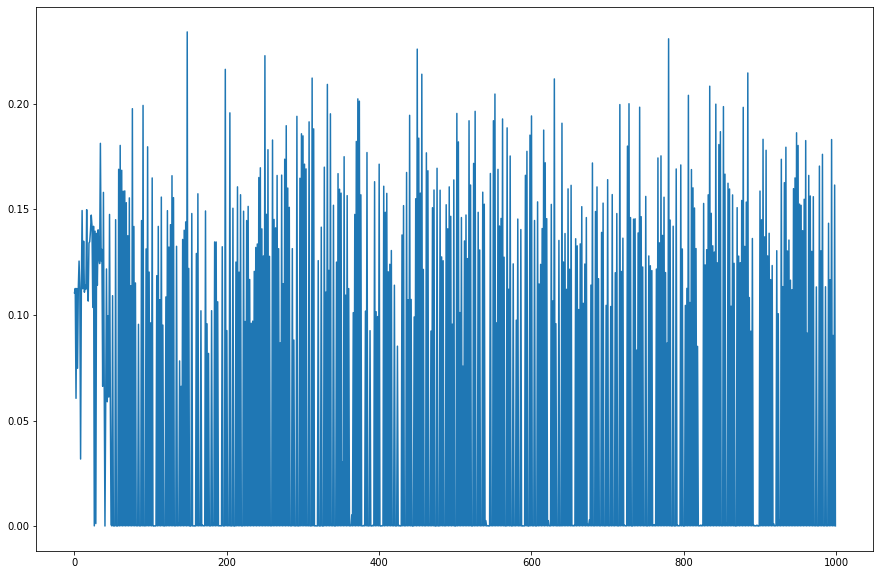

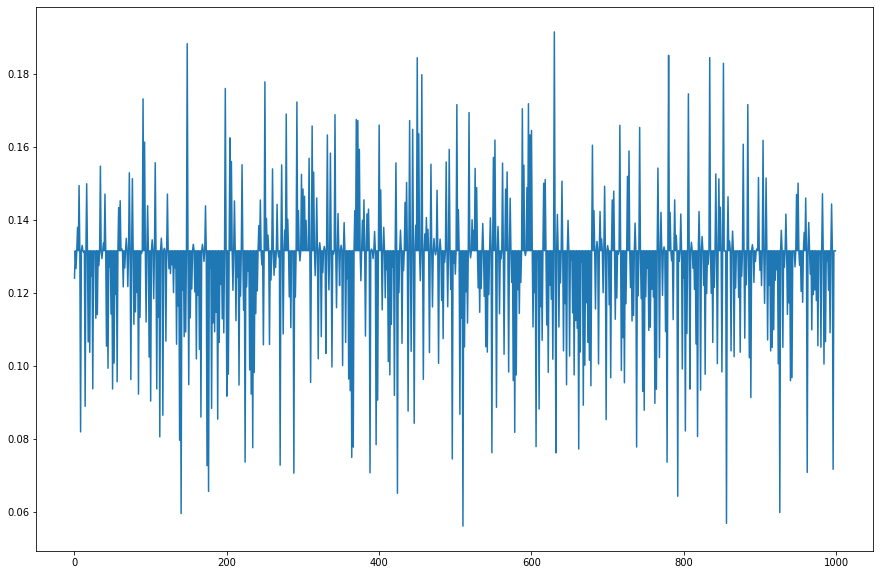

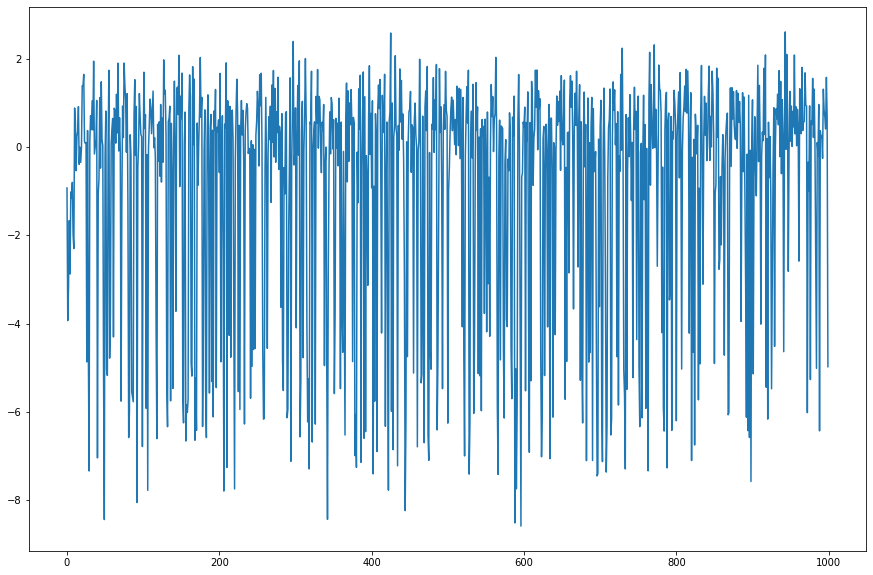

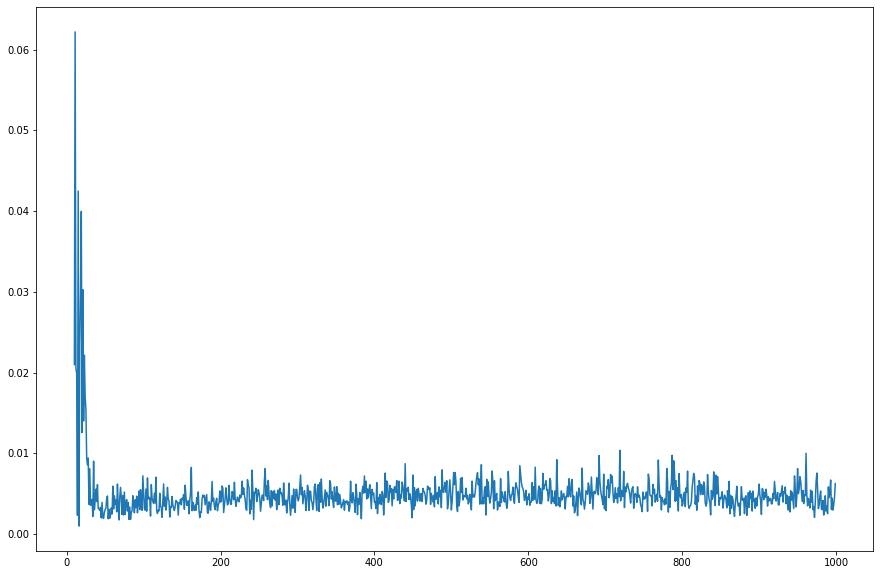

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.9)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

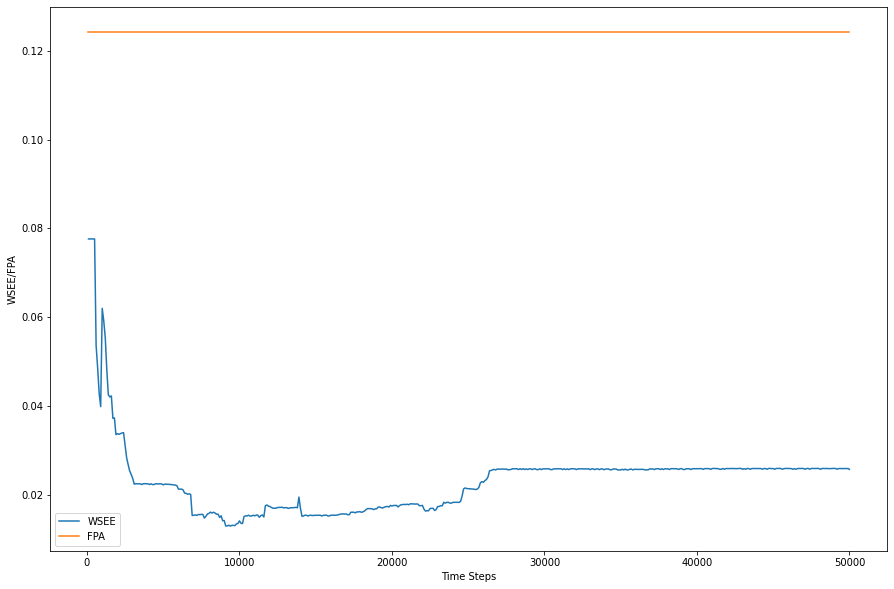

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

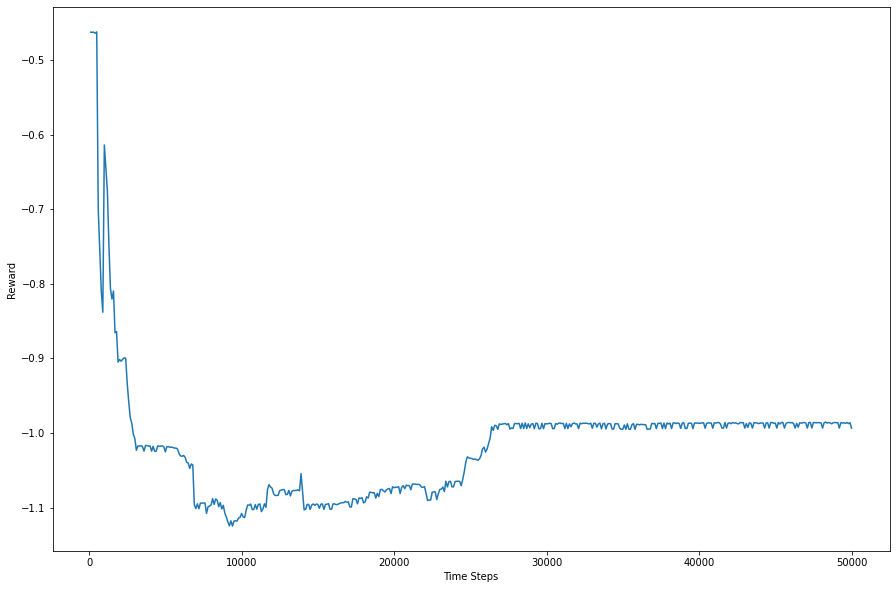

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
